## Prediction Model for Traffic Flow in South Dublin Jan-Jun 2023
#### Firstly, we want to split the prepared dataset up into Weekdays VS Weekends, traffic congestion will vary a lot depedning on the time in the week, so it is best to treat the weekdays (the working week) differently to the weekend

In [1]:
#Importations of libraries needed:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import zscore
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

In [2]:
#Import dataset as dataframe:
df = pd.read_csv('../Datasets/TrafficFlow/prepared_FlowJanJun2023.csv')
df = df.drop('ObjectId', axis=1)
df = df.drop('Unnamed: 0', axis=1) # Remove unknown column
print("The data contains {0} rows and {1} columns".format(df.shape[0], df.shape[1]))
df.head(5)

The data contains 16857 rows and 8 columns


site day        date              start_time end_time      flow  cong  \
0  N01111A  FR  06/01/2023  2023/07/04 12:00:00+00    13:15  0.968045   0.4   
1  N01111A  FR  06/01/2023  2023/07/04 12:15:00+00    13:30  0.966165   0.0   
2  N01111A  TU  03/01/2023  2023/07/04 15:00:00+00    16:15  0.821429   0.0   
3  N01111A  FR  06/01/2023  2023/07/04 14:30:00+00    15:45  0.843985   0.2   
4  N01111A  SA  07/01/2023  2023/07/04 10:00:00+00    11:15  0.907895   0.0   

       dsat  
0  0.465116  
1  0.372093  
2  0.406977  
3  0.372093  
4  0.313953

In [3]:
# Change form of start_time to match end_time
df['start_time'] = pd.to_datetime(df['start_time']).dt.strftime('%H:%M')
df.head(5)

site day        date start_time end_time      flow  cong      dsat
0  N01111A  FR  06/01/2023      12:00    13:15  0.968045   0.4  0.465116
1  N01111A  FR  06/01/2023      12:15    13:30  0.966165   0.0  0.372093
2  N01111A  TU  03/01/2023      15:00    16:15  0.821429   0.0  0.406977
3  N01111A  FR  06/01/2023      14:30    15:45  0.843985   0.2  0.372093
4  N01111A  SA  07/01/2023      10:00    11:15  0.907895   0.0  0.313953

In [4]:
# Get unique values in the 'day' column
unique_days = df['day'].unique()

# Print the unique values
print(unique_days)

['FR' 'TU' 'SA' 'MO' 'WE' 'TH' 'SU']


#### Commpare congestion weekday vs weekend

In [5]:
# Filter for weekdays
df_weekday = df[df['day'].isin(['MO', 'TU', 'WE', 'TH', 'FR'])]

# Filter for weekend
df_weekend = df[df['day'].isin(['SA', 'SU'])]

# Now, df_weekday contains entries for Monday to Friday, and df_weekend contains entries for Saturday and Sunday
print(df_weekday['day'].unique())
print(df_weekend['day'].unique())

['FR' 'TU' 'MO' 'WE' 'TH']
['SA' 'SU']


In [6]:
def showDistribution(dataframe1, dataframe2):
    columns = ['flow', 'cong', 'dsat']  # The columns to plot

    for col in columns:
        plt.figure(figsize=(10, 4))
        # Plot the first DataFrame histogram
        plt.hist(dataframe1[col], bins=30, color='r', alpha=0.6, label='Weekdays')
        # Plot the second DataFrame histogram
        plt.hist(dataframe2[col], bins=30, color='b', alpha=0.6, label='Weekends')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {col}')
        plt.legend()
        plt.show()

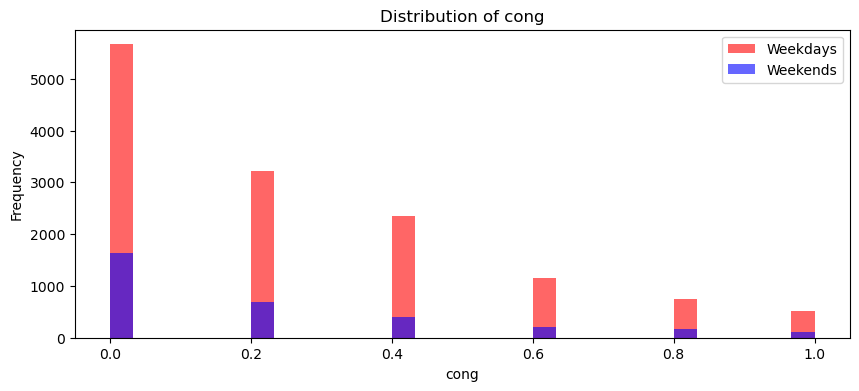

In [7]:
showDistribution(df_weekday, df_weekend)

#### Compare total `flow`, `cong` and `dsat` based on the Days

In [8]:
def showDistributionByDay(dataframe):
    columns = ['flow', 'cong', 'dsat']  # The columns to plot
    days = ['MO', 'TU', 'WE', 'TH', 'FR', 'SA', 'SU']  # Days of the week

    for col in columns:
        plt.figure(figsize=(8, 6))
        totals = []  # Initialize an empty list to store totals for all days
        for day in days:
            # Sum the values in the current column for the current day
            total = dataframe[dataframe['day'] == day][col].sum()
            totals.append(total)
        # Plot the totals for all days for the current column
        plt.bar(days, totals, alpha=0.6)
        plt.xlabel('Day')
        plt.ylabel(f'Total {col}')
        plt.title(f'Total {col} by Day')
        plt.show()


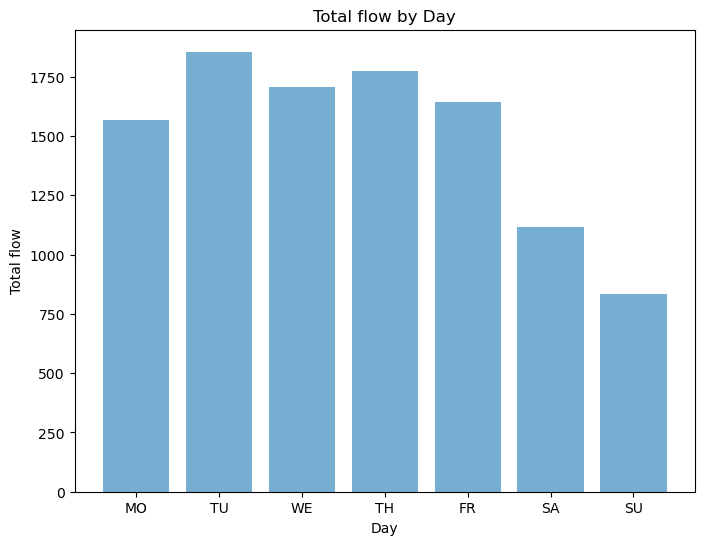

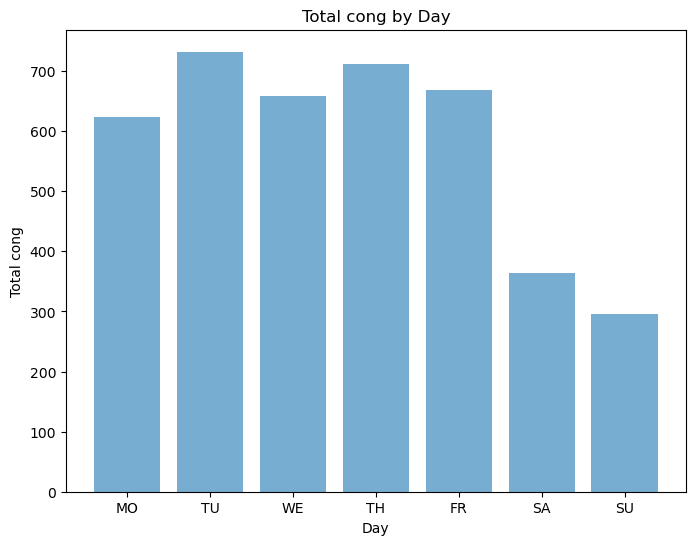

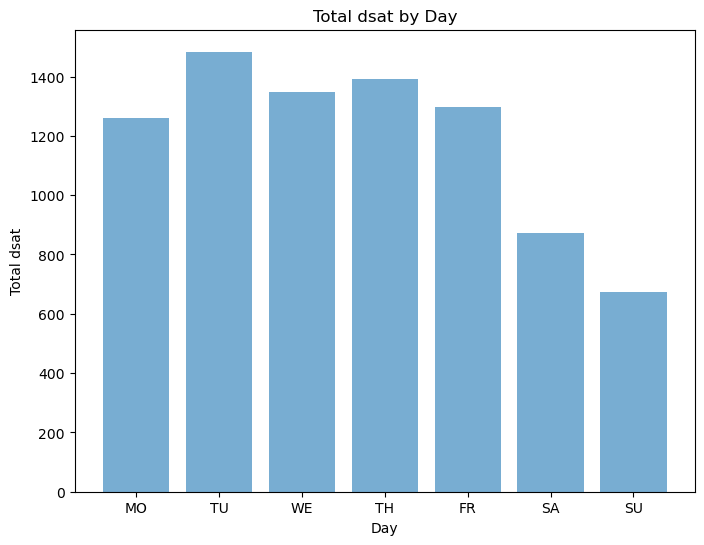

In [9]:
showDistributionByDay(df)

#### Compare total `flow`, `cong` and `dsat` based on the time

In [10]:
def showDistributionByStartTime(dataframe):
    columns = ['flow', 'cong', 'dsat']  # The columns to plot

    # Get unique start times in the order they appear in the dataframe
    unique_start_times = dataframe['start_time'].sort_values().unique()

    for col in columns:
        plt.figure(figsize=(12, 6))  # Adjusted figure size for potentially large number of unique times
        totals = []  # Initialize an empty list to store totals for each unique start time
        
        for start_time in unique_start_times:
            # Sum the values in the current column for the current start time
            total = dataframe[dataframe['start_time'] == start_time][col].sum()
            totals.append(total)
        
        # Plot the totals for each unique start time for the current column
        plt.bar(range(len(unique_start_times)), totals, alpha=0.6)
        plt.xticks(range(len(unique_start_times)), labels=unique_start_times, rotation=90)  # Rotate labels for readability
        plt.xlabel('Start Time')
        plt.ylabel(f'Total {col}')
        plt.title(f'Total {col} by Start Time')
        plt.tight_layout()  # Adjust layout to make room for label rotation
        plt.show()


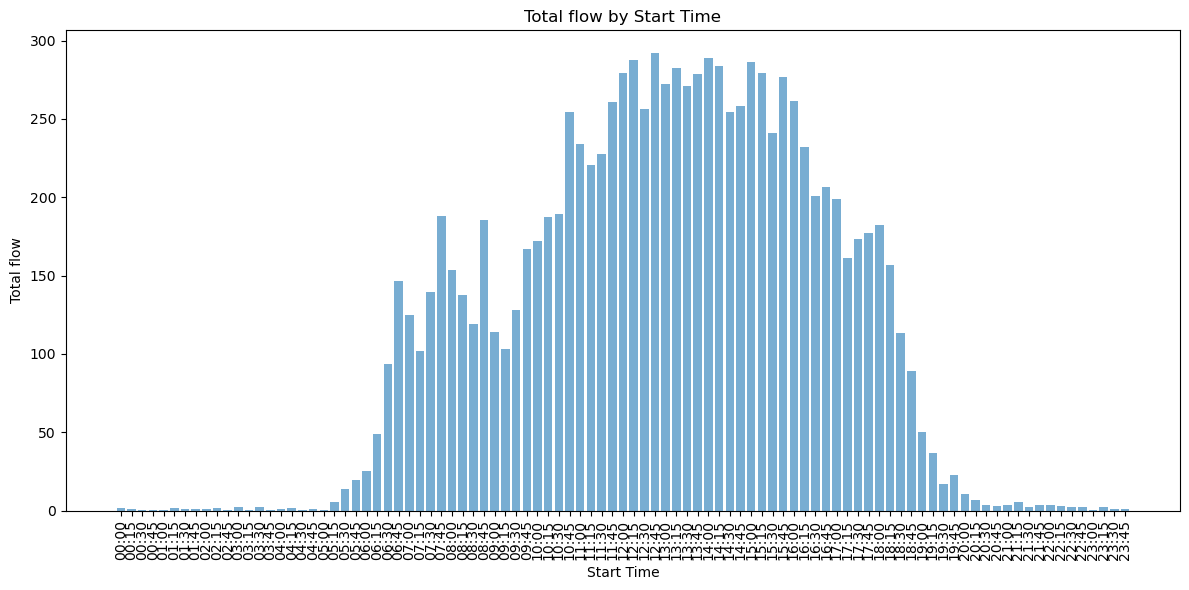

In [11]:
showDistributionByStartTime(df)

In [12]:
df_weekday.dtypes

site           object
day            object
date           object
start_time     object
end_time       object
flow          float64
cong          float64
dsat          float64
dtype: object

### Now we must reformat the data so that the formats of the data can be read by our prediction model

In [13]:
df.head(5)

site day        date start_time end_time      flow  cong      dsat
0  N01111A  FR  06/01/2023      12:00    13:15  0.968045   0.4  0.465116
1  N01111A  FR  06/01/2023      12:15    13:30  0.966165   0.0  0.372093
2  N01111A  TU  03/01/2023      15:00    16:15  0.821429   0.0  0.406977
3  N01111A  FR  06/01/2023      14:30    15:45  0.843985   0.2  0.372093
4  N01111A  SA  07/01/2023      10:00    11:15  0.907895   0.0  0.313953

In [14]:
def reformatDatafram(dataframe):
    # Handle "24:00" in 'end_time'
    dataframe['end_time'] = dataframe['end_time'].replace('24:00', '00:00')

    # Convert 'date' to datetime
    dataframe['date'] = pd.to_datetime(dataframe['date'], format='%d/%m/%Y')

    # Convert 'start_time' and 'end_time' to datetime
    dataframe['start_time'] = pd.to_datetime(dataframe['start_time'], format='%H:%M')
    dataframe['end_time'] = pd.to_datetime(dataframe['end_time'], format='%H:%M')

    # Increment the date by one day where end_time is "00:00"
    dataframe.loc[dataframe['end_time'].dt.strftime('%H:%M') == '00:00', 'date'] += pd.Timedelta(days=1)

    # Extract year, month, and day as new features
    dataframe['year'] = dataframe['date'].dt.year
    dataframe['month'] = dataframe['date'].dt.month
    dataframe['day_of_month'] = dataframe['date'].dt.day

    # Calculate duration in minutes as a new feature
    dataframe['duration'] = (dataframe['end_time'] - dataframe['start_time']).dt.total_seconds() / 60

    # Extract hour and minute from 'start_time' and 'end_time'
    dataframe['start_hour'] = dataframe['start_time'].dt.hour
    dataframe['start_minute'] = dataframe['start_time'].dt.minute
    dataframe['end_hour'] = dataframe['end_time'].dt.hour
    dataframe['end_minute'] = dataframe['end_time'].dt.minute

    # Convert 'site' and 'day' to string type
    dataframe['site'] = dataframe['site'].astype(str)
    dataframe['day'] = dataframe['day'].astype(str)

    # One-hot encode 'site' and 'day' features
    dataframe = pd.get_dummies(dataframe, columns=['site', 'day'])

    # Now drop the original 'date', 'start_time', and 'end_time' columns as they are not needed
    dataframe = dataframe.drop(['date', 'start_time', 'end_time'], axis=1)
    
    return dataframe

In [15]:
df_weekday.head(5)

site day        date start_time end_time      flow  cong      dsat
0  N01111A  FR  06/01/2023      12:00    13:15  0.968045   0.4  0.465116
1  N01111A  FR  06/01/2023      12:15    13:30  0.966165   0.0  0.372093
2  N01111A  TU  03/01/2023      15:00    16:15  0.821429   0.0  0.406977
3  N01111A  FR  06/01/2023      14:30    15:45  0.843985   0.2  0.372093
5  N01111A  MO  09/01/2023      12:45    14:00  0.956767   0.2  0.372093

In [16]:
df_weekday = reformatDatafram(df_weekday)
df_weekend = reformatDatafram(df_weekend)

/var/folders/fj/1ykv5jrn7k5bplnhdvwsmzmr0000gn/T/ipykernel_2070/464071904.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['end_time'] = dataframe['end_time'].replace('24:00', '00:00')
/var/folders/fj/1ykv5jrn7k5bplnhdvwsmzmr0000gn/T/ipykernel_2070/464071904.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['date'] = pd.to_datetime(dataframe['date'], format='%d/%m/%Y')
/var/folders/fj/1ykv5jrn7k5bplnhdvwsmzmr0000gn/T/ipykernel_2070/464071904.py:9: SettingWithCopyWarning: 
A value is

In [17]:
# Set option to display all columns
pd.set_option('display.max_columns', None)

# Now, when you display your DataFrame, all columns will be shown
print(df_weekday)
print(df_weekend)

           flow  cong      dsat  year  month  day_of_month  duration  \
0      0.968045   0.4  0.465116  2023      1             6      75.0   
1      0.966165   0.0  0.372093  2023      1             6      75.0   
2      0.821429   0.0  0.406977  2023      1             3      75.0   
3      0.843985   0.2  0.372093  2023      1             6      75.0   
5      0.956767   0.2  0.372093  2023      1             9      75.0   
...         ...   ...       ...   ...    ...           ...       ...   
16846  0.851504   0.4  0.569767  2023      5            30      75.0   
16847  0.945489   0.4  0.523256  2023      6             2      75.0   
16850  0.928571   0.0  0.627907  2023      6            13      75.0   
16851  0.892857   0.0  0.441860  2023      6            14      75.0   
16856  0.889098   0.0  0.569767  2023      6            28      75.0   

       start_hour  start_minute  end_hour  end_minute  site_N01111A  \
0              12             0        13          15          T

In [18]:
df_weekday.shape

(13659, 57)

In [19]:
df_weekday.head(5)

flow  cong      dsat  year  month  day_of_month  duration  start_hour  \
0  0.968045   0.4  0.465116  2023      1             6      75.0          12   
1  0.966165   0.0  0.372093  2023      1             6      75.0          12   
2  0.821429   0.0  0.406977  2023      1             3      75.0          15   
3  0.843985   0.2  0.372093  2023      1             6      75.0          14   
5  0.956767   0.2  0.372093  2023      1             9      75.0          12   

   start_minute  end_hour  end_minute  site_N01111A  site_N01111C  \
0             0        13          15          True         False   
1            15        13          30          True         False   
2             0        16          15          True         False   
3            30        15          45          True         False   
5            45        14           0          True         False   

   site_N01111D  site_N01111M  site_N01111R  site_N01121E  site_N01121G  \
0         False         False         False         False         False   
1         False         False         False         False         False   
2         False         False         False         False         False   
3         False         False         False         False         False   
5         False         False         False         False         False   

   site_N01121H  site_N01121J  site_N01121V  site_N01121Y  site_N01131A  \
0         False         False         False         False         False   
1         False         False         False         False         False   
2         False         False         False         False         False   
3         False         False         False         False         False   
5         False         False         False         False         False   

   site_N01131B  site_N01131C  site_N01131F  site_N01131P  site_N01141G  \
0         False         False         False         False         False   
1         False         False         False         False         False   
2         False         False         False         False         False   
3         False         False         False         False         False   
5         False         False         False         False         False   

   site_N01151A  site_N01151B  site_N01151C  site_N01151D  site_N01151J  \
0         False         False         False         False         False   
1         False         False         False         False         False   
2         False         False         False         False         False   
3         False         False         False         False         False   
5         False         False         False         False         False   

   site_N01151L  site_N02111A  site_N02111B  site_N02111C  site_N02111D  \
0         False         False         False         False         False   
1         False         False         False         False         False   
2         False         False         False         False         False   
3         False         False         False         False         False   
5         False         False         False         False         False   

   site_N02111K  site_N02111M  site_N02121E  site_N02121G  site_N02121H  \
0         False         False         False         False         False   
1         False         False         False         False         False   
2         False         False         False         False         False   
3         False         False         False         False         False   
5         False         False         False         False         False   

   site_N02131A  site_N02131C  site_N02131D  site_N03111D  site_N03111L  \
0         False         False         False         False         False   
1         False         False         False         False         False   
2         False         False         False         False         False   
3         False         False         False         False         False   
5         False         False 

In [20]:
df_weekend.shape

(3198, 48)

In [21]:
df_weekend.head(5)

flow  cong      dsat  year  month  day_of_month  duration  start_hour  \
4   0.907895   0.0  0.313953  2023      1             7      75.0          10   
9   0.919173   0.4  0.511628  2023      1             7      75.0          15   
16  0.795113   0.4  0.325581  2023      1            15      75.0          14   
32  0.836466   0.0  0.348837  2023      1            22      75.0          12   
34  0.994361   0.2  0.418605  2023      1            21      75.0          10   

    start_minute  end_hour  end_minute  site_N01111A  site_N01111C  \
4              0        11          15          True         False   
9             15        16          30          True         False   
16             0        15          15          True         False   
32            45        14           0          True         False   
34            30        11          45          True         False   

    site_N01111D  site_N01121E  site_N01121G  site_N01121H  site_N01121J  \
4          False         False         False         False         False   
9          False         False         False         False         False   
16         False         False         False         False         False   
32         False         False         False         False         False   
34         False         False         False         False         False   

    site_N01121V  site_N01121Y  site_N01131A  site_N01131B  site_N01131C  \
4          False         False         False         False         False   
9          False         False         False         False         False   
16         False         False         False         False         False   
32         False         False         False         False         False   
34         False         False         False         False         False   

    site_N01131F  site_N01151A  site_N01151B  site_N01151C  site_N01151J  \
4          False         False         False         False         False   
9          False         False         False         False         False   
16         False         False         False         False         False   
32         False         False         False         False         False   
34         False         False         False         False         False   

    site_N01151L  site_N02111A  site_N02111B  site_N02111C  site_N02111D  \
4          False         False         False         False         False   
9          False         False         False         False         False   
16         False         False         False         False         False   
32         False         False         False         False         False   
34         False         False         False         False         False   

    site_N02111K  site_N02111M  site_N02121E  site_N02121G  site_N02121H  \
4          False         False         False         False         False   
9          False         False         False         False         False   
16         False         False         False         False         False   
32         False         False         False         False         False   
34         False         False         False         False         False   

    site_N02131A  site_N02131C  site_N02131D  site_N03111D  site_N03111L  \
4          False         False         False         False         False   
9          False         False         False         False         False   
16         False         False         False         False         False   
32         False         False         False         False         False   
34         False         False         False         False         False   

    site_N03121D  site_N03121F  site_N03121G  day_SA  day_SU  
4          False         False         False    True   False  
9          False         False         False    True   False  
16         False         False         False   False    True  
32         False         False         False   False    True  
34         False         False         Fals

## Prediciton Model

Evaluation metrics are crucial for assessing the performance of regression models. Each metric offers unique insights but also comes with its own set of advantages and disadvantages. Let's go through the metrics you've mentioned:

#### 1. MAE (Mean Absolute Error)
**Advantages:**
- **Interpretability:** The MAE is measured in the same units as the data, making it easy to understand and interpret.
- **Robustness:** It is less sensitive to outliers compared to MSE, as it treats all errors linearly.

**Disadvantages:**
- **Scale Dependency:** The MAE can vary significantly with the scale of the data, making it hard to compare across different datasets.
- **Lack of Sensitivity to Small Errors:** Because all errors are treated equally, it might not reflect well on the performance of the model when small errors are critical to the application.

#### 2. MSE (Mean Squared Error)
**Advantages:**
- **Sensitivity to Large Errors:** The squaring of errors penalizes large errors more than smaller ones, which can be beneficial in many applications where large errors are particularly undesirable.
- **Differentiability:** The MSE function is continuously differentiable, making it more suitable for optimization using gradient descent.

**Disadvantages:**
- **Impact of Outliers:** Due to squaring, outliers have a more pronounced effect on MSE, potentially skewing the model evaluation.
- **Scale Dependency:** Like MAE, the MSE is dependent on the scale of the data, making comparisons across datasets difficult. Additionally, the units of MSE are squared, making interpretation less intuitive.

#### 3. RMSE (Root Mean Squared Error)
**Advantages:**
- **Interpretability:** Taking the square root of MSE makes the scale similar to the original data, improving interpretability compared to MSE.
- **Sensitivity to Large Errors:** Like MSE, RMSE is more sensitive to large errors, making it useful for emphasizing significant errors.

**Disadvantages:**
- **Outlier Sensitivity:** RMSE retains MSE's sensitivity to outliers, which can disproportionately affect the model evaluation.
- **Scale Dependency:** RMSE is still scale-dependent and can vary with the data's scale.

#### 4. R² (R-Squared)
**Advantages:**
- **Interpretability:** R² provides a measure of how well future samples are likely to be predicted by the model. It's expressed as a percentage, making it intuitive.
- **Scale Independence:** R² is scale-independent, making it useful for comparing models across different datasets.

**Disadvantages:**
- **Non-linearity Sensitivity:** R² assumes a linear relationship between predictors and response, which can be misleading for models that don't meet this assumption.
- **No Insight on Error Magnitude:** R² doesn't convey the size of errors directly, so a high R² model can still have large predictive errors.

#### 5. MAPE (Mean Absolute Percentage Error)
**Advantages:**
- **Scale Independence:** MAPE is expressed as a percentage, making it scale-independent and suitable for comparing models across different scales.
- **Interpretability:** It directly measures the average percentage error, making it intuitive for understanding model accuracy in terms of relative error.

**Disadvantages:**
- **Undefined for Zero Values:** MAPE becomes undefined or infinitely large when the actual values include zeros, making it unsuitable for datasets with zero or near-zero values.
- **Disproportionate Impact of Small Errors:** Small actual values lead to disproportionately large errors, potentially skewing the evaluation.

In [22]:
def get_location_from_scn(input_string, scn_to_locn_mapping):
    for scn in scn_to_locn_mapping.keys():
        if scn in input_string:
            return scn_to_locn_mapping[scn]
    return input_string


In [23]:
scn_to_locn_mapping = {
    'N01111': 'Airton GrHill',
    'N01121': 'Mayberry GrHill',
    'N01131': 'Tymon North',
    'N01141': 'Cuckoos Nest',
    'N01151': 'Harvey GrHills',
    'N02111': 'OB Rd Old Court',
    'N02121': 'Kiltipper',
    'N02131': 'Firhouse Rd W',
    'N03111': 'ORR Lucan Road',
    'N03121': 'N4 Off Ramp EB',
    'N03131': 'ORR-Hermitage',
    'N03141': 'ORR-Ballyowen',
    'N04111': 'N4 OVAL',
    'N04121': 'N4-Kennelsfort',
    'N05111': 'Old Belgard/Emb',
    'N05121': 'Belgard/Embank',
    'N05131': 'BelgrdCookstown',
    'N05141': 'Belgrd/Mayberry',
    'N06111': 'Embank/Sylvan',
    'N07111': 'M50 I/C East SB',
    'N07112': 'FL L/T to M50',
    'N07113': 'M50 FL L/T O/R',
    'N07121': 'M50 I/C West NB',
    'N07122': 'FI-LT to M50 NB',
    'N08111': 'Killyninny Junc',
    'N08112': 'N4-Newcastle SO',
    'N08113': 'hillcrest junc',
    'N08114': 'hillcrest Remote',
    'N13111': 'T376-Castleside',
    'N13121': 'P488 Castle STO',
    'N13122': 'P488 Castle ST1',
    'N13131': 'T380-Butter STO',
    'N13132': 'T380-Butt ST1',
    'N13141': 'T337b-Yellow Hs',
    'N13151': 'T338-Nutgrove',
    'N25191': 'FIRHOUSE-MORTON',
    'N25211': 'Firehouse-Delfor'
}

# Weekdays (Mon-Fri)

In [24]:
sites_columns = [col for col in df_weekday.columns if col.startswith('site_')]
# Now, `sites_columns` is a list of column names that start with 'site_'
for index, site in enumerate(sites_columns):
    print(f"Index: {index}, Site Column: {site}")

Index: 0, Site Column: site_N01111A
Index: 1, Site Column: site_N01111C
Index: 2, Site Column: site_N01111D
Index: 3, Site Column: site_N01111M
Index: 4, Site Column: site_N01111R
Index: 5, Site Column: site_N01121E
Index: 6, Site Column: site_N01121G
Index: 7, Site Column: site_N01121H
Index: 8, Site Column: site_N01121J
Index: 9, Site Column: site_N01121V
Index: 10, Site Column: site_N01121Y
Index: 11, Site Column: site_N01131A
Index: 12, Site Column: site_N01131B
Index: 13, Site Column: site_N01131C
Index: 14, Site Column: site_N01131F
Index: 15, Site Column: site_N01131P
Index: 16, Site Column: site_N01141G
Index: 17, Site Column: site_N01151A
Index: 18, Site Column: site_N01151B
Index: 19, Site Column: site_N01151C
Index: 20, Site Column: site_N01151D
Index: 21, Site Column: site_N01151J
Index: 22, Site Column: site_N01151L
Index: 23, Site Column: site_N02111A
Index: 24, Site Column: site_N02111B
Index: 25, Site Column: site_N02111C
Index: 26, Site Column: site_N02111D
Index: 27, 

### ML Model

In [25]:
# Prediction Model

# Normalize all features except 'start_hour'
columns_to_normalize = df_weekday.columns.difference(['flow'])
X_to_normalize = df_weekday[columns_to_normalize]
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_to_normalize)
X_normalized_df = pd.DataFrame(X_normalized, columns=columns_to_normalize, index=df_weekday.index)

# Add 'start_hour' back to the features without normalization
X_normalized_df['start_hour'] = df_weekday['start_hour'] 

X_normalized_df = X_normalized_df.drop(columns=['cong', 'dsat'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized_df, df_weekday[['flow']], test_size=0.2, random_state=23) #removed cong and dsat from this

# Reshape input to be [samples, time steps, features]
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Function to create and evaluate the model, now including 'start_hour' in training
def train_and_evaluate_model(neurons, lr, activation):
    model = Sequential([
        LSTM(neurons, activation=activation, input_shape=(1, X_train.shape[1])),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
    
    # Fit model
    model.fit(X_train_reshaped, y_train, epochs=100, validation_data=(X_test_reshaped, y_test), batch_size=32, verbose=0)
    
    # Predict on test set
    predictions = model.predict(X_test_reshaped)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = sqrt(mse)
    r2 = r2_score(y_test, predictions)
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

    print(f"MAE:{mae} || RMSE:{rmse} || MSE:{mse} || R2:{r2} || MAPE:{mape} || Model: {model}")
    print("==========================================================================")

    return mae, mse, rmse, r2, mape, model

# Parameters for model training
neurons = [10, 50, 100]
learning_rates = [0.001, 0.01, 0.1]
activation_functions = ['relu', 'tanh', 'sigmoid']

# Store results
results = []

# Iterate over parameter combinations
for neuron in neurons:
    for lr in learning_rates:
        for activation in activation_functions:
            mae, mse, rmse, r2, mape, trained_model = train_and_evaluate_model(neuron, lr, activation)
            results.append({
                'neurons': neuron,
                'learning_rate': lr,
                'activation': activation,
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse,
                'R2': r2,
                'MAPE': mape,
                'model': trained_model
            })

# Find the best model configuration
best_result = sorted(results, key=lambda x: x['MAE'])[0]
best_model = best_result['model']

# Predict on reshaped test set with the best model
predictions = best_model.predict(X_test_reshaped)

print("Best configuration:", best_result)


86/86 [==============================] - 0s 510us/step


MAE:0.07384155702267588 || RMSE:0.0980522572232672 || MSE:0.009614245146577754 || R2:0.8713536627123517 || MAPE:17.403447292546414 || Model: <keras.src.engine.sequential.Sequential object at 0x29031b250>
86/86 [==============================] - 0s 342us/step


MAE:0.07788040949238134 || RMSE:0.10293755128234337 || MSE:0.010596139464005071 || R2:0.8582151265491103 || MAPE:19.466380737493306 || Model: <keras.src.engine.sequential.Sequential object at 0x29030a150>
86/86 [==============================] - 0s 324us/step


MAE:0.08157447493954083 || RMSE:0.10765741883637517 || MSE:0.011590119830510708 || R2:0.8449148693227485 || MAPE:23.28703261482381 || Model: <keras.src.engine.sequential.Sequential object at 0x2902c5090>
86/86 [==============================] - 0s 321us/step


MAE:0.07384117880072547 || RMSE:0.09823096959805619 || MSE:0.009649323388174239 || R2:0.8708842876099823 || MAPE:20.166313332009896 || Model: <keras.src.engine.sequential.Sequential object at 0x28ff93710>
86/86 [==============================] - 0s 340us/step


MAE:0.07550985671794197 || RMSE:0.0985835475904557 || MSE:0.009718715855519646 || R2:0.8699557605521386 || MAPE:17.36032627932239 || Model: <keras.src.engine.sequential.Sequential object at 0x28ff91650>
86/86 [==============================] - 0s 403us/step


MAE:0.07260580503816833 || RMSE:0.09591536430088482 || MSE:0.009199757108971451 || R2:0.8768998462217846 || MAPE:18.0836799681107 || Model: <keras.src.engine.sequential.Sequential object at 0x298b08510>
86/86 [==============================] - 0s 333us/step


MAE:0.236653452943738 || RMSE:0.286932547284522 || MSE:0.08233028669118446 || R2:-0.1016454926191479 || MAPE:96.30570511557849 || Model: <keras.src.engine.sequential.Sequential object at 0x29bc8a690>
86/86 [==============================] - 0s 335us/step


MAE:0.10346626184749419 || RMSE:0.1314240420122021 || MSE:0.017272278818825062 || R2:0.7688830092455243 || MAPE:24.367146724866362 || Model: <keras.src.engine.sequential.Sequential object at 0x28ff937d0>
86/86 [==============================] - 0s 327us/step


MAE:0.07840949173987474 || RMSE:0.10204604861145619 || MSE:0.01041339603721168 || R2:0.8606603806654702 || MAPE:21.195739853970096 || Model: <keras.src.engine.sequential.Sequential object at 0x29fdc3850>
86/86 [==============================] - 0s 343us/step


MAE:0.07228975158103691 || RMSE:0.09651444544325213 || MSE:0.009315038179218494 || R2:0.8753572927274876 || MAPE:21.639469265340622 || Model: <keras.src.engine.sequential.Sequential object at 0x2a2a6f610>
86/86 [==============================] - 0s 344us/step


MAE:0.07716770272274637 || RMSE:0.10172306947938263 || MSE:0.010347582864307306 || R2:0.8615410138831952 || MAPE:20.47595227046128 || Model: <keras.src.engine.sequential.Sequential object at 0x2a51479d0>
86/86 [==============================] - 0s 338us/step


MAE:0.08259423258745086 || RMSE:0.10860818017462108 || MSE:0.011795736800842956 || R2:0.8421635487859674 || MAPE:23.529835947633696 || Model: <keras.src.engine.sequential.Sequential object at 0x2a1f1cdd0>
86/86 [==============================] - 0s 340us/step


MAE:0.07803204477779523 || RMSE:0.10025955438393414 || MSE:0.010051978245265046 || R2:0.8654964415787989 || MAPE:22.815912285621003 || Model: <keras.src.engine.sequential.Sequential object at 0x2a8a24350>
86/86 [==============================] - 0s 358us/step


MAE:0.07699606046091252 || RMSE:0.10139189680974146 || MSE:0.010280316738677261 || R2:0.8624410887776777 || MAPE:20.432712433973926 || Model: <keras.src.engine.sequential.Sequential object at 0x2a8a24410>
86/86 [==============================] - 0s 440us/step


MAE:0.08280847975602929 || RMSE:0.10750378706360926 || MSE:0.011557064233017842 || R2:0.8453571798192543 || MAPE:25.477726734942173 || Model: <keras.src.engine.sequential.Sequential object at 0x2cc459b90>
86/86 [==============================] - 0s 340us/step


MAE:0.10724514821255848 || RMSE:0.14354337116931665 || MSE:0.020604699406652206 || R2:0.7242925399585503 || MAPE:35.5326878014872 || Model: <keras.src.engine.sequential.Sequential object at 0x2a43b0e10>
86/86 [==============================] - 0s 356us/step


MAE:0.09919064293864727 || RMSE:0.12633573988969118 || MSE:0.01596071917347571 || R2:0.7864327328001125 || MAPE:26.106700184430043 || Model: <keras.src.engine.sequential.Sequential object at 0x2d1cd9a50>
86/86 [==============================] - 0s 422us/step


MAE:0.08380489349643282 || RMSE:0.10714198472106207 || MSE:0.011479404889968297 || R2:0.8463963243269275 || MAPE:23.565808922357544 || Model: <keras.src.engine.sequential.Sequential object at 0x2d330b010>
86/86 [==============================] - 0s 378us/step


MAE:0.07573301771624286 || RMSE:0.09985988908645062 || MSE:0.00997199744835822 || R2:0.8665666490073116 || MAPE:23.76957626911156 || Model: <keras.src.engine.sequential.Sequential object at 0x2d1a385d0>
86/86 [==============================] - 0s 398us/step


MAE:0.07732016321605766 || RMSE:0.10218890219245538 || MSE:0.010442571731299213 || R2:0.8602699863989456 || MAPE:19.87077446091746 || Model: <keras.src.engine.sequential.Sequential object at 0x2d56aab50>
86/86 [==============================] - 0s 396us/step


MAE:0.08267542482842226 || RMSE:0.10898467179934263 || MSE:0.011877658687210427 || R2:0.8410673680183467 || MAPE:22.828808610051805 || Model: <keras.src.engine.sequential.Sequential object at 0x2d5f4a110>
86/86 [==============================] - 0s 383us/step


MAE:0.07588387652997866 || RMSE:0.10772126665807182 || MSE:0.011603871290419416 || R2:0.84473086372245 || MAPE:23.340526038808875 || Model: <keras.src.engine.sequential.Sequential object at 0x2dbe440d0>
86/86 [==============================] - 0s 398us/step


MAE:0.07390621732305877 || RMSE:0.09709949916267543 || MSE:0.009428312737642407 || R2:0.8738415879761583 || MAPE:18.967212359995305 || Model: <keras.src.engine.sequential.Sequential object at 0x2dd008850>
86/86 [==============================] - 0s 393us/step


MAE:0.07355082462112171 || RMSE:0.0973492227655193 || MSE:0.0094768711730507 || R2:0.873191837032173 || MAPE:19.50998716499169 || Model: <keras.src.engine.sequential.Sequential object at 0x2dfb43c90>
86/86 [==============================] - 0s 377us/step


MAE:0.20023210468768562 || RMSE:0.2309703443647118 || MSE:0.053347299975953555 || R2:0.28617019417954226 || MAPE:42.480724833499636 || Model: <keras.src.engine.sequential.Sequential object at 0x2e12bf1d0>
86/86 [==============================] - 0s 509us/step


MAE:0.09857457354076721 || RMSE:0.1250987173265748 || MSE:0.015649689076754267 || R2:0.7905945658009779 || MAPE:31.49815550001161 || Model: <keras.src.engine.sequential.Sequential object at 0x2d780f950>
86/86 [==============================] - 0s 388us/step
MAE:0.09182432891113695 || RMSE:0.11939879438518515 || MSE:0.014256072100635722 || R2:0.8092422824782831 || MAPE:28.75300339492013 || Model: <keras.src.engine.sequential.Sequential object at 0x2e5dc6510>
86/86 [==============================] - 0s 299us/step
Best configuration: {'neurons': 50, 'learning_rate': 0.001, 'activation': 'relu', 'MAE': 0.07228975158103691, 'MSE': 0.009315038179218494, 'RMSE': 0.09651444544325213, 'R2': 0.8753572927274876, 'MAPE': 21.639469265340622, 'model': <keras.src.engine.sequential.Sequential object at 0x2a2a6f610>}


### Display Results

#### `Flow`

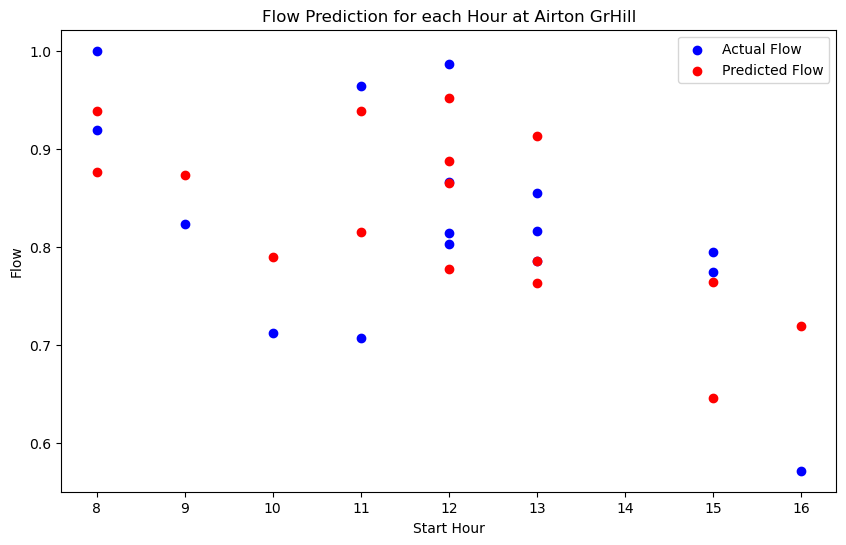

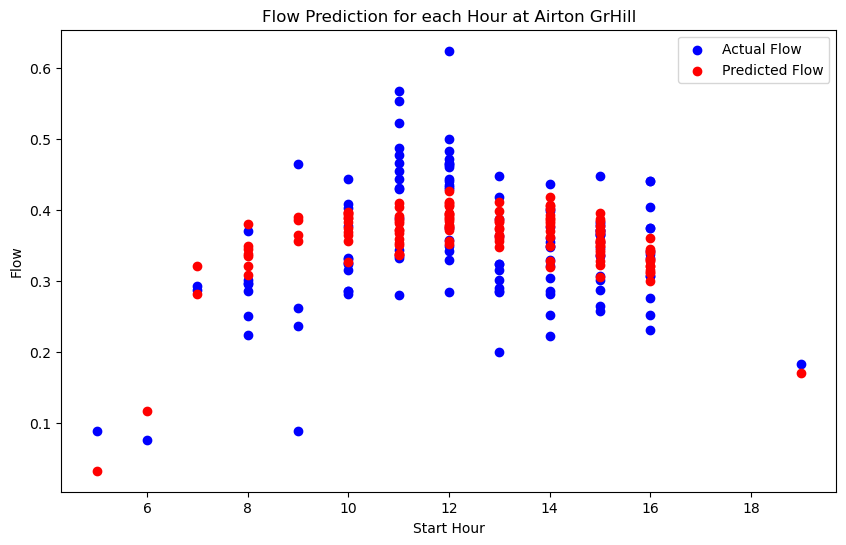

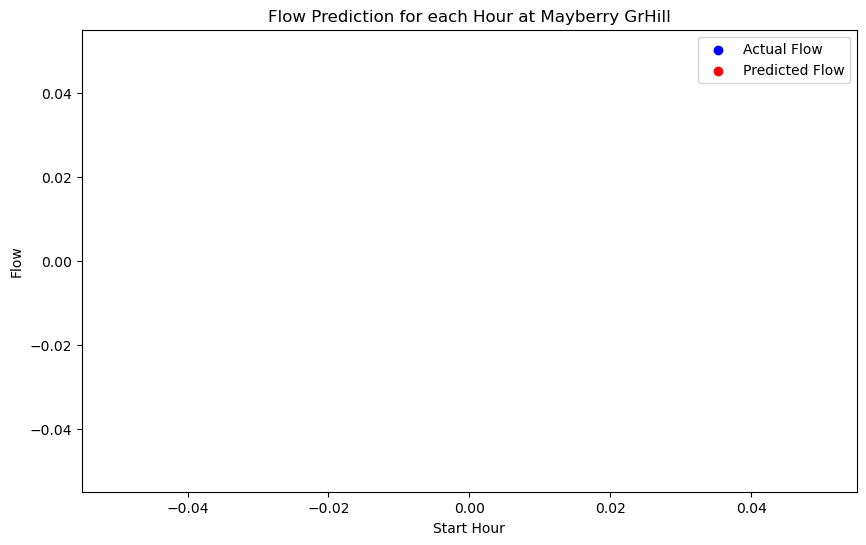

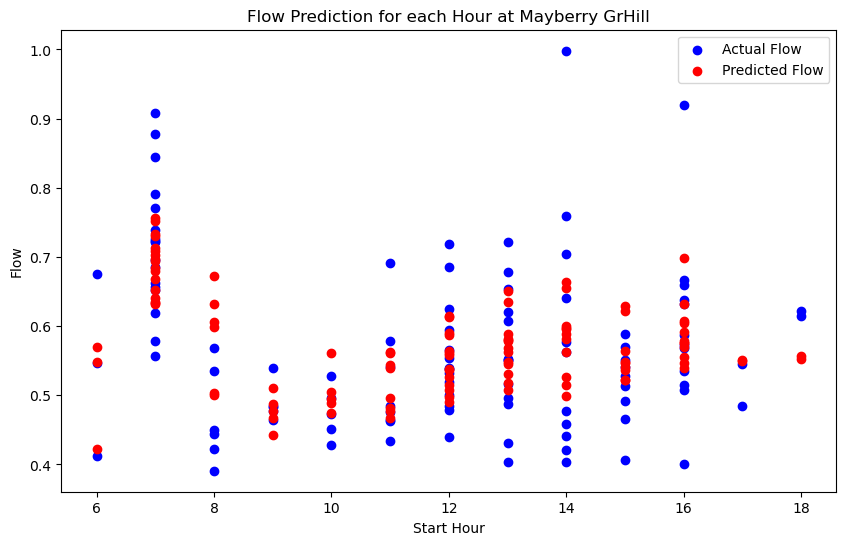

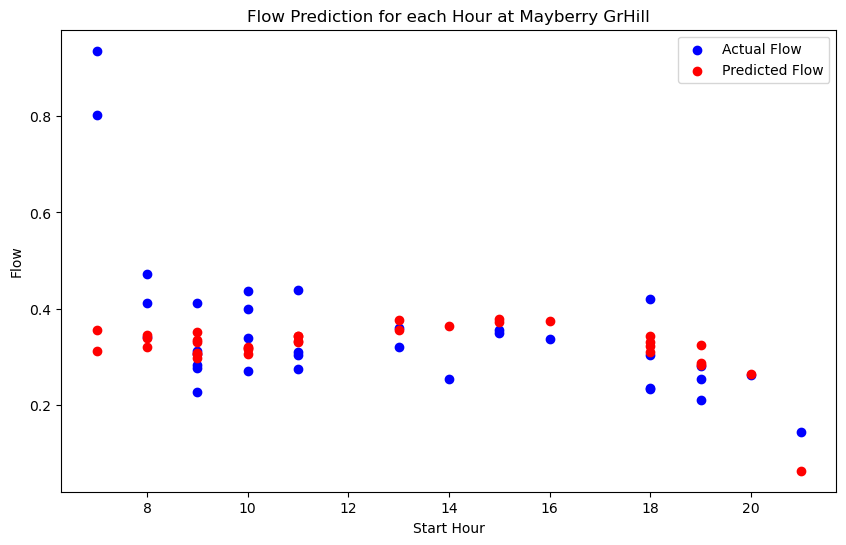

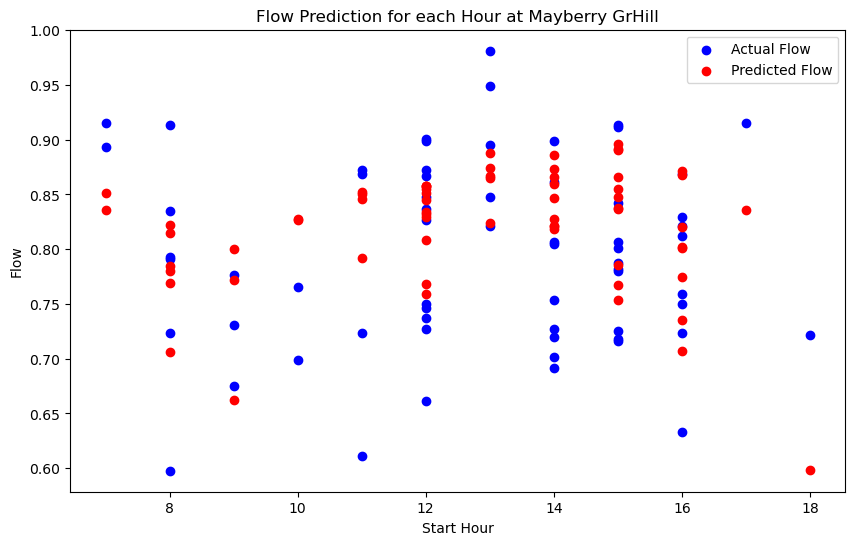

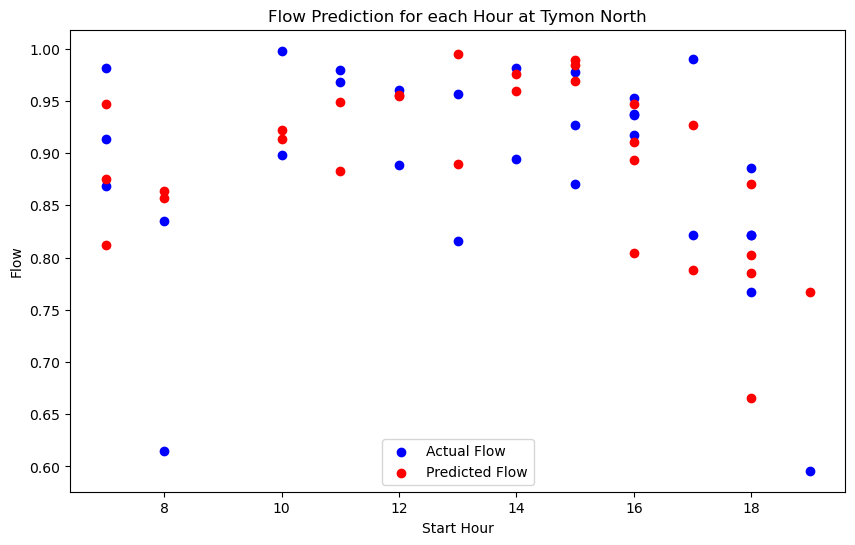

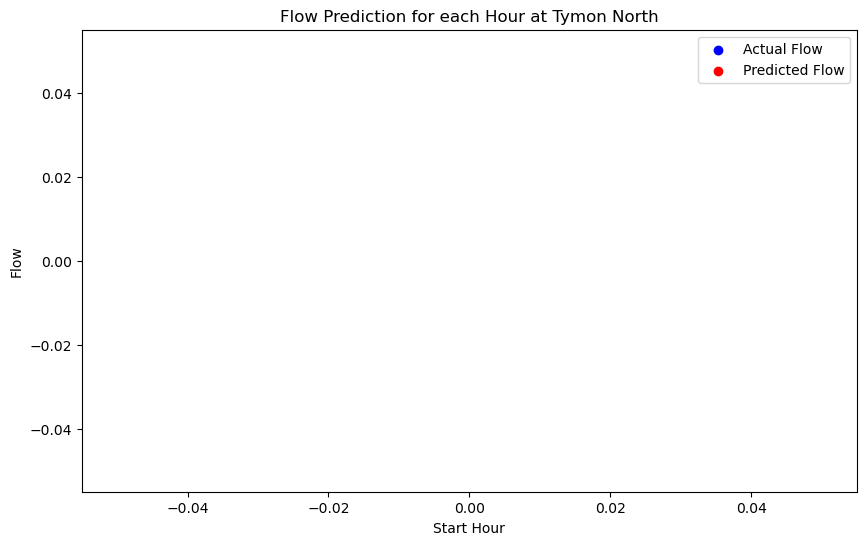

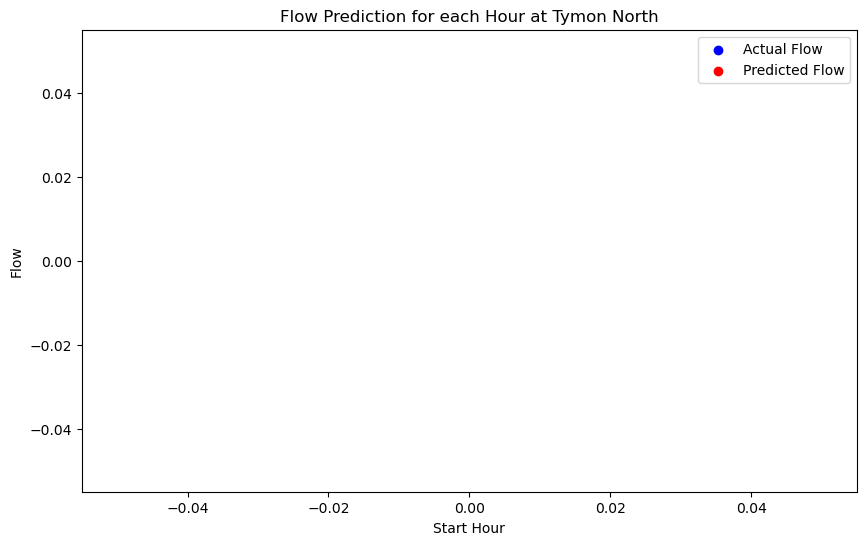

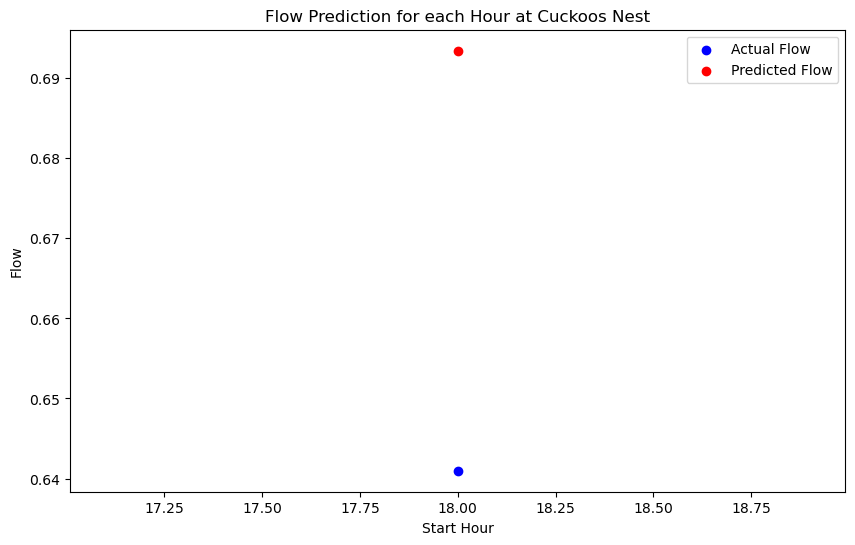

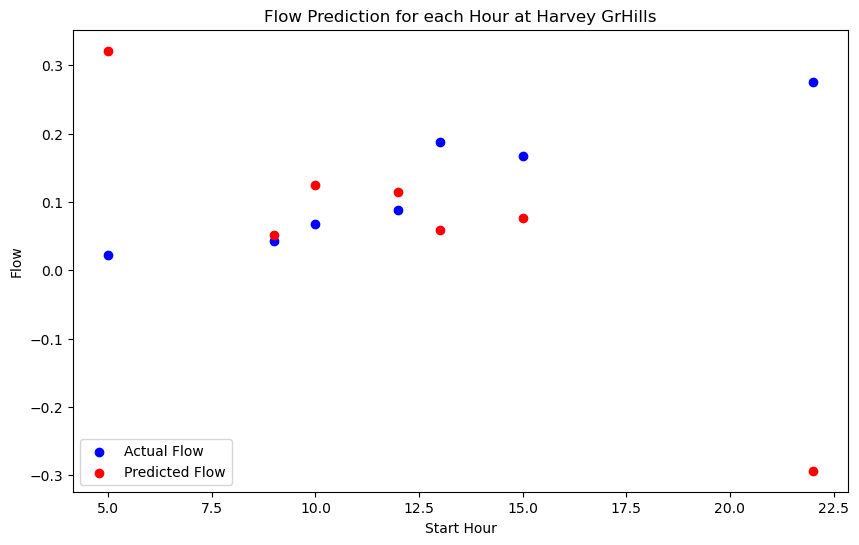

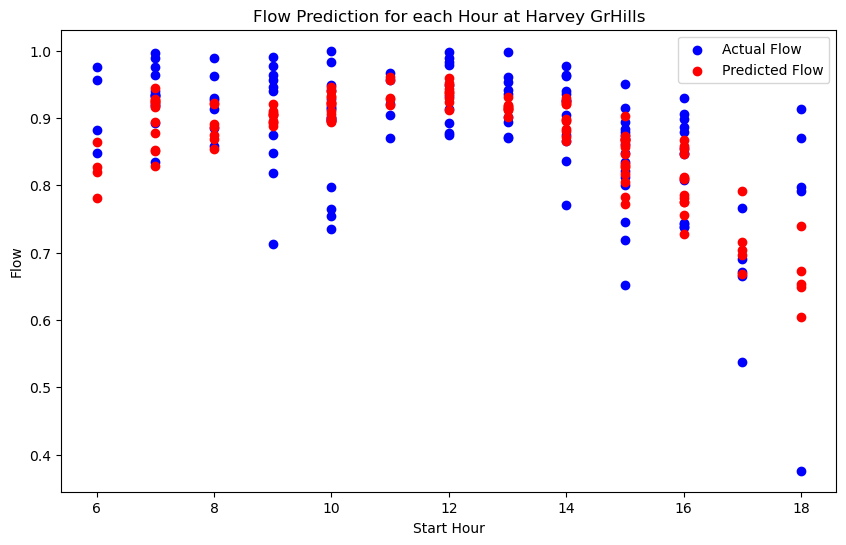

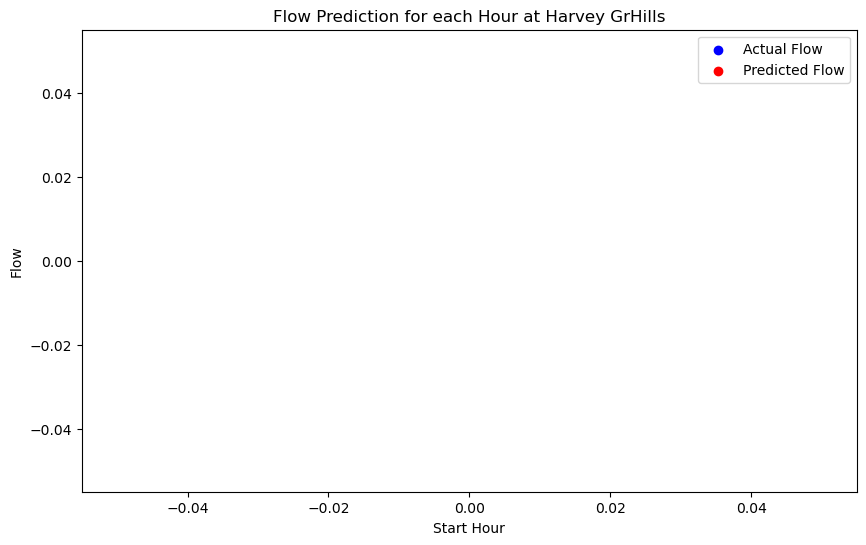

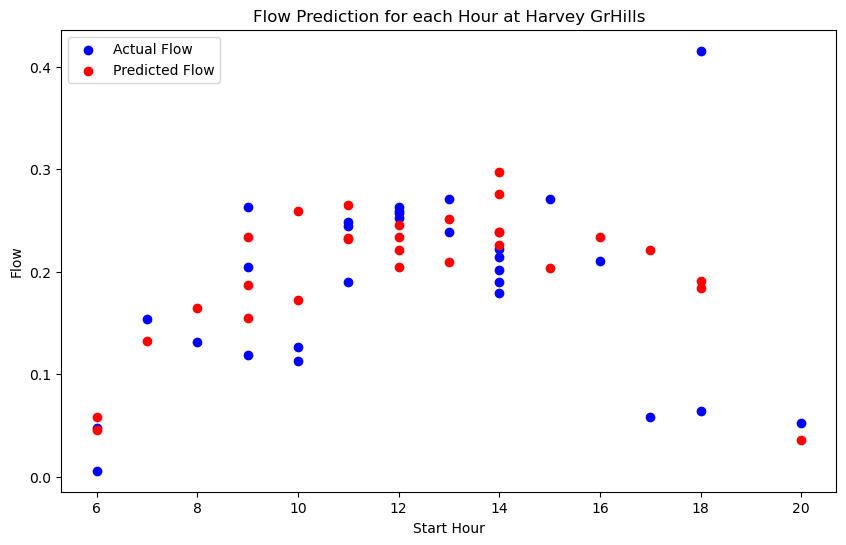

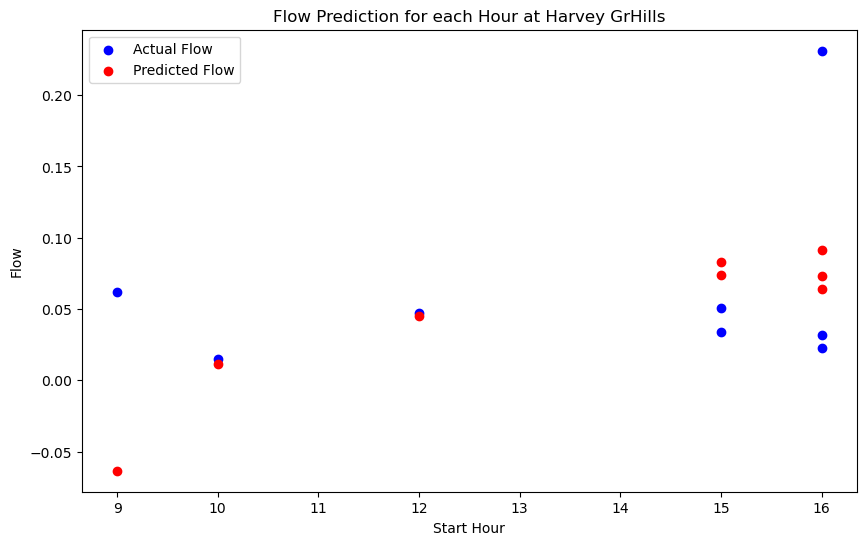

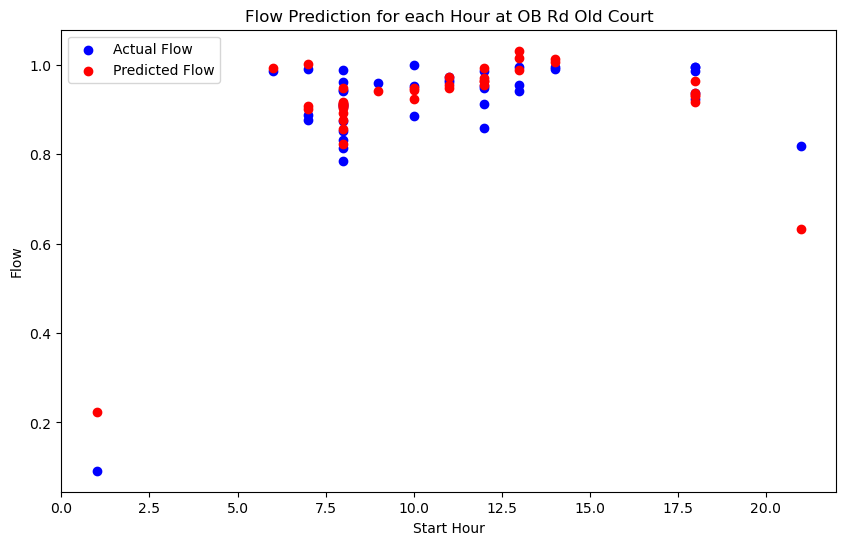

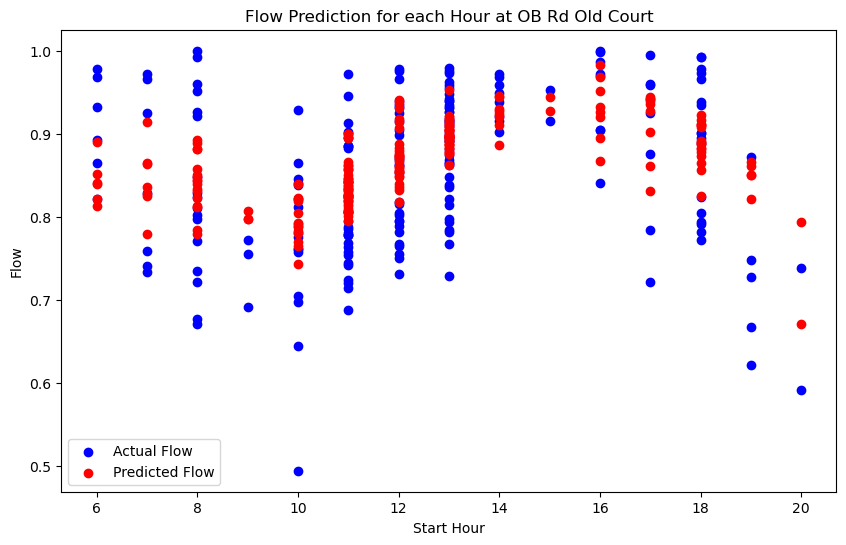

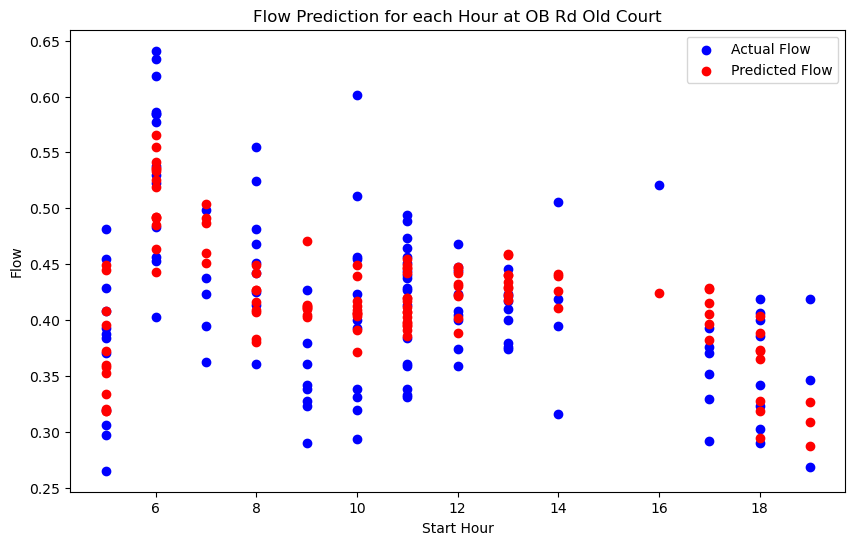

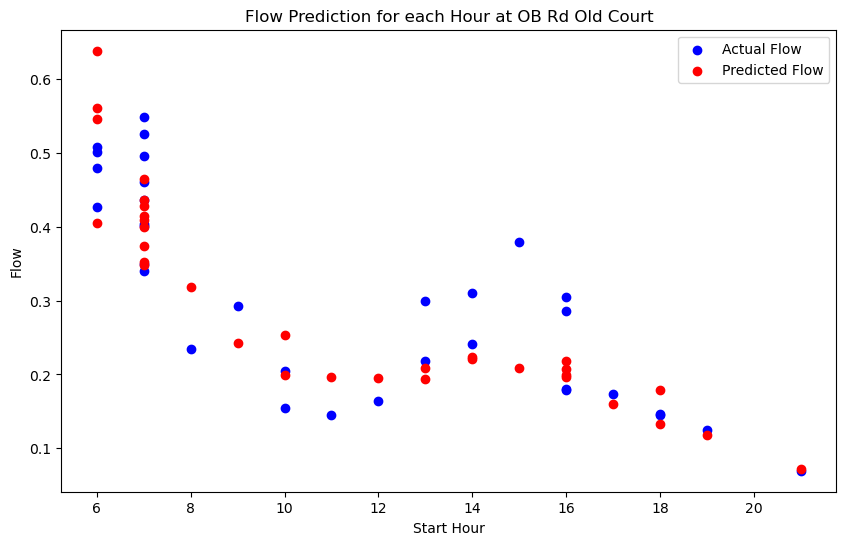

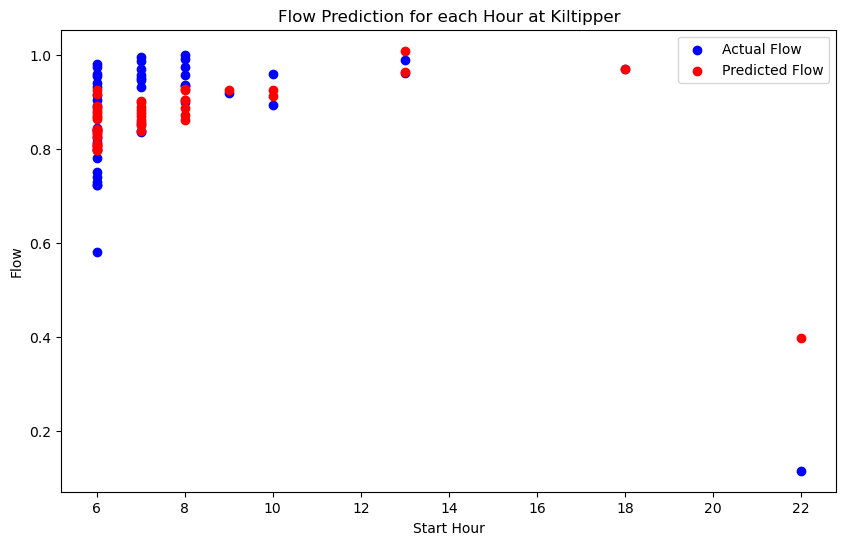

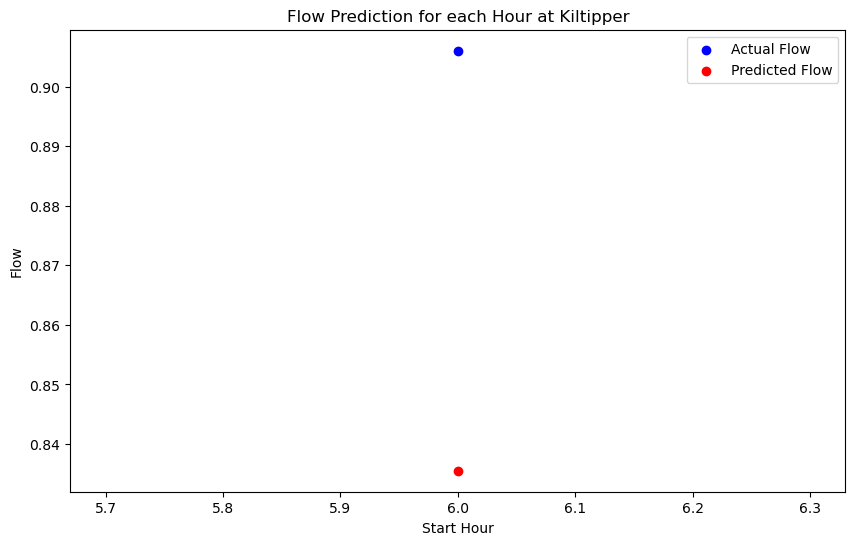

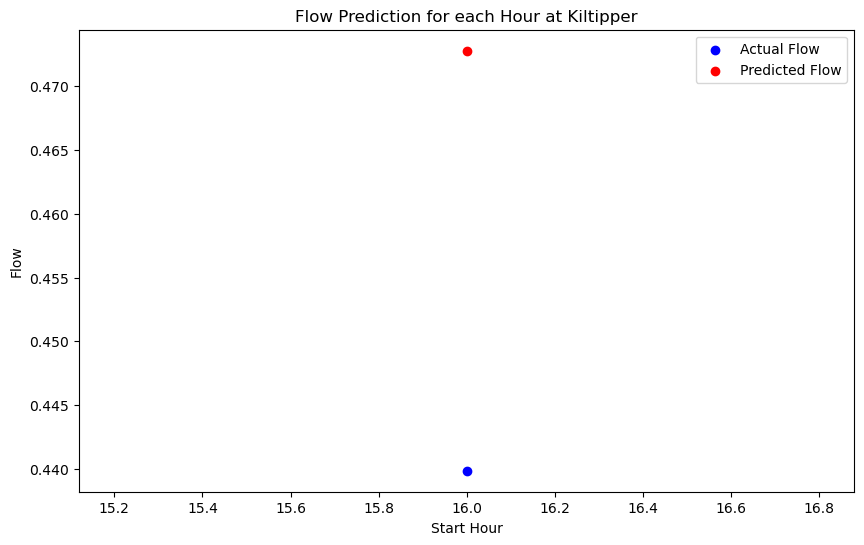

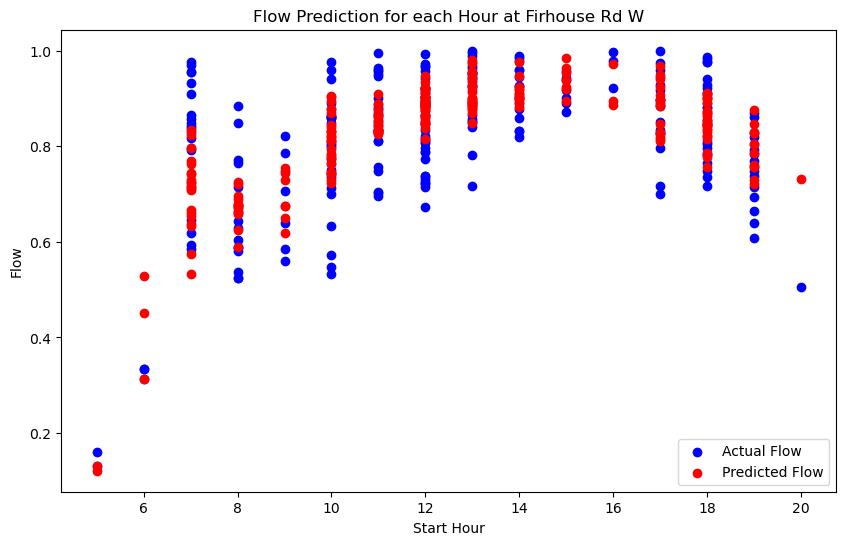

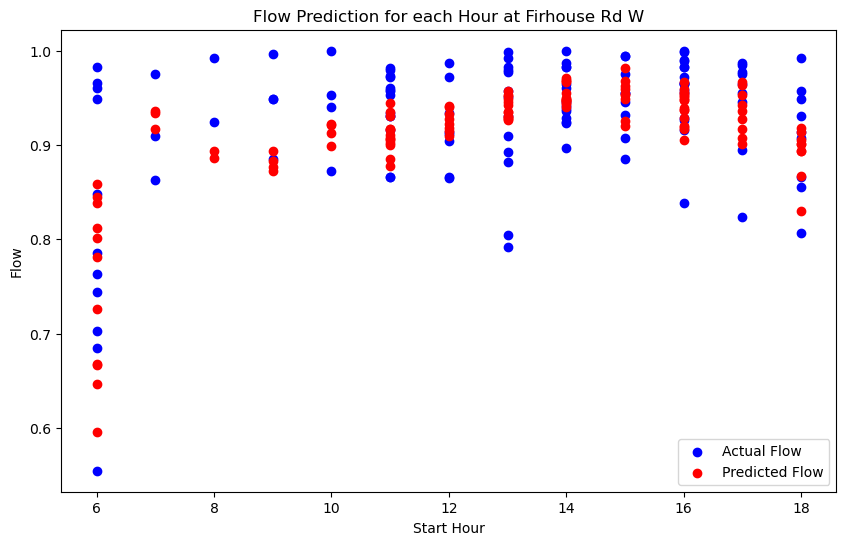

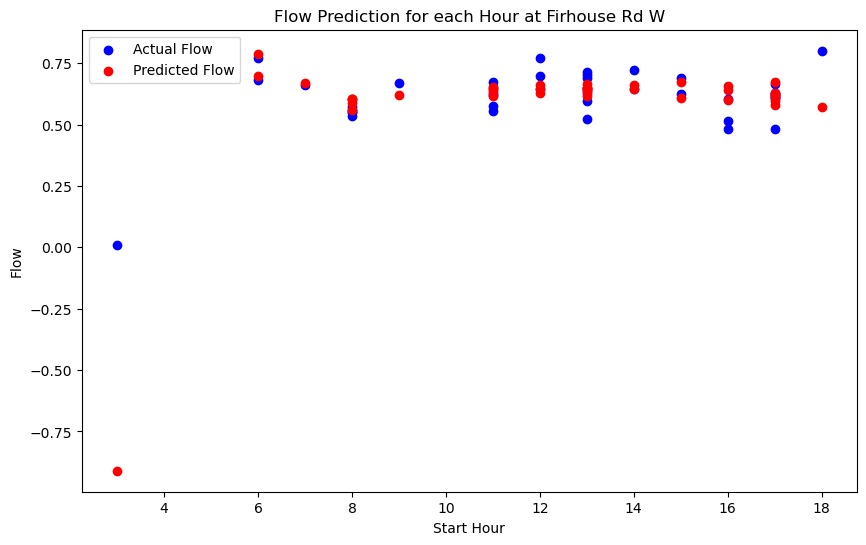

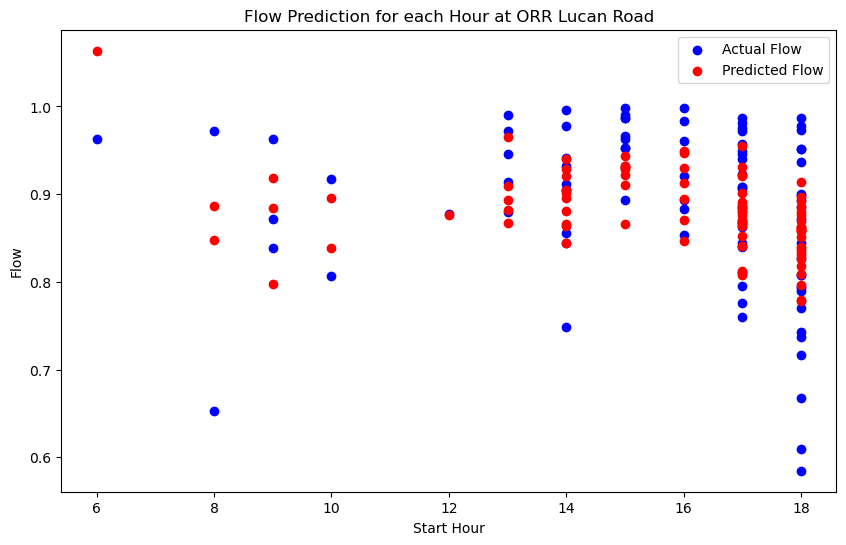

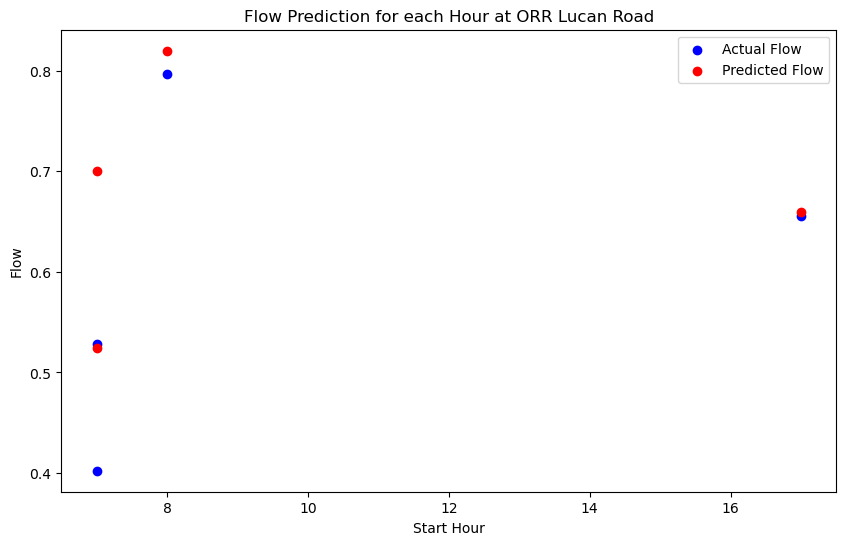

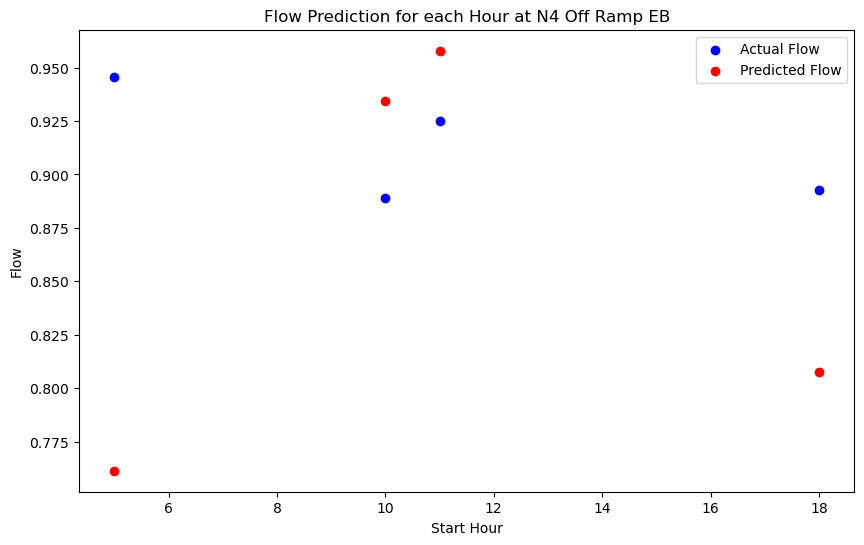

In [26]:
# Scatter Plot

for site in sites_columns:
    # Create a mask for the current site in the test data
    site_mask = X_test[site] == 1

    # Apply mask to y_test and predictions to filter the data for the current site
    y_test_site = y_test[site_mask]
    predictions_site = predictions[site_mask]
    
    # Since 'start_hour' is now part of X_test after normalization, we extract it for plotting
    start_hour_test_site = X_test.loc[site_mask, 'start_hour']

    # Convert start_hour_test_site to its original values (normalised)
    start_hour_test_site_values = start_hour_test_site.values
    
    # Sort by start_hour for plotting
    sorted_indices = np.argsort(start_hour_test_site_values)
    start_hour_test_site_sorted = start_hour_test_site.iloc[sorted_indices]
    y_test_site_sorted = y_test_site.iloc[sorted_indices]
    predictions_site_sorted = predictions_site[sorted_indices]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(start_hour_test_site_sorted.reset_index(drop=True), y_test_site_sorted['flow'], label='Actual Flow', color='blue')
    plt.scatter(start_hour_test_site_sorted.reset_index(drop=True), predictions_site_sorted[:, 0], label='Predicted Flow', color='red')
    plt.title(f'Flow Prediction for each Hour at {get_location_from_scn(site, scn_to_locn_mapping)}')
    plt.xlabel('Start Hour')
    plt.ylabel('Flow')
    plt.legend()
    plt.show()

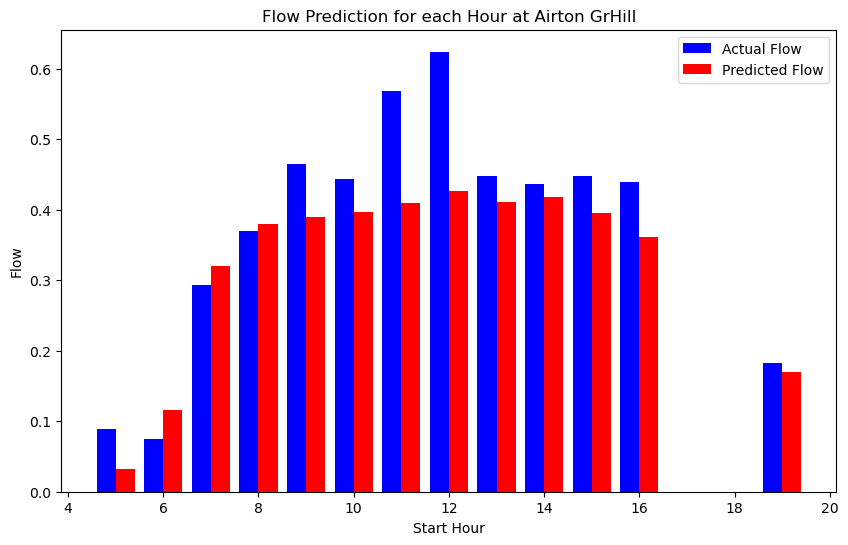

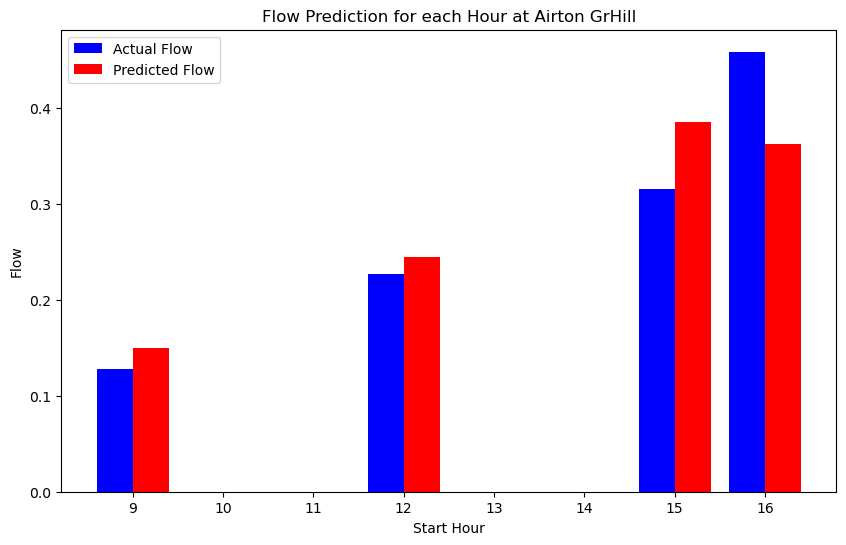

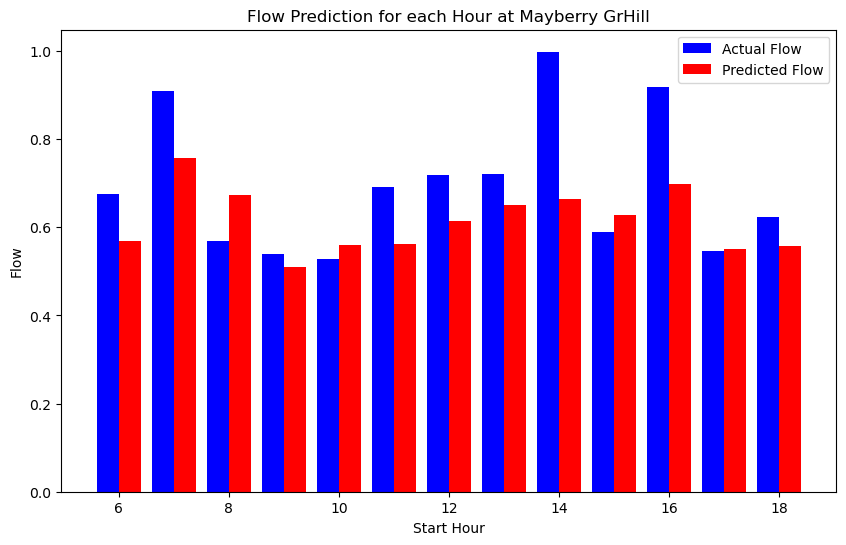

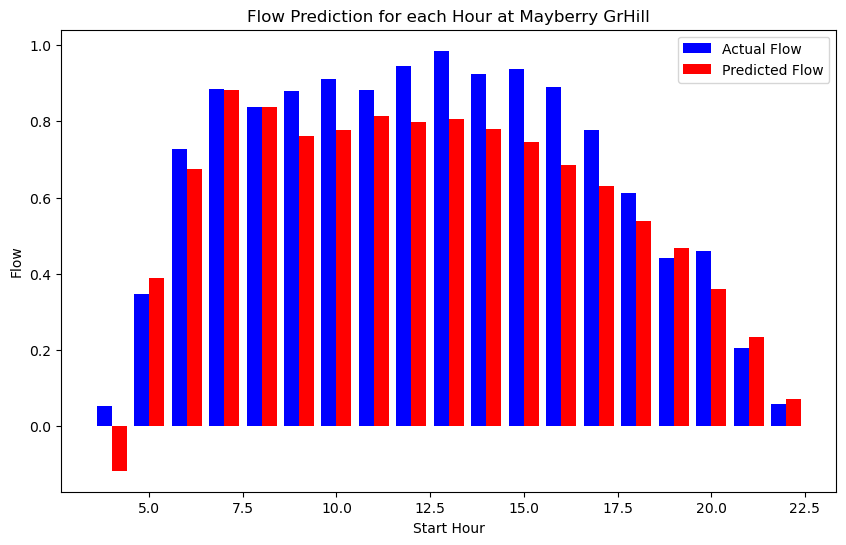

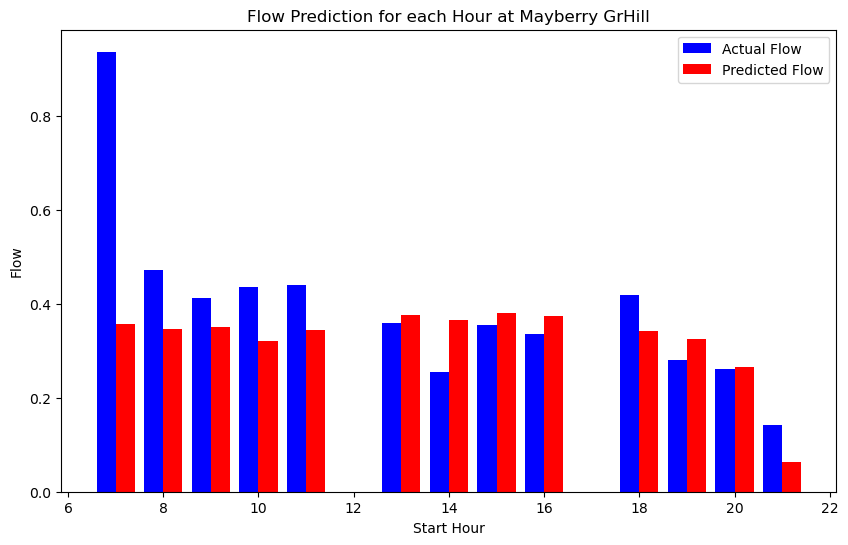

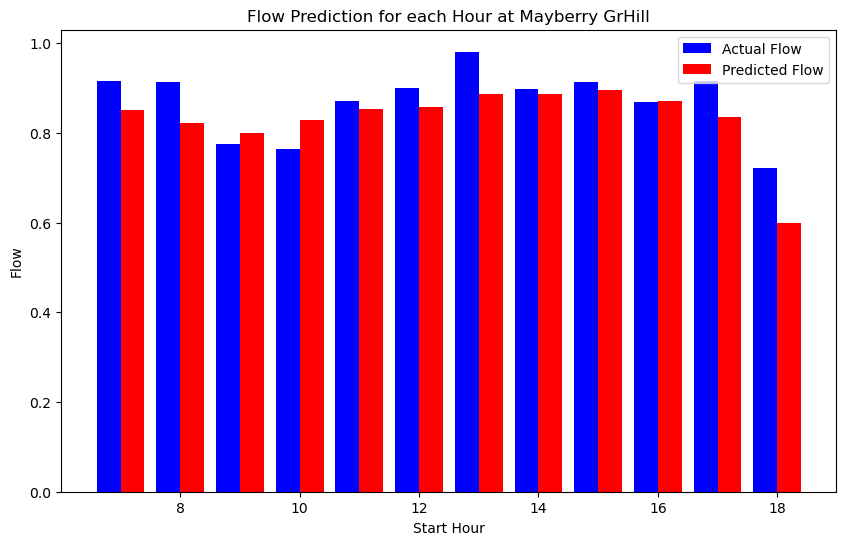

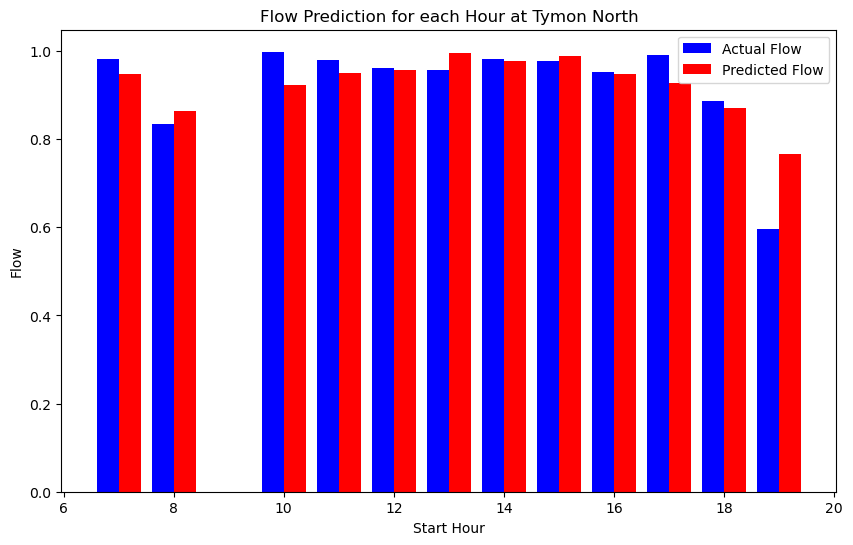

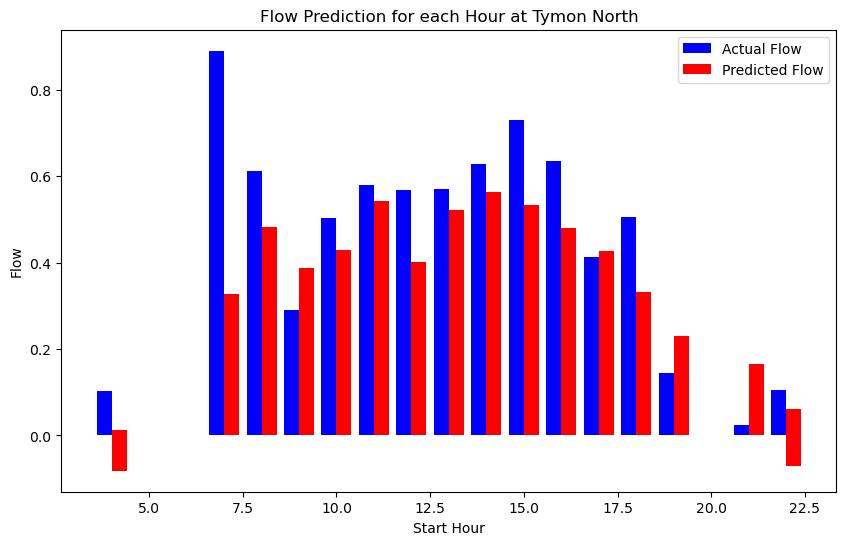

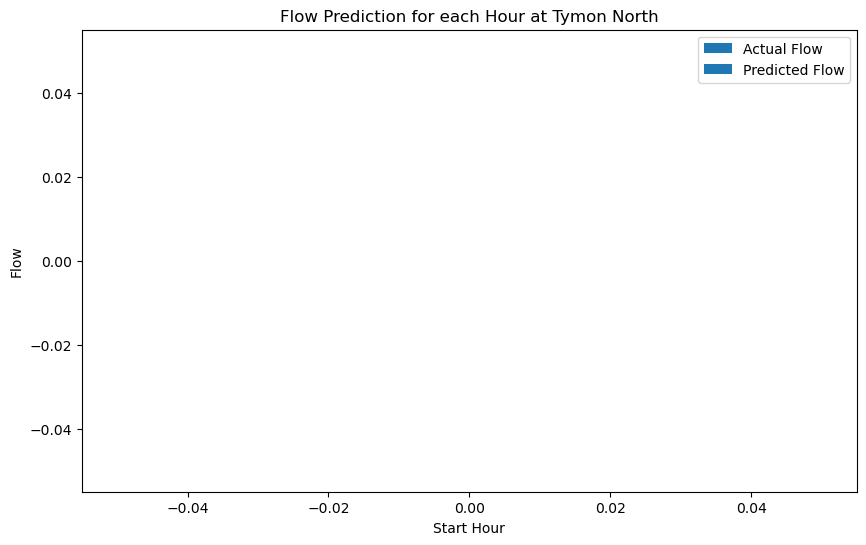

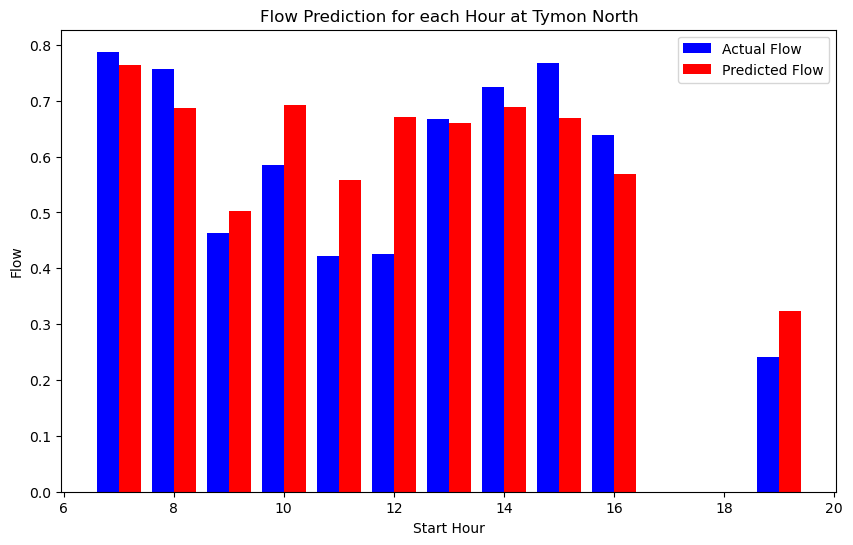

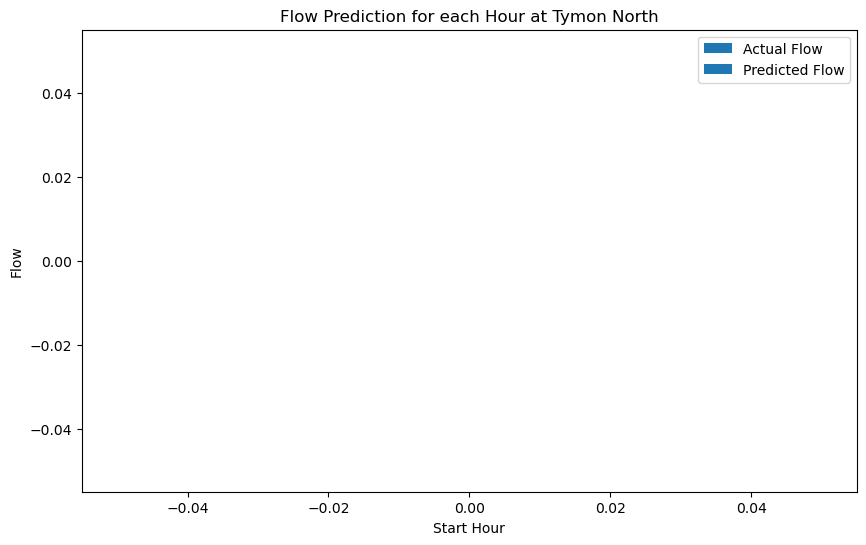

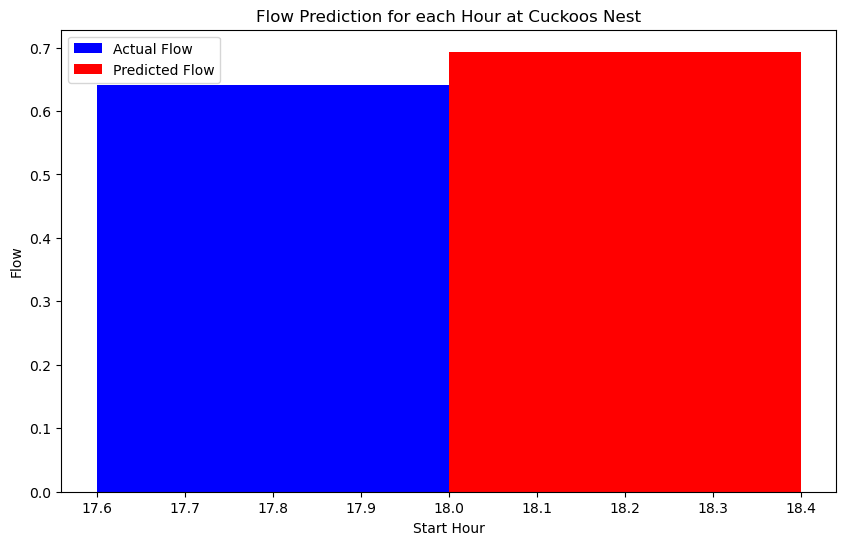

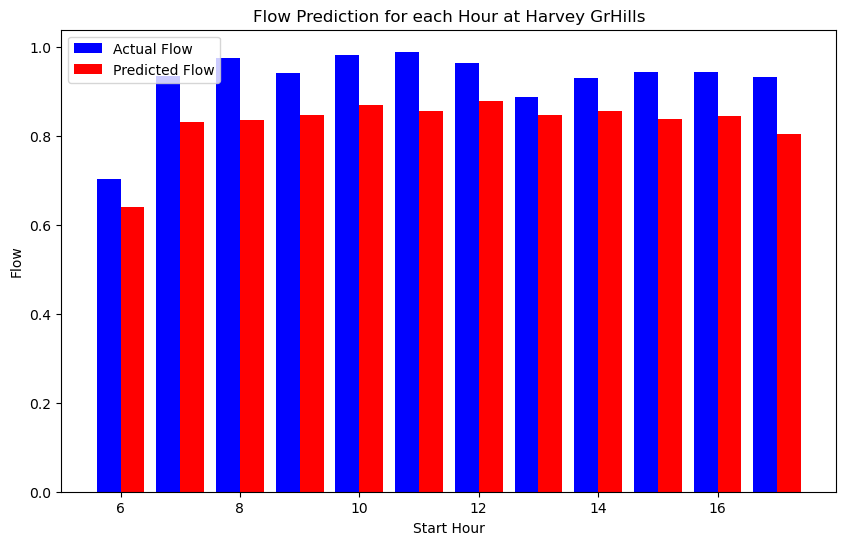

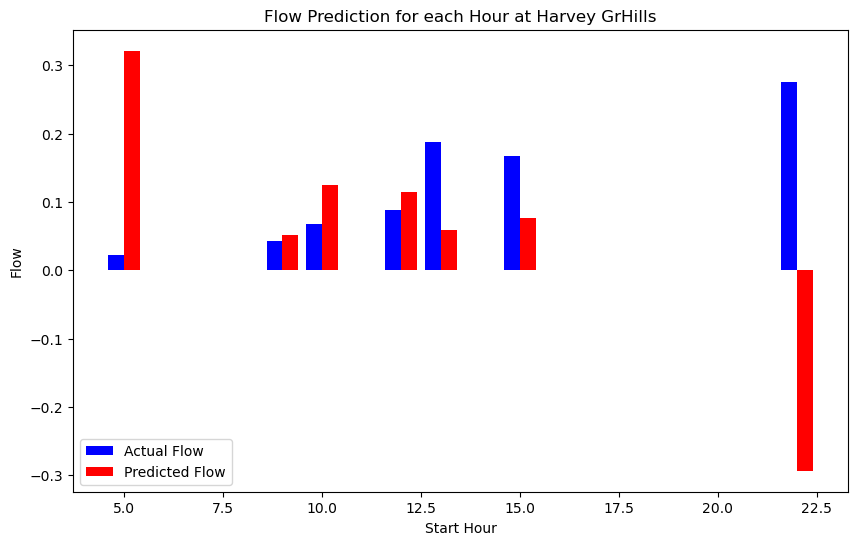

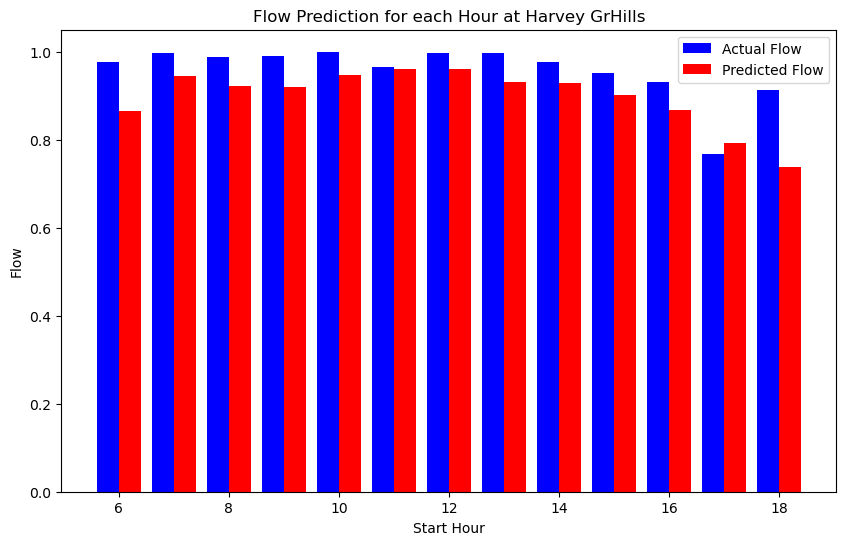

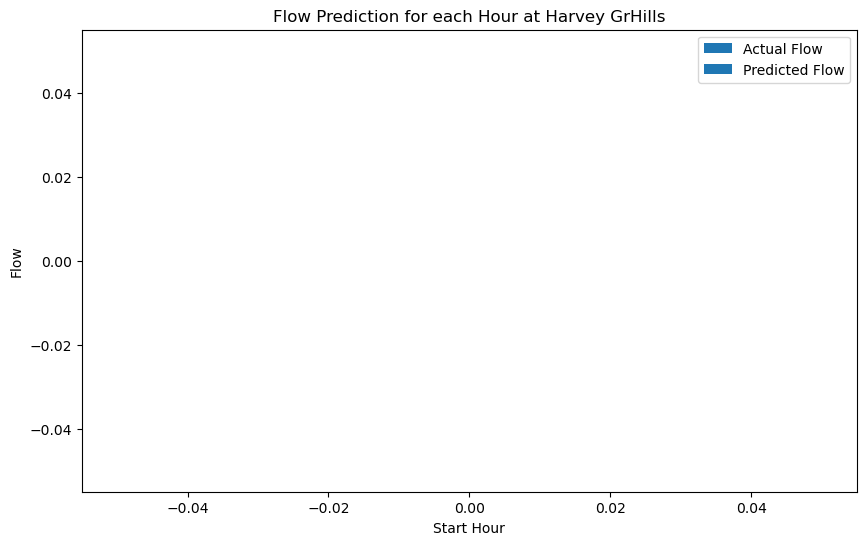

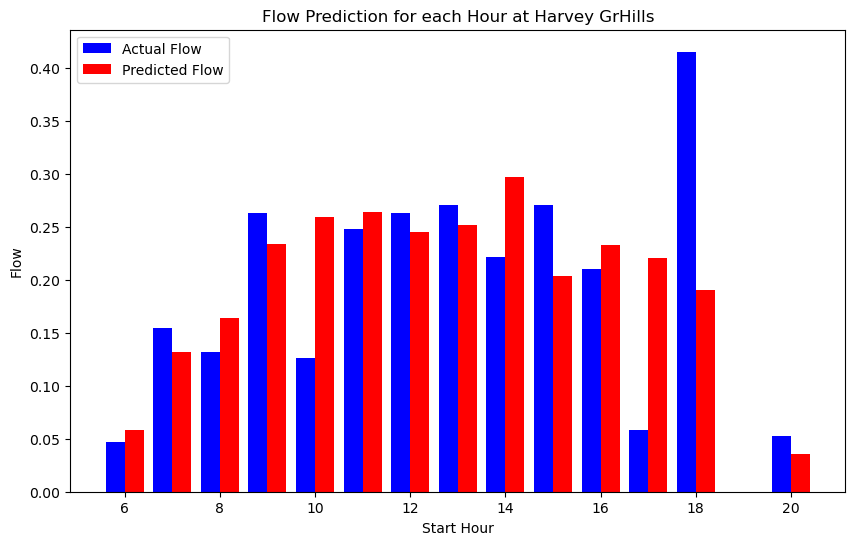

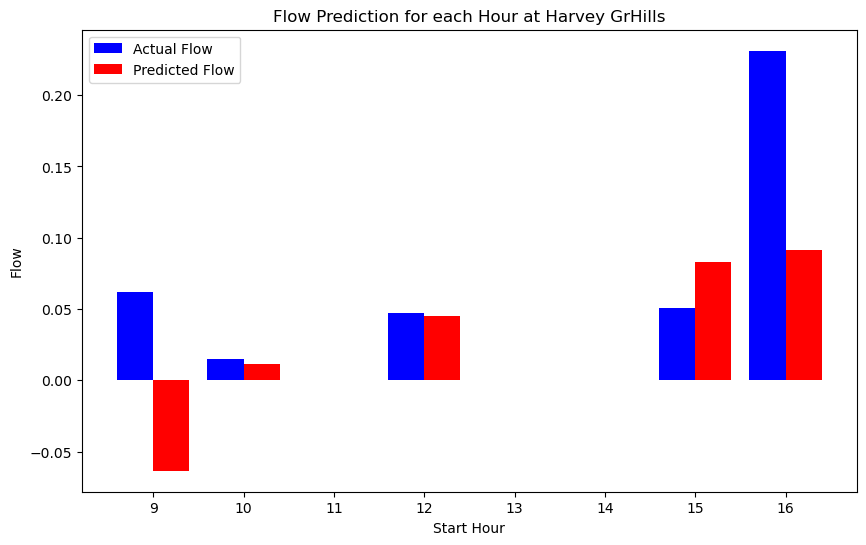

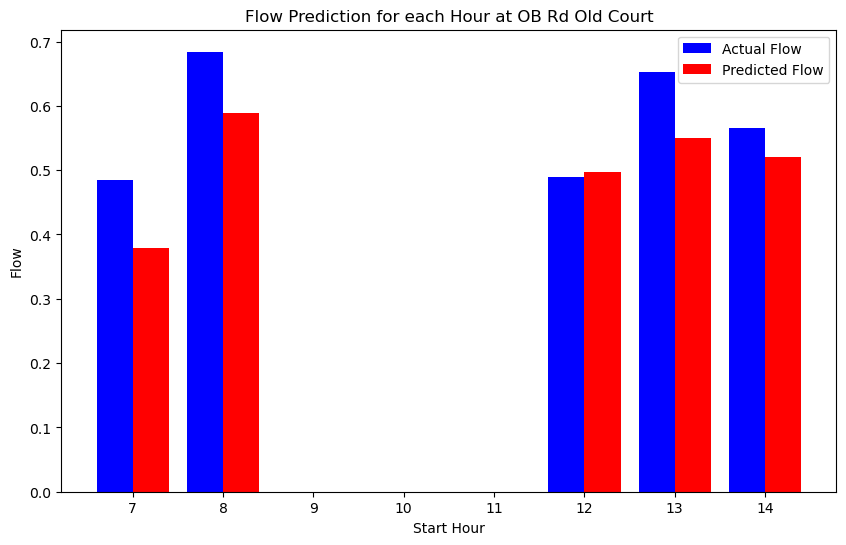

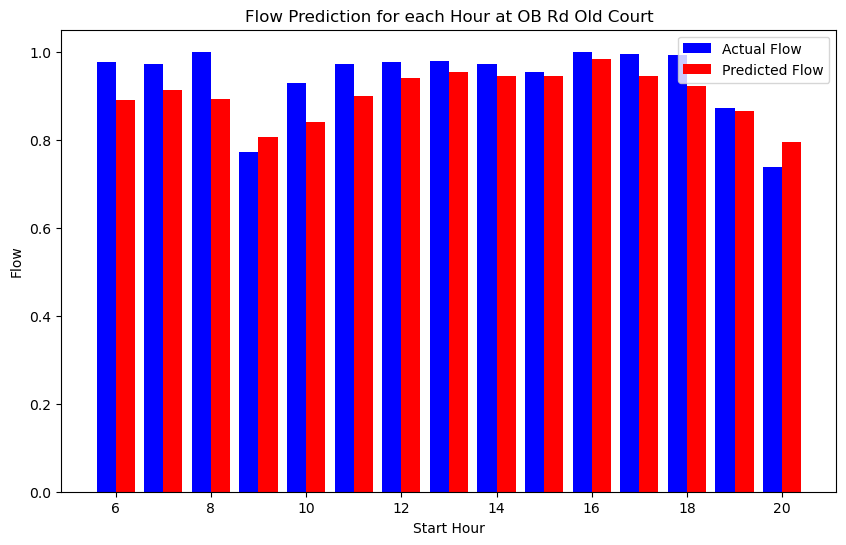

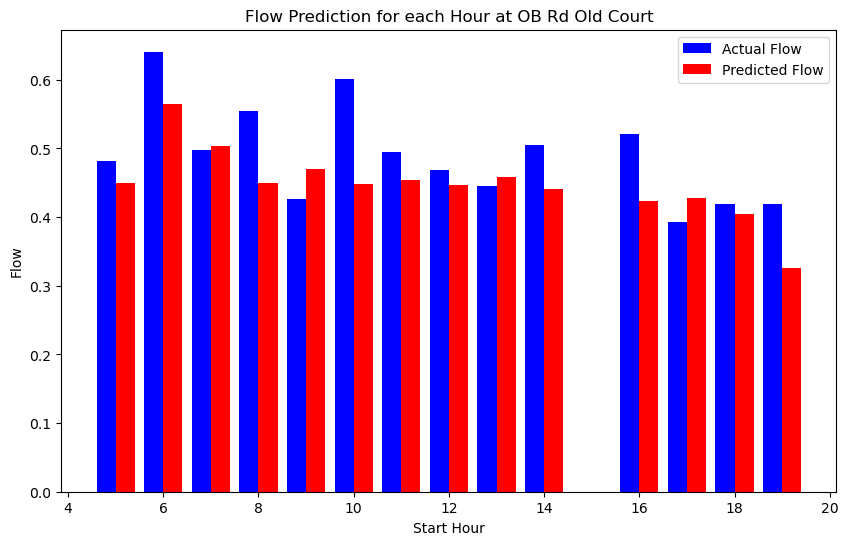

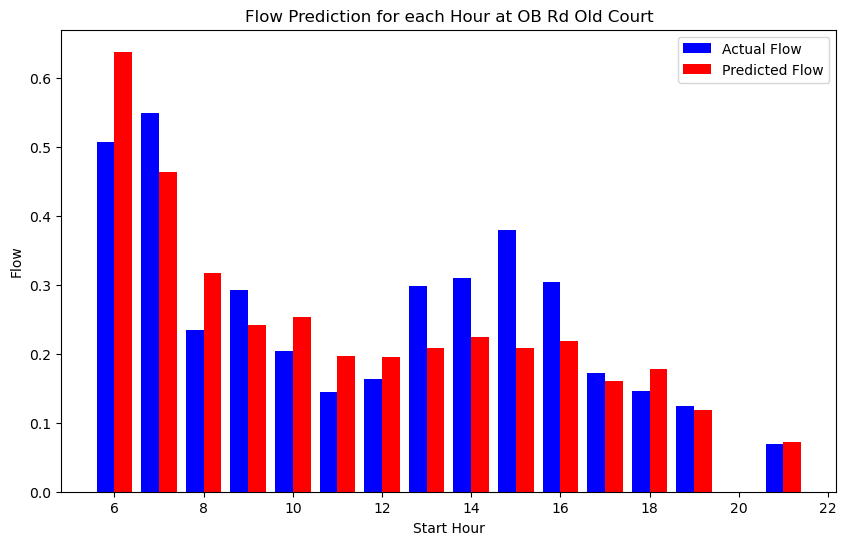

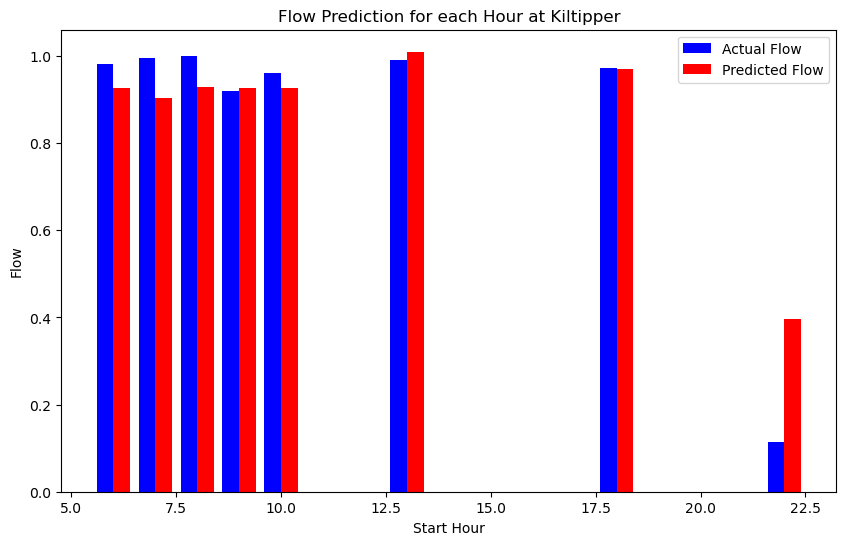

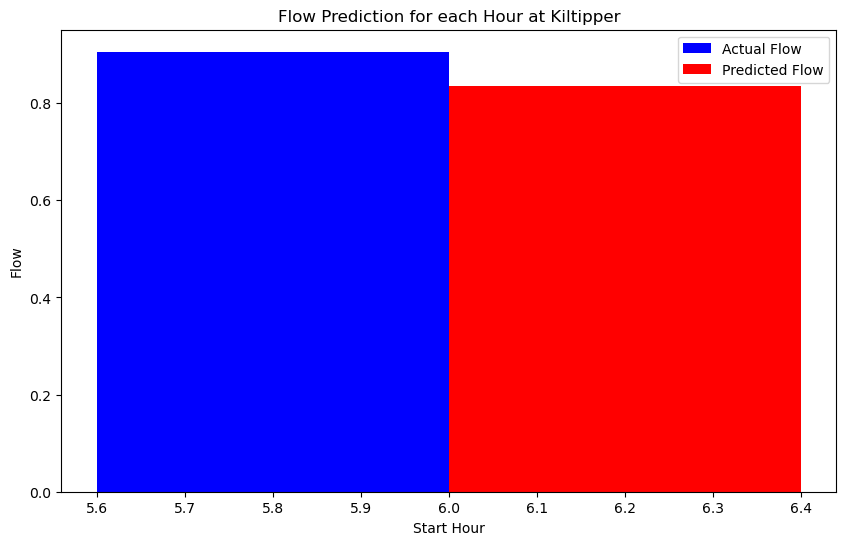

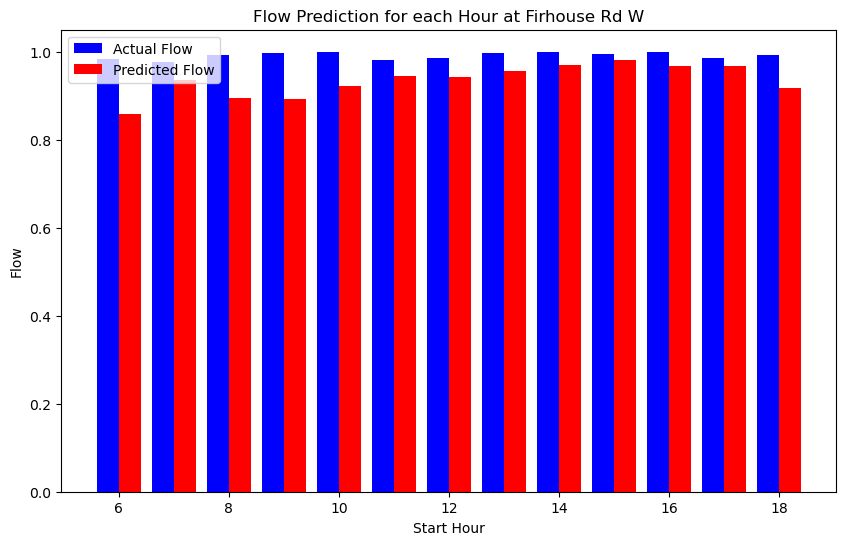

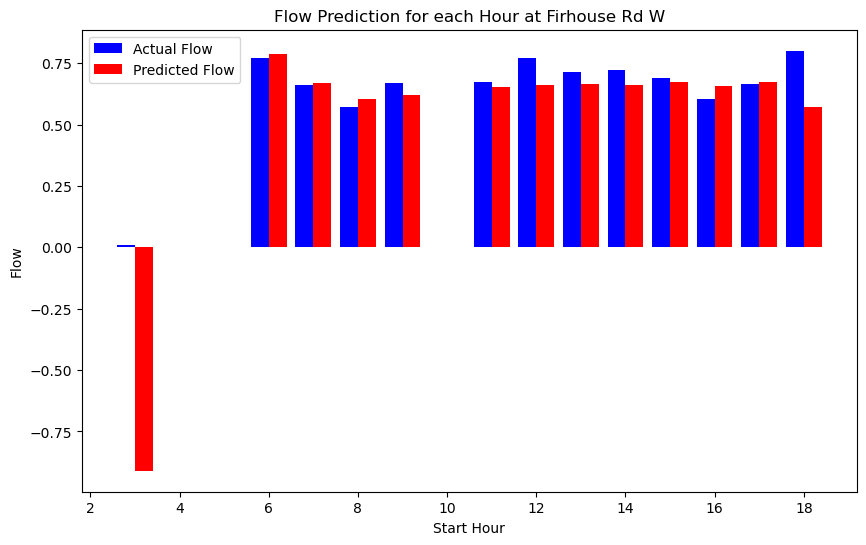

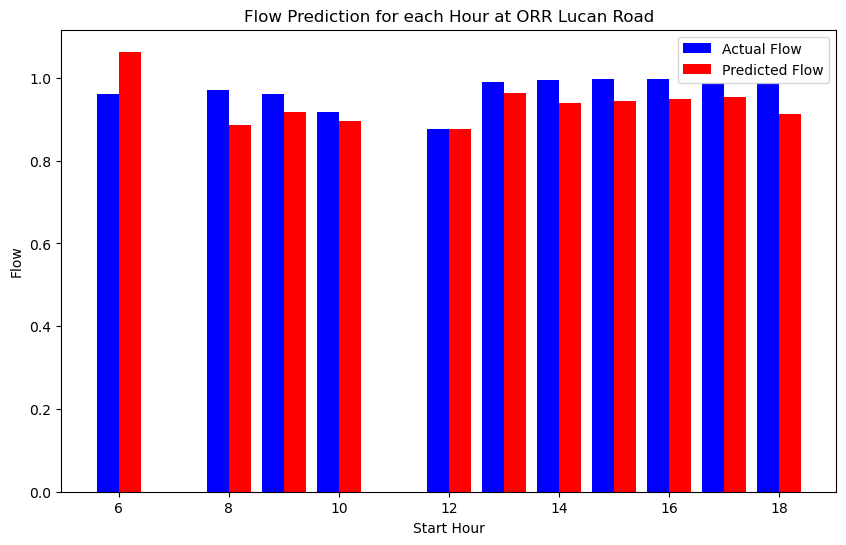

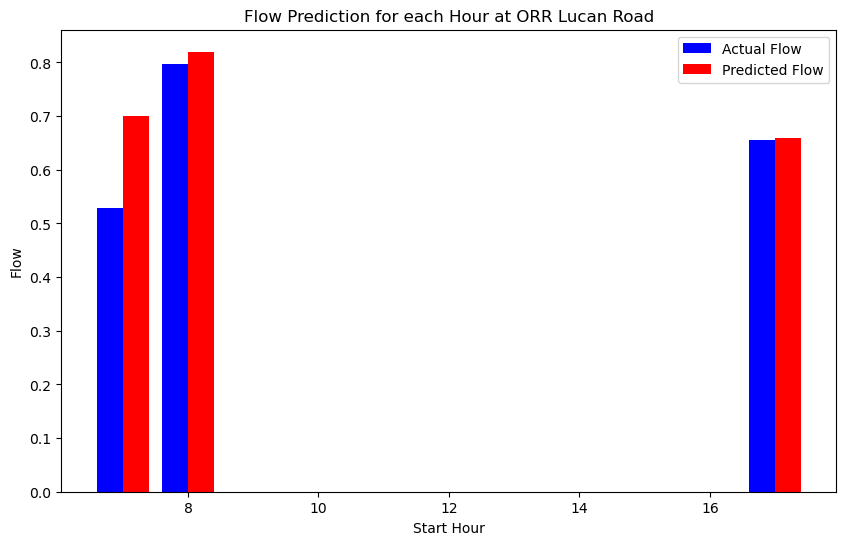

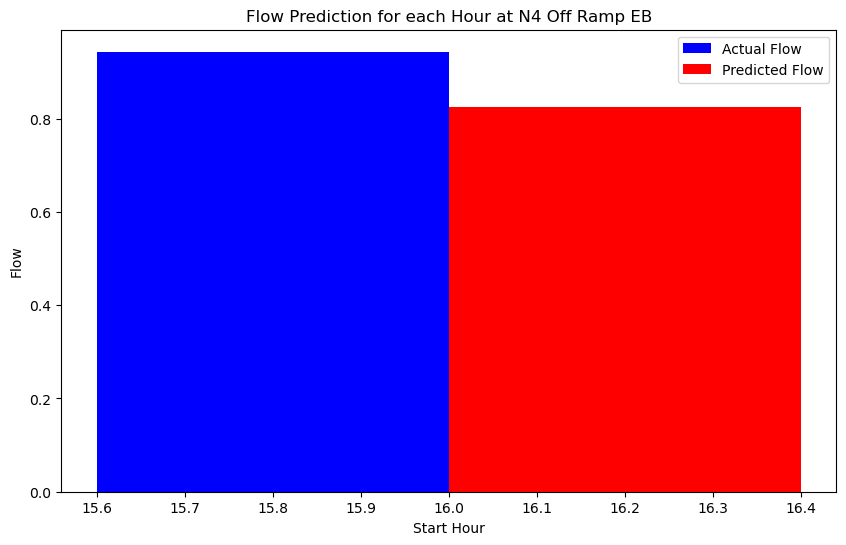

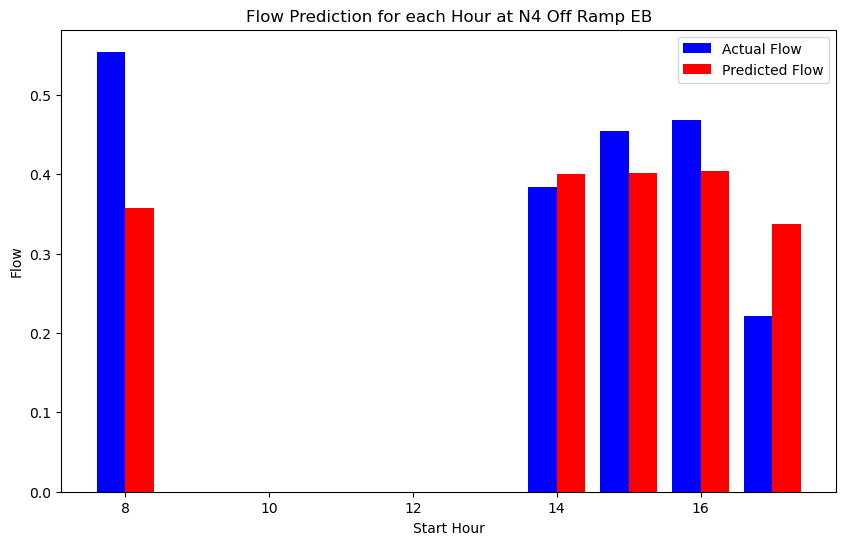

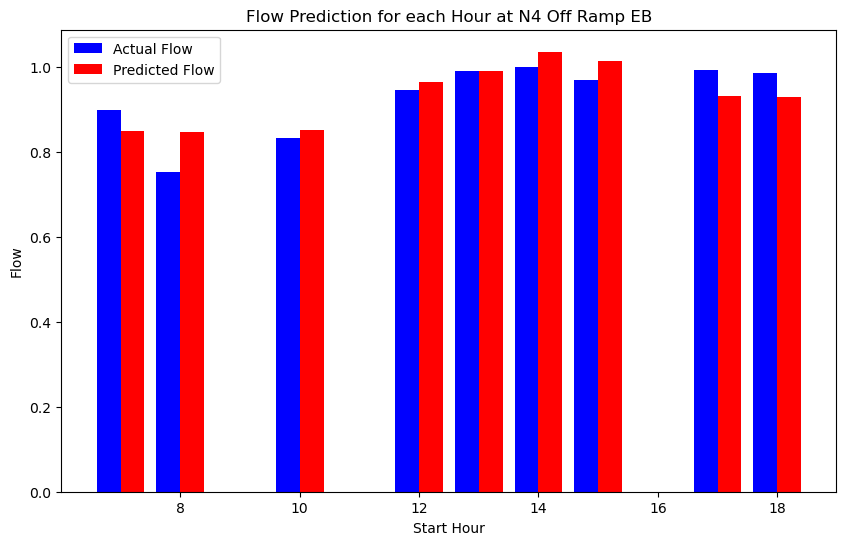

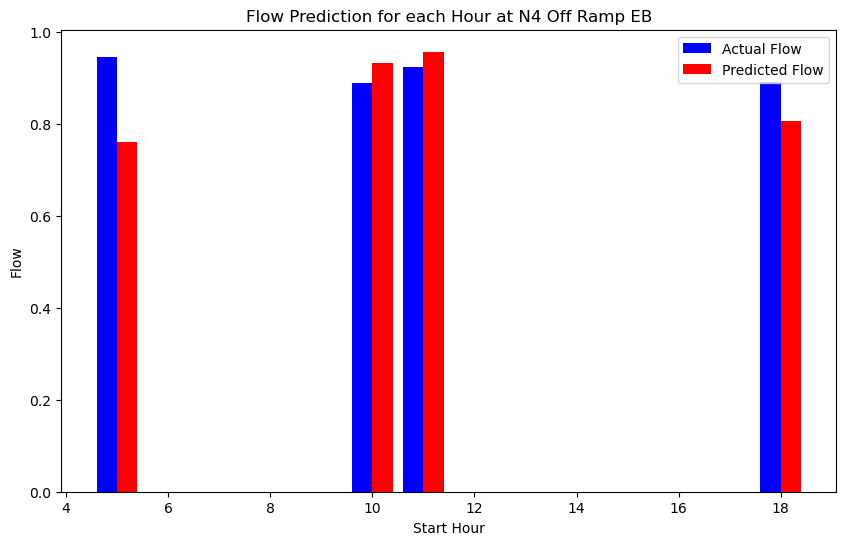

In [27]:
# Bar Chart
for site in sites_columns:
    # Create a mask for the current site in the test data
    site_mask = X_test[site] == 1

    # Apply mask to y_test and predictions to filter the data for the current site
    y_test_site = y_test[site_mask]
    predictions_site = predictions[site_mask]
    
    # Since 'start_hour' is now part of X_test after normalization, we extract it for plotting
    start_hour_test_site = X_test.loc[site_mask, 'start_hour']

    # Convert start_hour_test_site to its original values (normalised)
    start_hour_test_site_values = start_hour_test_site.values
    
    # Sort by start_hour for plotting
    sorted_indices = np.argsort(start_hour_test_site_values)
    start_hour_test_site_sorted = start_hour_test_site.iloc[sorted_indices]
    y_test_site_sorted = y_test_site.iloc[sorted_indices]
    predictions_site_sorted = predictions_site[sorted_indices]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(start_hour_test_site_sorted.reset_index(drop=True) - 0.2, y_test_site_sorted['flow'], width=0.4, label='Actual Flow', color='blue')
    plt.bar(start_hour_test_site_sorted.reset_index(drop=True) + 0.2, predictions_site_sorted[:, 0], width=0.4, label='Predicted Flow', color='red')
    plt.title(f'Flow Prediction for each Hour at {get_location_from_scn(site, scn_to_locn_mapping)}')
    plt.xlabel('Start Hour')
    plt.ylabel('Flow')
    plt.legend()
    plt.show()

# Weekends (Sat & Sun)

In [28]:
sites_columns = [col for col in df_weekend.columns if col.startswith('site_')]
# Now, `sites_columns` is a list of column names that start with 'site_'
for index, site in enumerate(sites_columns):
    print(f"Index: {index}, Site Column: {site}")

Index: 0, Site Column: site_N01111A
Index: 1, Site Column: site_N01111C
Index: 2, Site Column: site_N01111D
Index: 3, Site Column: site_N01121E
Index: 4, Site Column: site_N01121G
Index: 5, Site Column: site_N01121H
Index: 6, Site Column: site_N01121J
Index: 7, Site Column: site_N01121V
Index: 8, Site Column: site_N01121Y
Index: 9, Site Column: site_N01131A
Index: 10, Site Column: site_N01131B
Index: 11, Site Column: site_N01131C
Index: 12, Site Column: site_N01131F
Index: 13, Site Column: site_N01151A
Index: 14, Site Column: site_N01151B
Index: 15, Site Column: site_N01151C
Index: 16, Site Column: site_N01151J
Index: 17, Site Column: site_N01151L
Index: 18, Site Column: site_N02111A
Index: 19, Site Column: site_N02111B
Index: 20, Site Column: site_N02111C
Index: 21, Site Column: site_N02111D
Index: 22, Site Column: site_N02111K
Index: 23, Site Column: site_N02111M
Index: 24, Site Column: site_N02121E
Index: 25, Site Column: site_N02121G
Index: 26, Site Column: site_N02121H
Index: 27, 

### ML Model

In [29]:
# Prediction Model

# Normalize all features except 'start_hour'
columns_to_normalize = df_weekend.columns.difference(['flow'])
X_to_normalize = df_weekend[columns_to_normalize]
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_to_normalize)
X_normalized_df = pd.DataFrame(X_normalized, columns=columns_to_normalize, index=df_weekend.index)

# Add 'start_hour' back to the features without normalization
X_normalized_df['start_hour'] = df_weekend['start_hour']

X_normalized_df = X_normalized_df.drop(columns=['cong', 'dsat'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized_df, df_weekend[['flow']], test_size=0.2, random_state=23)


# Reshape input to be [samples, time steps, features]
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Function to create and evaluate the model, now including 'start_hour' in training
def train_and_evaluate_model(neurons, lr, activation):
    model = Sequential([
        LSTM(neurons, activation=activation, input_shape=(1, X_train.shape[1])),
        Dense(1)  # Output features: 'flow'
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
    
    # Fit model
    model.fit(X_train_reshaped, y_train, epochs=100, validation_data=(X_test_reshaped, y_test), batch_size=32, verbose=0)
    
    # Predict on test set
    predictions = model.predict(X_test_reshaped)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = sqrt(mse)
    r2 = r2_score(y_test, predictions)
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

    print(f"MAE:{mae} || RMSE:{rmse} || MSE:{mse} || R2:{r2} || MAPE:{mape} || Model: {model}")
    print("==========================================================================")

    return mae, mse, rmse, r2, mape, model

# Parameters for model training
neurons = [10, 50, 100]
learning_rates = [0.001, 0.01, 0.1]
activation_functions = ['relu', 'tanh', 'sigmoid']

# Store results
results = []

# Iterate over parameter combinations
for neuron in neurons:
    for lr in learning_rates:
        for activation in activation_functions:
            mae, mse, rmse, r2, mape, trained_model = train_and_evaluate_model(neuron, lr, activation)
            results.append({
                'neurons': neuron,
                'learning_rate': lr,
                'activation': activation,
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse,
                'R2': r2,
                'MAPE': mape,
                'model': trained_model
            })

# Find the best model configuration
best_result = sorted(results, key=lambda x: x['MAE'])[0]
best_model = best_result['model']

# Predict on reshaped test set with the best model
predictions = best_model.predict(X_test_reshaped)

print("Best configuration:", best_result)


20/20 [==============================] - 0s 377us/step


MAE:0.06599065111573658 || RMSE:0.09011150588939672 || MSE:0.008120083493654779 || R2:0.9169392820398633 || MAPE:inf || Model: <keras.src.engine.sequential.Sequential object at 0x2ed4f2690>
20/20 [==============================] - 0s 396us/step


MAE:0.066235427111733 || RMSE:0.08588453277674599 || MSE:0.007376152970279956 || R2:0.9245489825352164 || MAPE:inf || Model: <keras.src.engine.sequential.Sequential object at 0x2ed576f50>
20/20 [==============================] - 0s 369us/step


MAE:0.06586320292260638 || RMSE:0.08685809551214389 || MSE:0.007544328755996711 || R2:0.9228287044720587 || MAPE:inf || Model: <keras.src.engine.sequential.Sequential object at 0x2e5c13d50>
20/20 [==============================] - 0s 377us/step


MAE:0.0639372844164981 || RMSE:0.08229234488036313 || MSE:0.0067720300259086295 || R2:0.9307285846950815 || MAPE:inf || Model: <keras.src.engine.sequential.Sequential object at 0x2ea963350>
20/20 [==============================] - 0s 408us/step


MAE:0.06814081840561984 || RMSE:0.09048165361825121 || MSE:0.008186929641493191 || R2:0.9162555096332536 || MAPE:inf || Model: <keras.src.engine.sequential.Sequential object at 0x2ea0b8050>
20/20 [==============================] - 0s 375us/step


MAE:0.06381466866845503 || RMSE:0.08437436860181548 || MSE:0.007119034076955025 || R2:0.9271790638511749 || MAPE:inf || Model: <keras.src.engine.sequential.Sequential object at 0x2ea7a6950>
20/20 [==============================] - 0s 372us/step


MAE:0.07788457957716113 || RMSE:0.09787128437163568 || MSE:0.009578788304553578 || R2:0.9020181215641321 || MAPE:inf || Model: <keras.src.engine.sequential.Sequential object at 0x2edb1fc10>
20/20 [==============================] - 0s 386us/step


MAE:0.07371728060718039 || RMSE:0.09642391535580581 || MSE:0.009297571452543604 || R2:0.9048947020387899 || MAPE:inf || Model: <keras.src.engine.sequential.Sequential object at 0x2ea4cdf10>
20/20 [==============================] - 0s 371us/step


MAE:0.068167688322903 || RMSE:0.08817187175225638 || MSE:0.007774278968296347 || R2:0.9204765328787963 || MAPE:inf || Model: <keras.src.engine.sequential.Sequential object at 0x2ecc83090>
20/20 [==============================] - 0s 389us/step


MAE:0.06295319025823146 || RMSE:0.08479491639325712 || MSE:0.007190177846139465 || R2:0.9264513308726325 || MAPE:inf || Model: <keras.src.engine.sequential.Sequential object at 0x2e82917d0>
20/20 [==============================] - 0s 405us/step


MAE:0.07085626948306678 || RMSE:0.09551693493476607 || MSE:0.009123484859332336 || R2:0.9066754420312617 || MAPE:inf || Model: <keras.src.engine.sequential.Sequential object at 0x2f722b890>
20/20 [==============================] - 0s 379us/step


MAE:0.07105459665922935 || RMSE:0.09095490172455159 || MSE:0.008272794147722837 || R2:0.9153771975395049 || MAPE:inf || Model: <keras.src.engine.sequential.Sequential object at 0x2db40ccd0>
20/20 [==============================] - 0s 384us/step


MAE:0.06606737256603304 || RMSE:0.09166317815756367 || MSE:0.008402138229945257 || R2:0.9140541308072866 || MAPE:inf || Model: <keras.src.engine.sequential.Sequential object at 0x2d83386d0>
20/20 [==============================] - 0s 417us/step


MAE:0.0653558608919165 || RMSE:0.08804955899539871 || MSE:0.0077527248392841985 || R2:0.9206970110835035 || MAPE:inf || Model: <keras.src.engine.sequential.Sequential object at 0x2a796b710>
20/20 [==============================] - 0s 370us/step


MAE:0.06808158375994175 || RMSE:0.09063922266902873 || MSE:0.00821546868604577 || R2:0.9159635823972485 || MAPE:inf || Model: <keras.src.engine.sequential.Sequential object at 0x2a2aebb90>
20/20 [==============================] - 0s 396us/step


MAE:0.08723490811775866 || RMSE:0.11580177671607784 || MSE:0.013410051490600348 || R2:0.8628279492985444 || MAPE:inf || Model: <keras.src.engine.sequential.Sequential object at 0x29c0e8e10>
20/20 [==============================] - 0s 409us/step


MAE:0.06610758629806088 || RMSE:0.08656634162093832 || MSE:0.007493731501632998 || R2:0.923346266179096 || MAPE:inf || Model: <keras.src.engine.sequential.Sequential object at 0x2deaaea90>
20/20 [==============================] - 0s 384us/step


MAE:0.07399834202746056 || RMSE:0.0940159758128001 || MSE:0.008839003708033016 || R2:0.9095854131776806 || MAPE:inf || Model: <keras.src.engine.sequential.Sequential object at 0x2929af8d0>
20/20 [==============================] - 0s 420us/step
MAE:0.07483661536278755 || RMSE:0.0970707403853402 || MSE:0.009422728638958117 || R2:0.9036144632617399 || MAPE:inf || Model: <keras.src.engine.sequential.Sequential object at 0x2a8814290>


20/20 [==============================] - 0s 461us/step


MAE:0.06849929587981186 || RMSE:0.09076913697774573 || MSE:0.008239036227684769 || R2:0.9157225088995905 || MAPE:inf || Model: <keras.src.engine.sequential.Sequential object at 0x2fa55da50>
20/20 [==============================] - 0s 415us/step


MAE:0.06911472198603713 || RMSE:0.08974399319776816 || MSE:0.008053984315081057 || R2:0.9176154136625491 || MAPE:inf || Model: <keras.src.engine.sequential.Sequential object at 0x2fae03a90>
20/20 [==============================] - 0s 419us/step


MAE:0.06484251038094324 || RMSE:0.08798383350381675 || MSE:0.007741154958027347 || R2:0.9208153599458839 || MAPE:inf || Model: <keras.src.engine.sequential.Sequential object at 0x293131d90>
20/20 [==============================] - 0s 467us/step


MAE:0.06515557296763182 || RMSE:0.09285556878784385 || MSE:0.008622156654914 || R2:0.9118035519361897 || MAPE:inf || Model: <keras.src.engine.sequential.Sequential object at 0x2fcac3690>
20/20 [==============================] - 0s 426us/step


MAE:0.062288648425907776 || RMSE:0.083635654616753 || MSE:0.006994922723172798 || R2:0.928448604756784 || MAPE:inf || Model: <keras.src.engine.sequential.Sequential object at 0x295739410>
20/20 [==============================] - 0s 412us/step


MAE:0.07361081777249036 || RMSE:0.0956760288968311 || MSE:0.00915390250546726 || R2:0.9063642984908538 || MAPE:inf || Model: <keras.src.engine.sequential.Sequential object at 0x2fe7fe910>
20/20 [==============================] - 0s 465us/step


MAE:0.07320800237375122 || RMSE:0.0937539678916208 || MSE:0.008789806495423064 || R2:0.9100886537914272 || MAPE:inf || Model: <keras.src.engine.sequential.Sequential object at 0x2fe31fa90>
20/20 [==============================] - 0s 445us/step
MAE:0.07208939607691063 || RMSE:0.09460673314996715 || MSE:0.008950433957309092 || R2:0.9084455878896056 || MAPE:inf || Model: <keras.src.engine.sequential.Sequential object at 0x3009c5890>
20/20 [==============================] - 0s 418us/step
Best configuration: {'neurons': 100, 'learning_rate': 0.01, 'activation': 'sigmoid', 'MAE': 0.062288648425907776, 'MSE': 0.006994922723172798, 'RMSE': 0.083635654616753, 'R2': 0.928448604756784, 'MAPE': inf, 'model': <keras.src.engine.sequential.Sequential object at 0x295739410>}


### Display Results

#### `Flow`

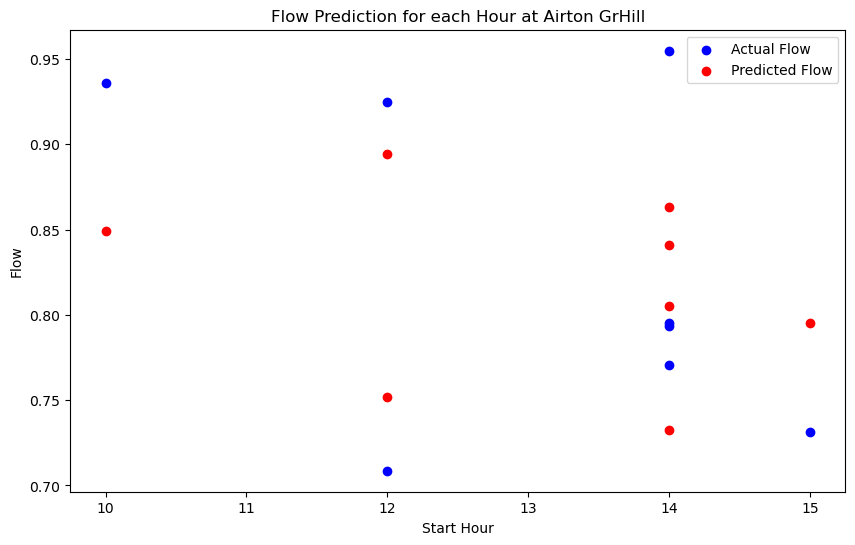

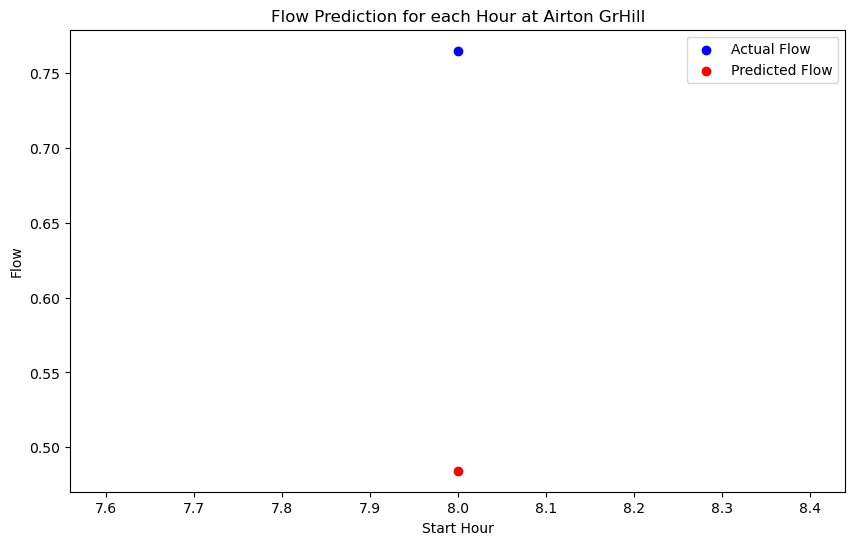

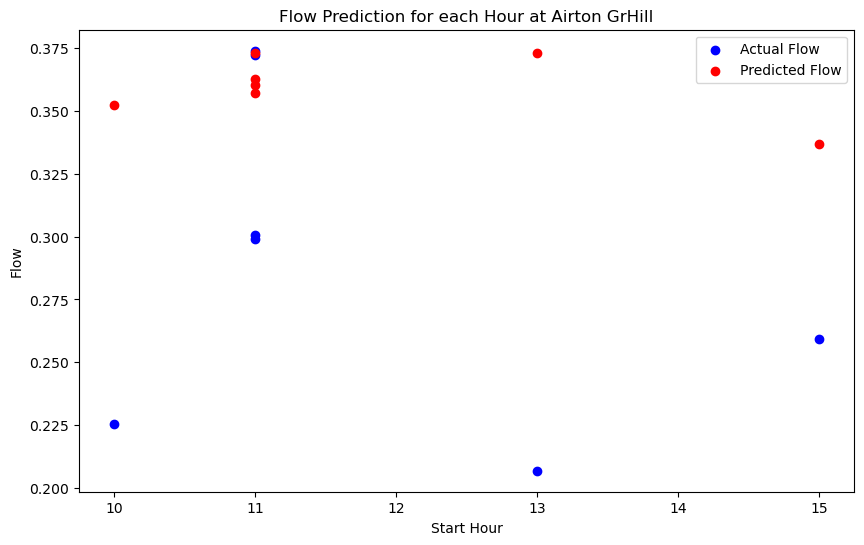

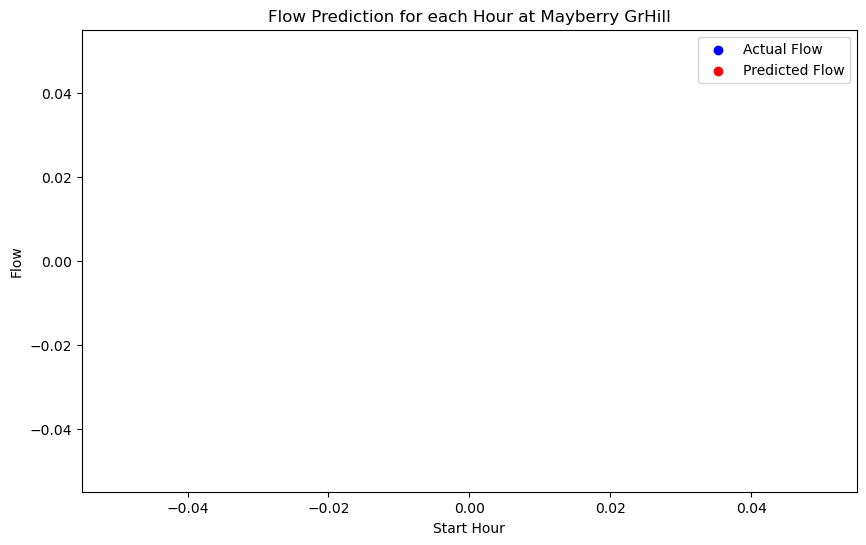

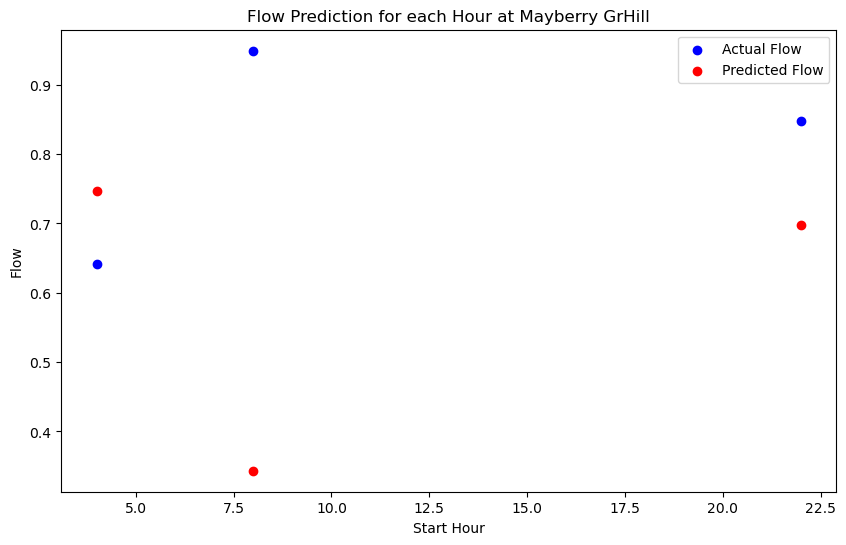

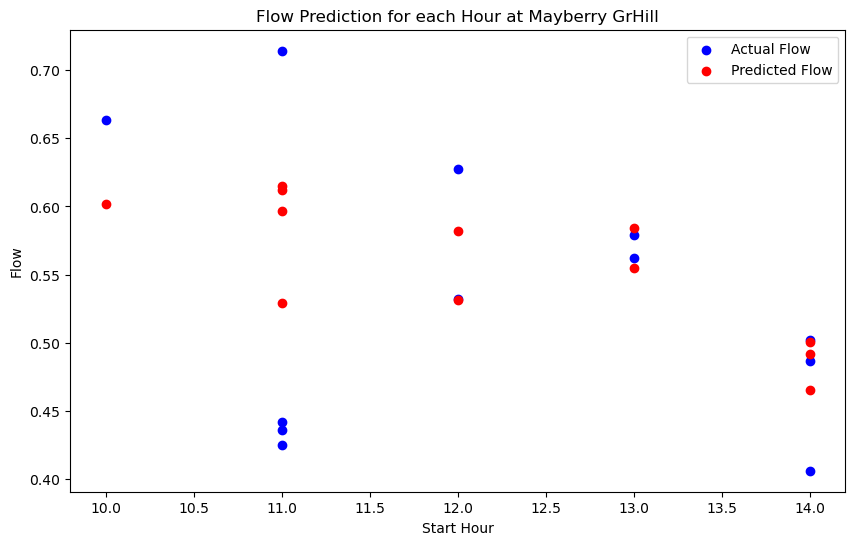

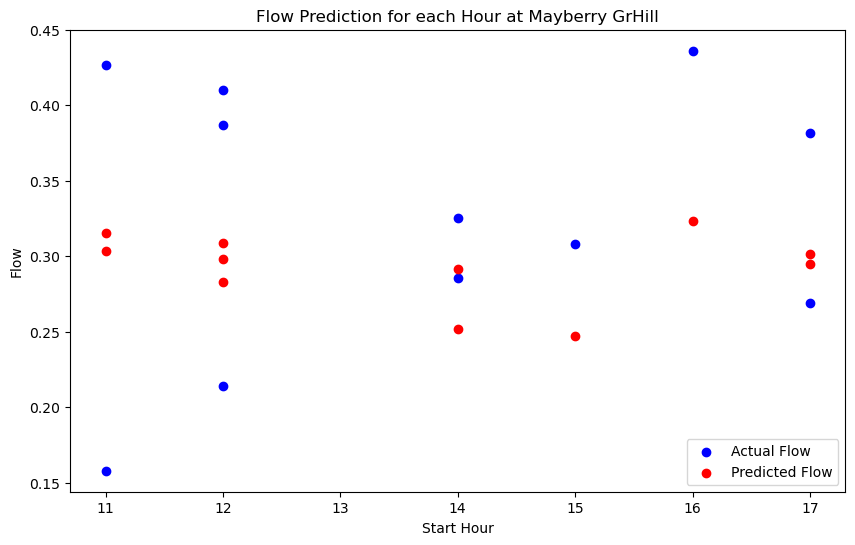

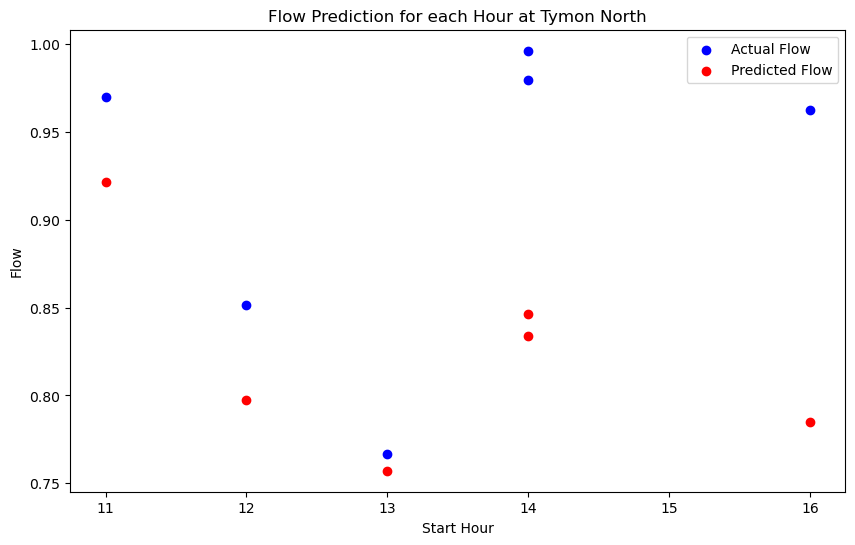

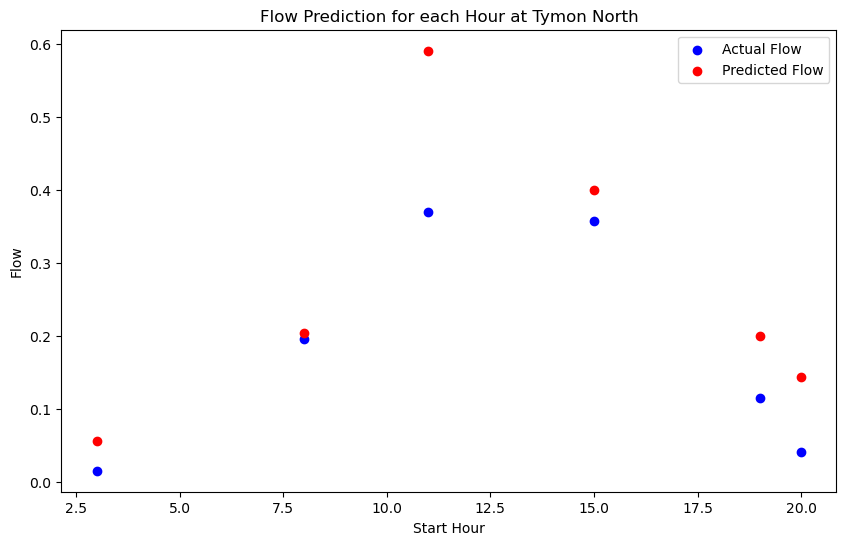

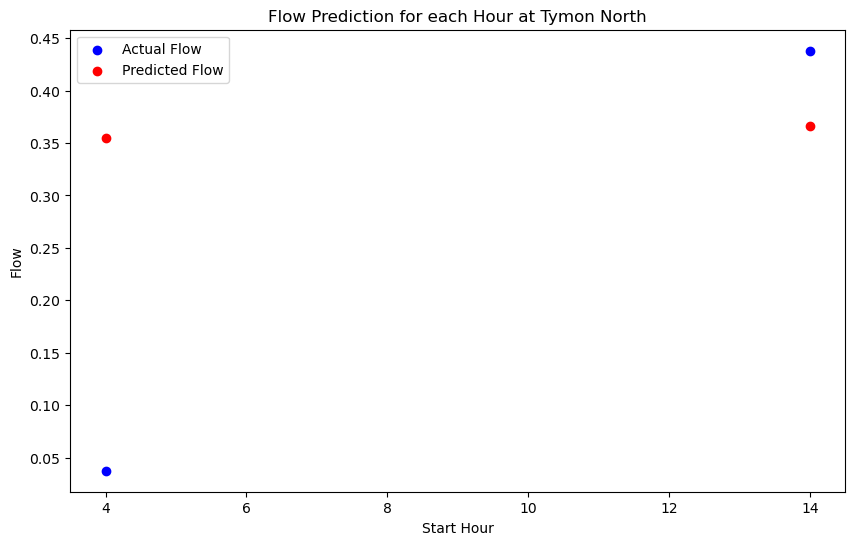

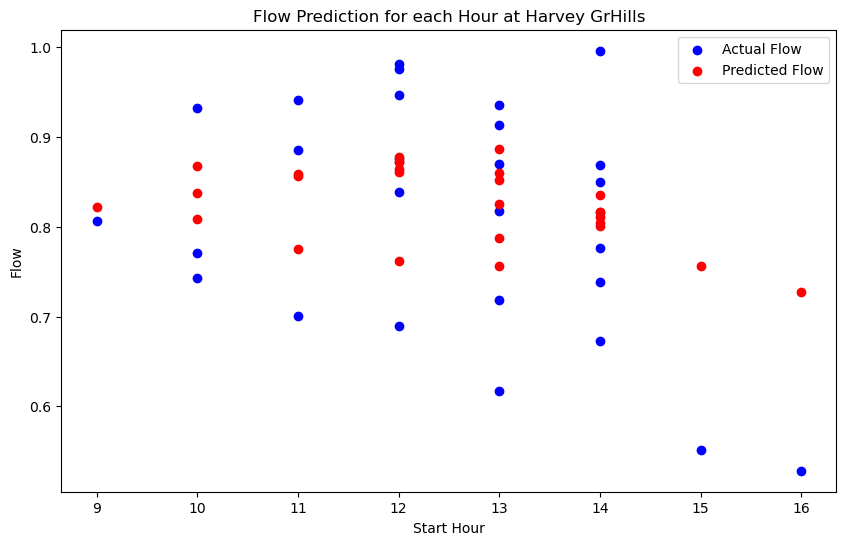

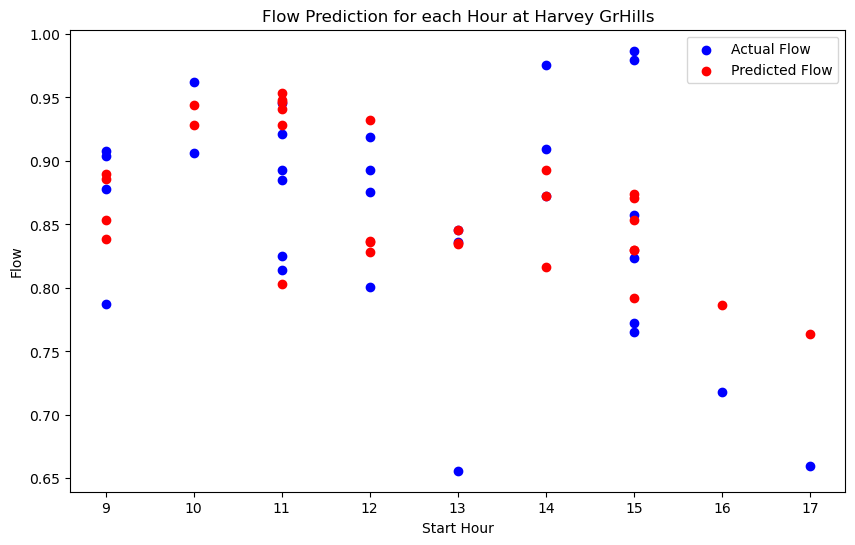

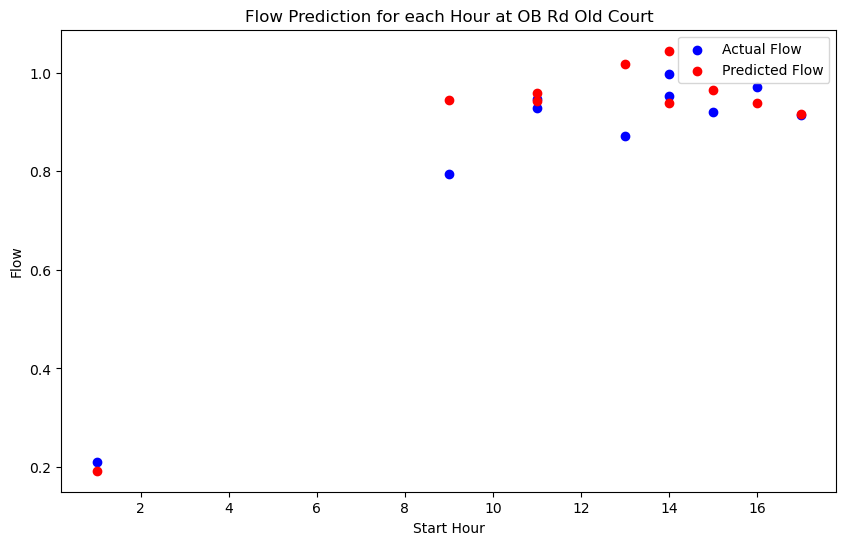

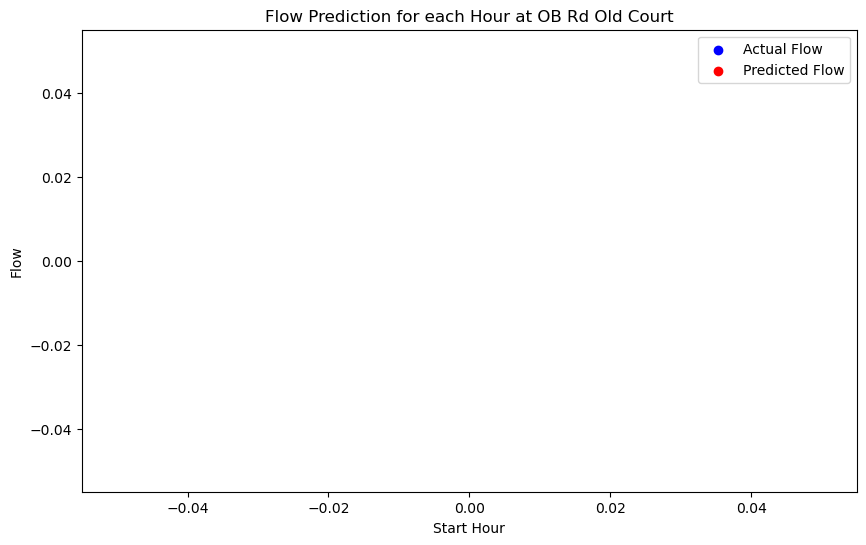

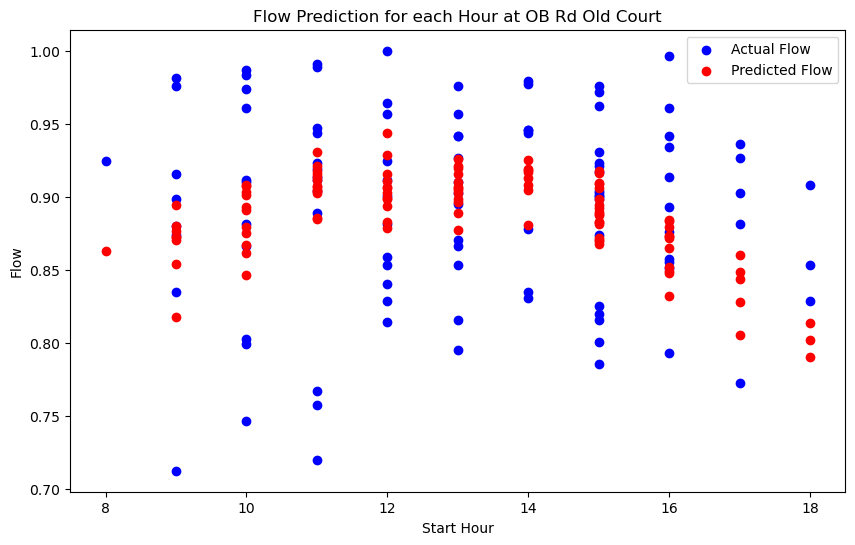

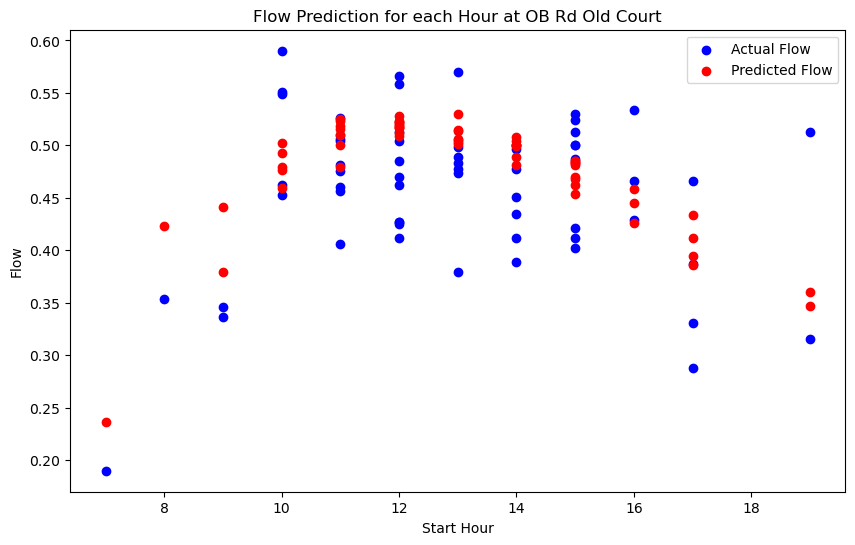

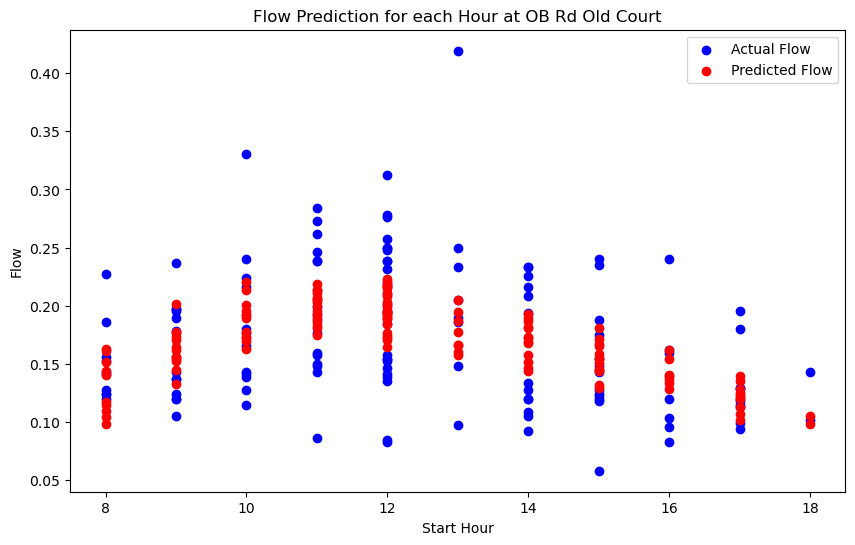

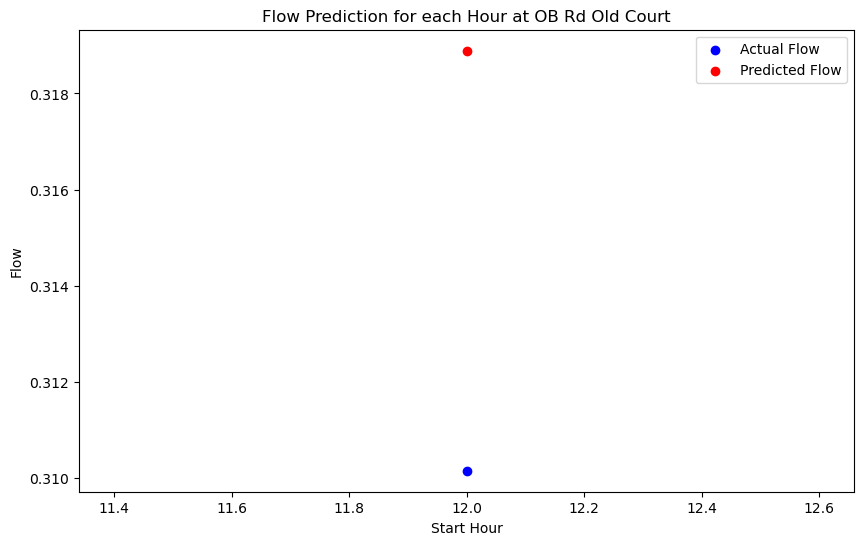

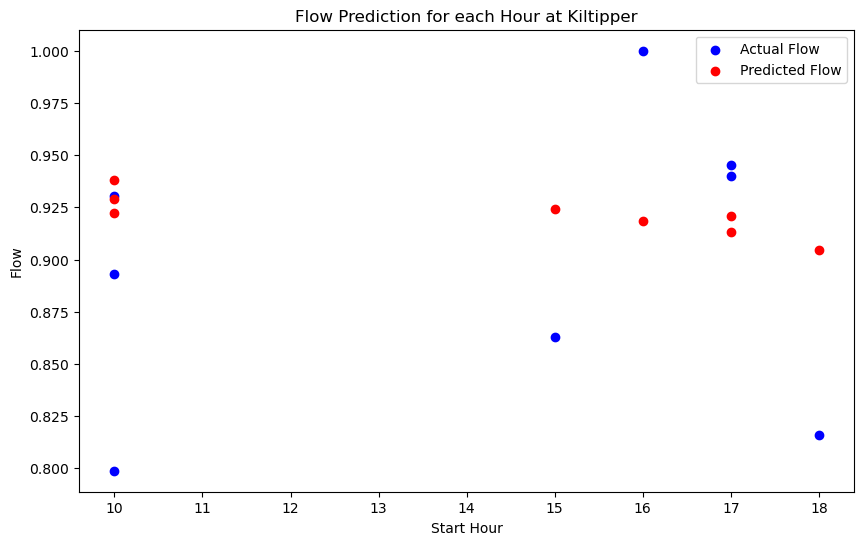

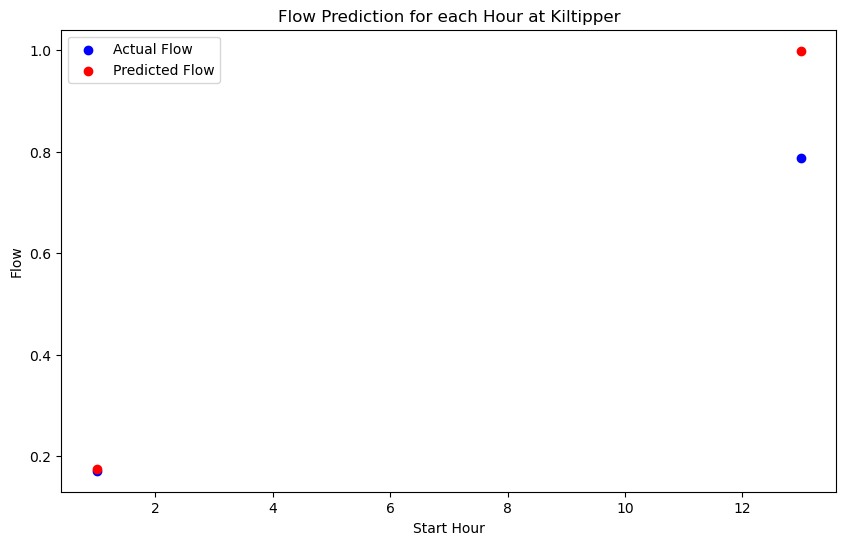

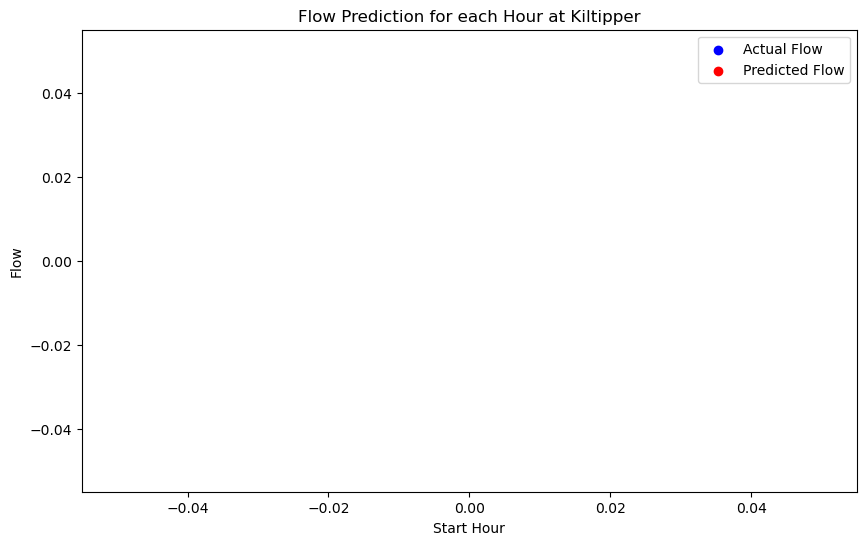

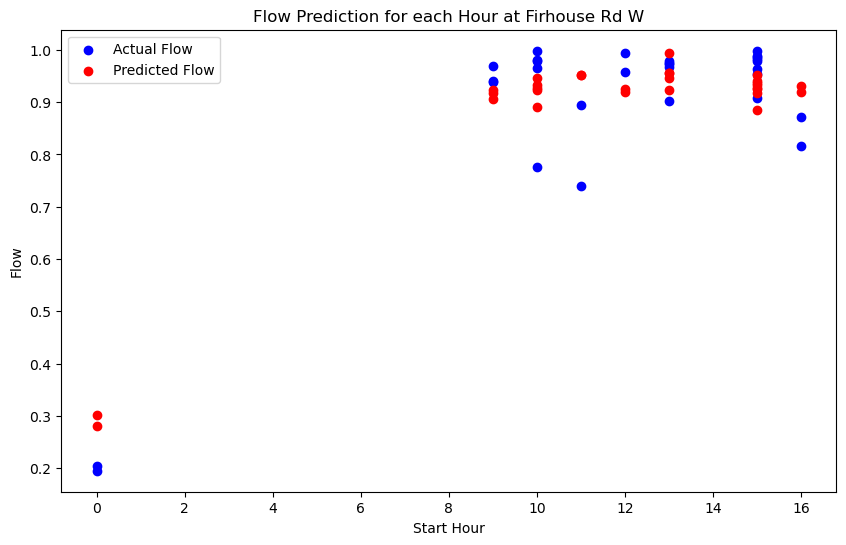

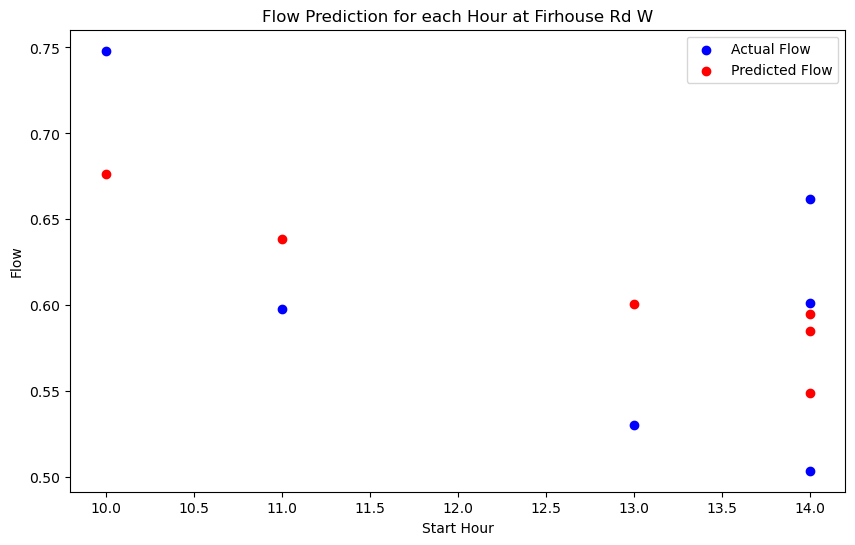

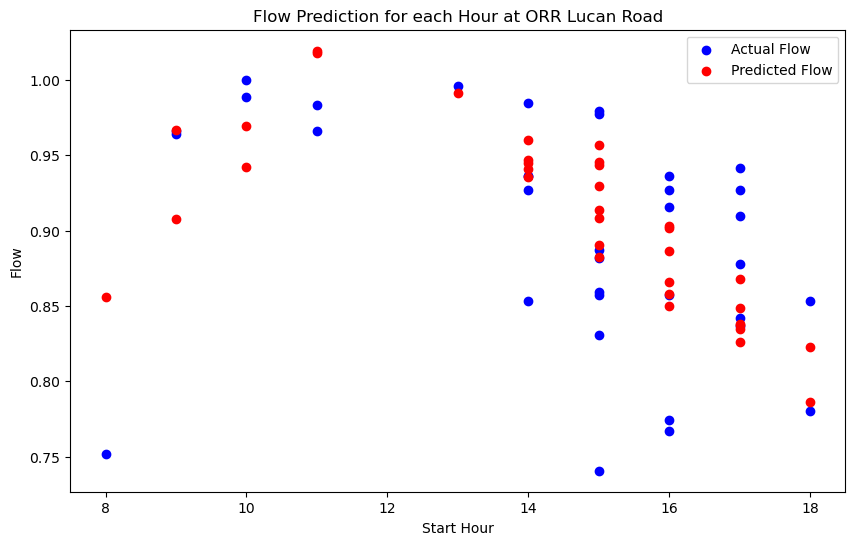

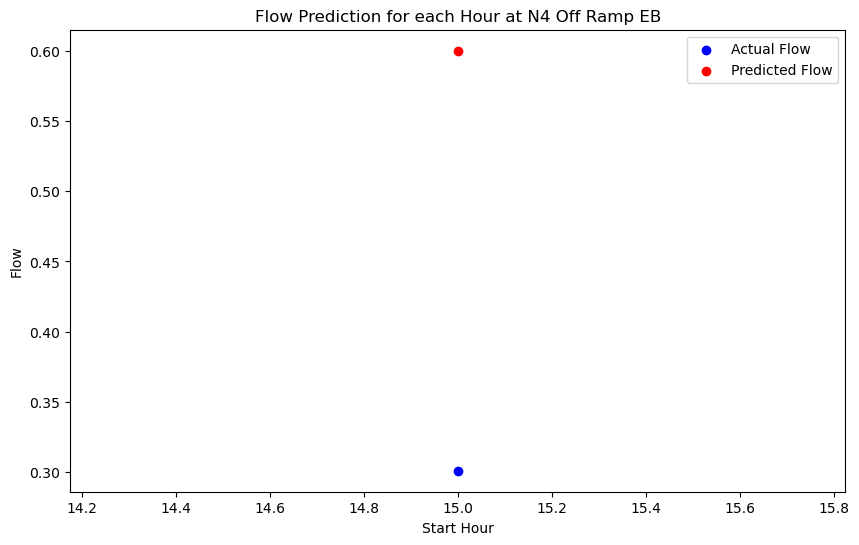

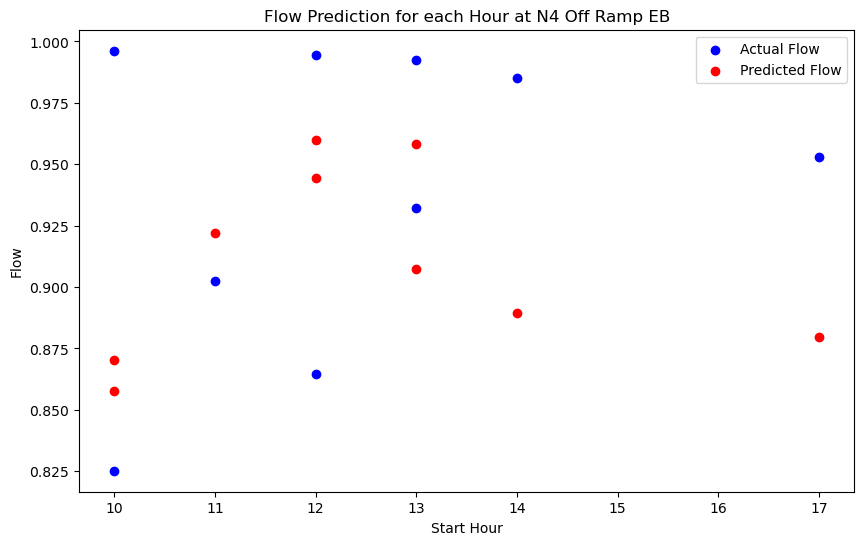

In [30]:
# Scatter Plot

for site in sites_columns:
    # Create a mask for the current site in the test data
    site_mask = X_test[site] == 1

    # Apply mask to y_test and predictions to filter the data for the current site
    y_test_site = y_test[site_mask]
    predictions_site = predictions[site_mask]
    
    # Since 'start_hour' is now part of X_test after normalization, we extract it for plotting
    start_hour_test_site = X_test.loc[site_mask, 'start_hour']

    # Convert start_hour_test_site to its original values (normalised)
    start_hour_test_site_values = start_hour_test_site.values
    
    # Sort by start_hour for plotting
    sorted_indices = np.argsort(start_hour_test_site_values)
    start_hour_test_site_sorted = start_hour_test_site.iloc[sorted_indices]
    y_test_site_sorted = y_test_site.iloc[sorted_indices]
    predictions_site_sorted = predictions_site[sorted_indices]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(start_hour_test_site_sorted.reset_index(drop=True), y_test_site_sorted['flow'], label='Actual Flow', color='blue')
    plt.scatter(start_hour_test_site_sorted.reset_index(drop=True), predictions_site_sorted[:, 0], label='Predicted Flow', color='red')
    plt.title(f'Flow Prediction for each Hour at {get_location_from_scn(site, scn_to_locn_mapping)}')
    plt.xlabel('Start Hour')
    plt.ylabel('Flow')
    plt.legend()
    plt.show()

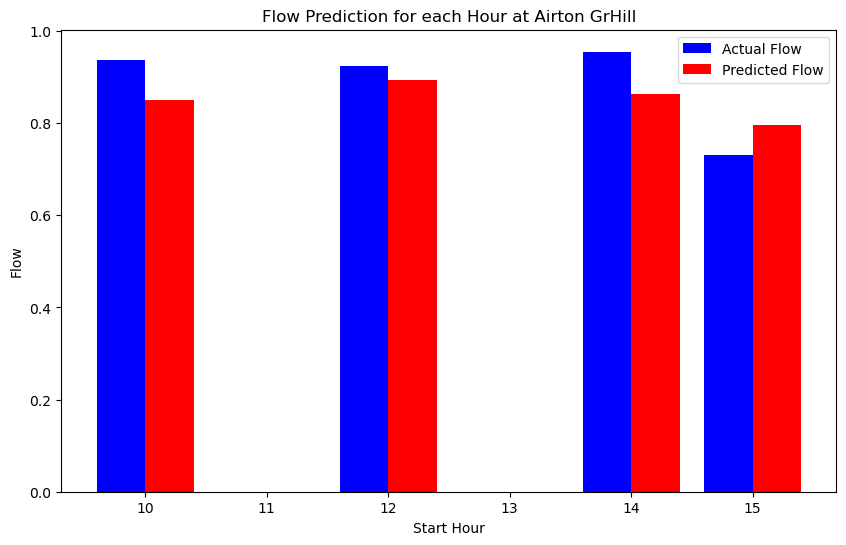

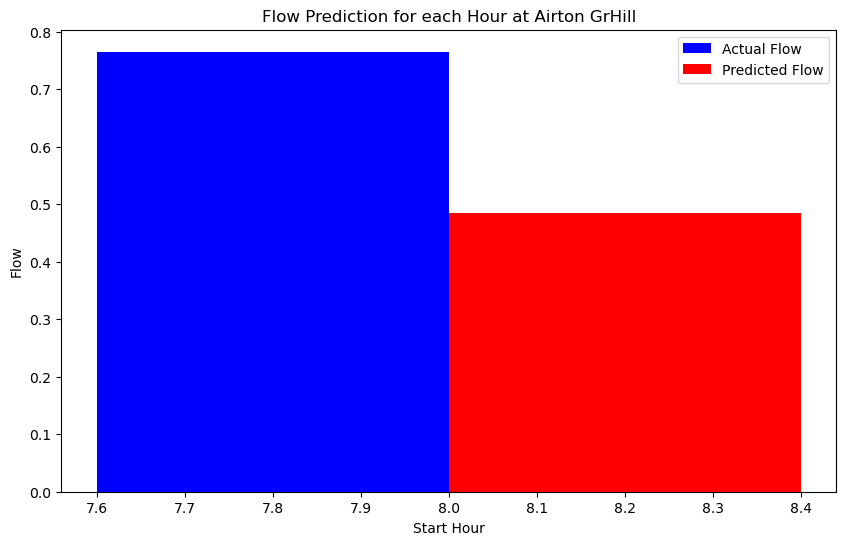

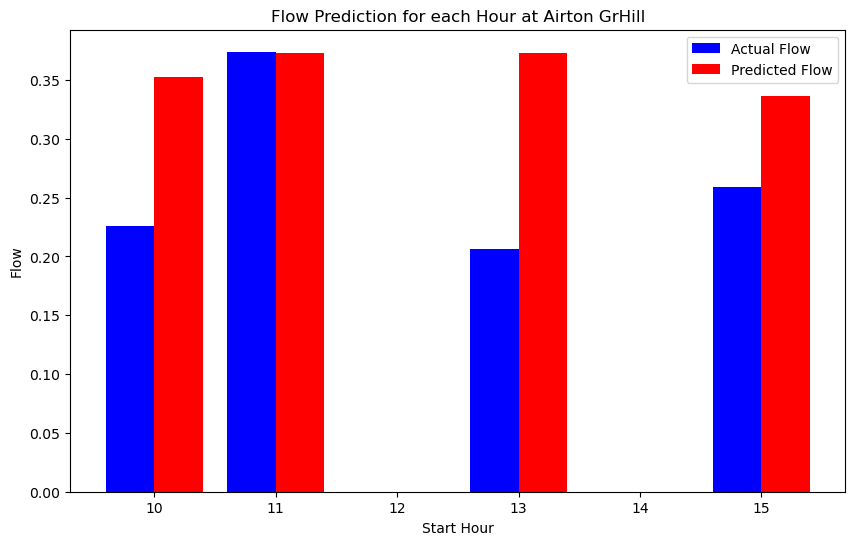

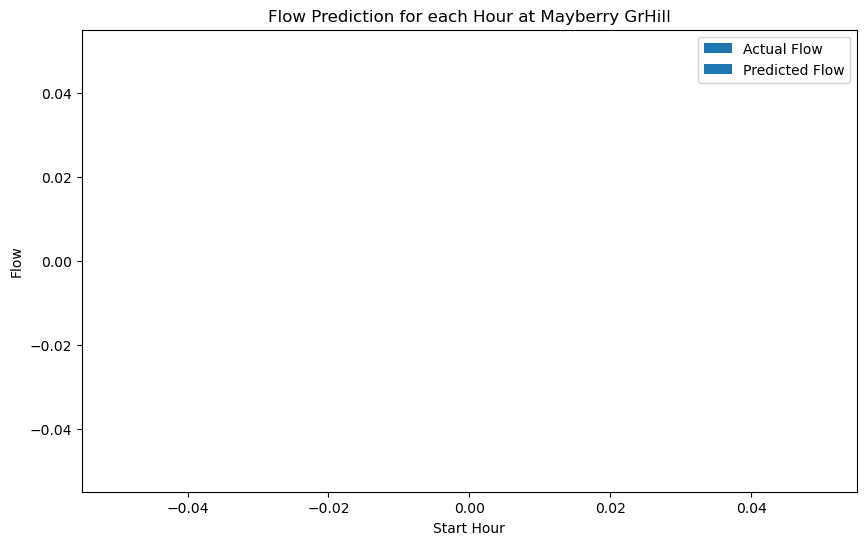

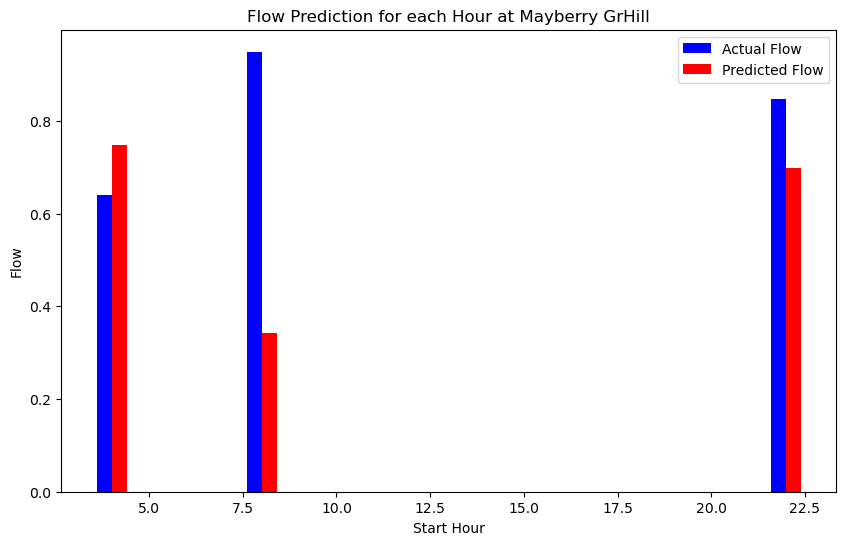

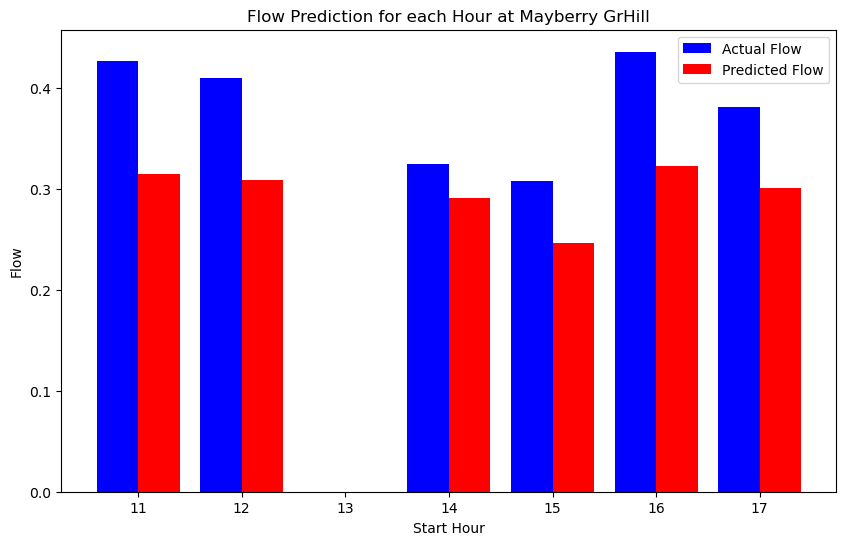

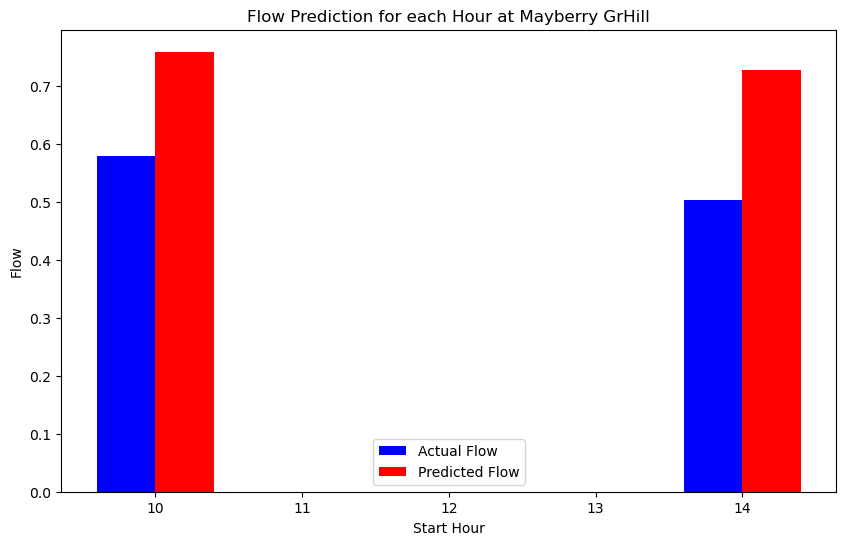

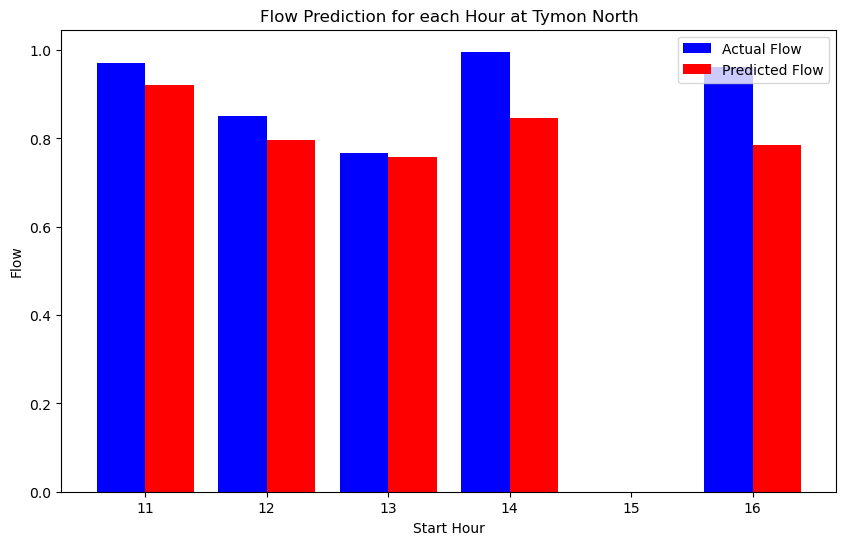

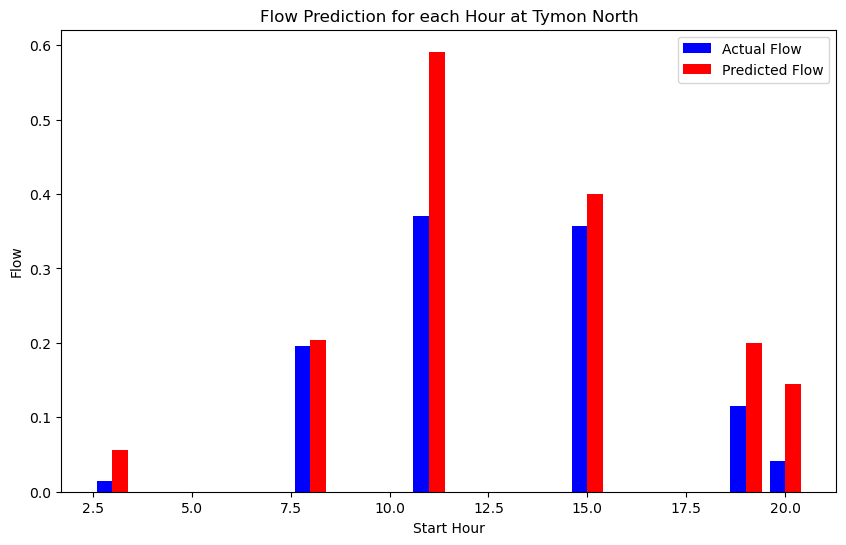

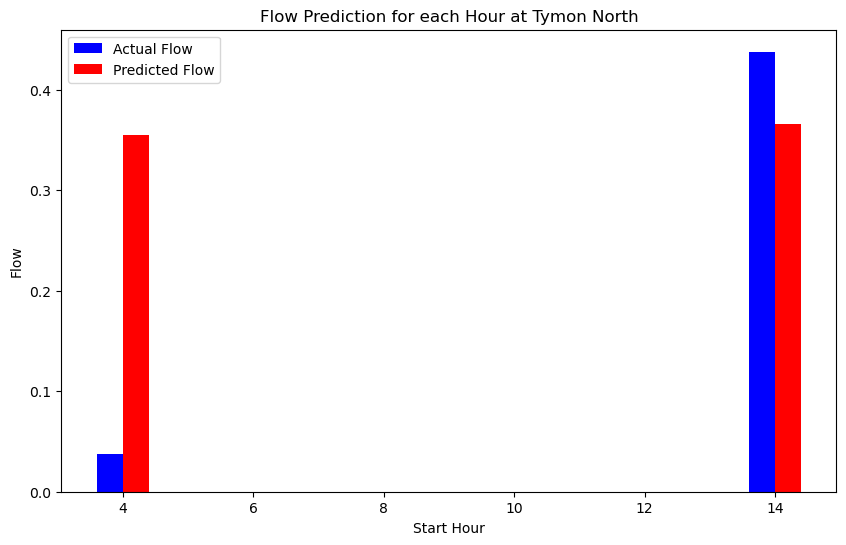

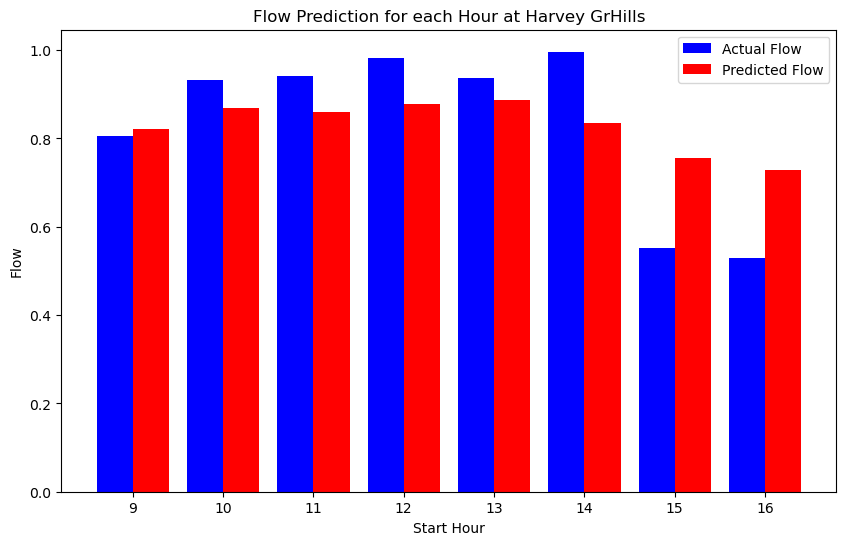

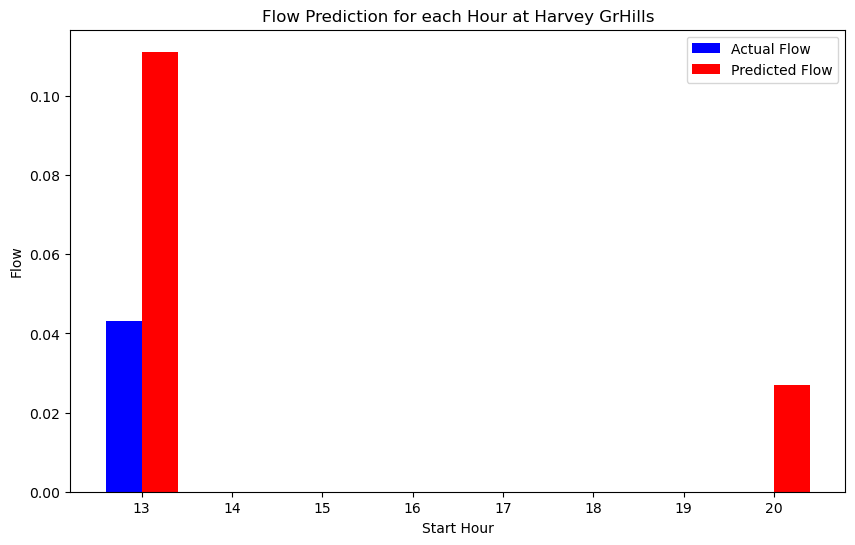

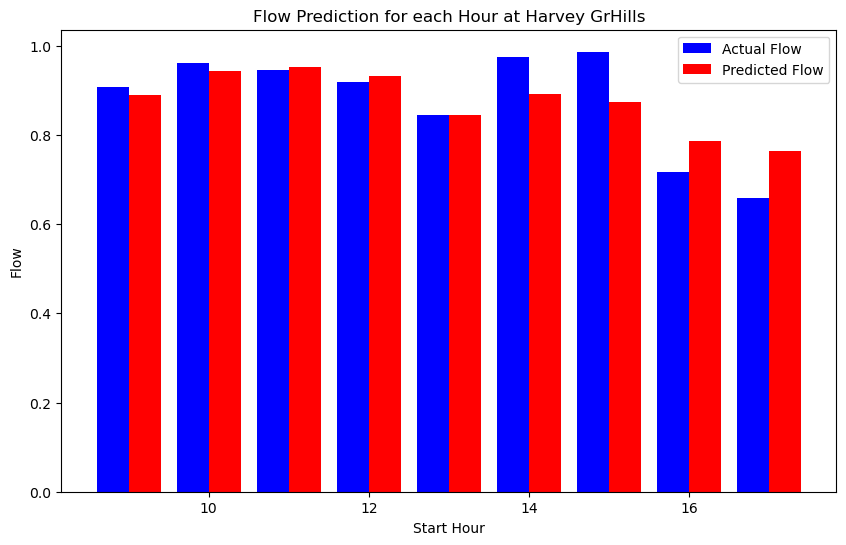

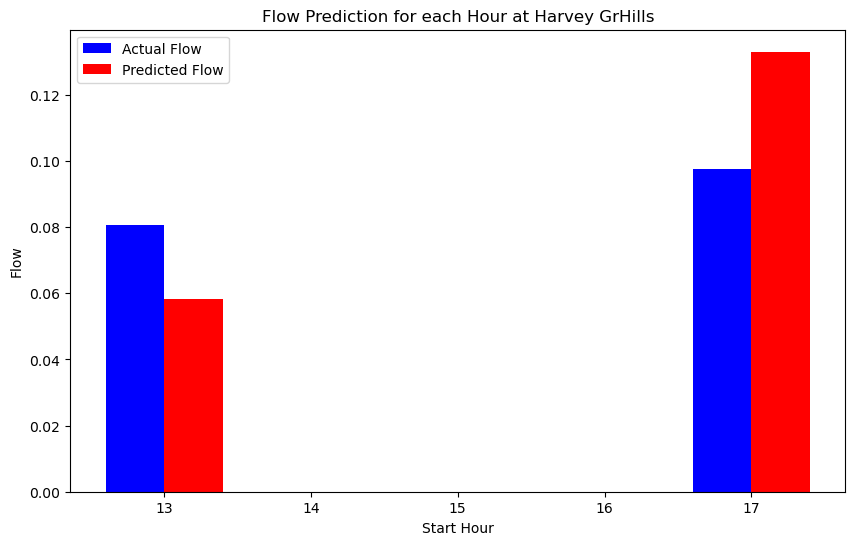

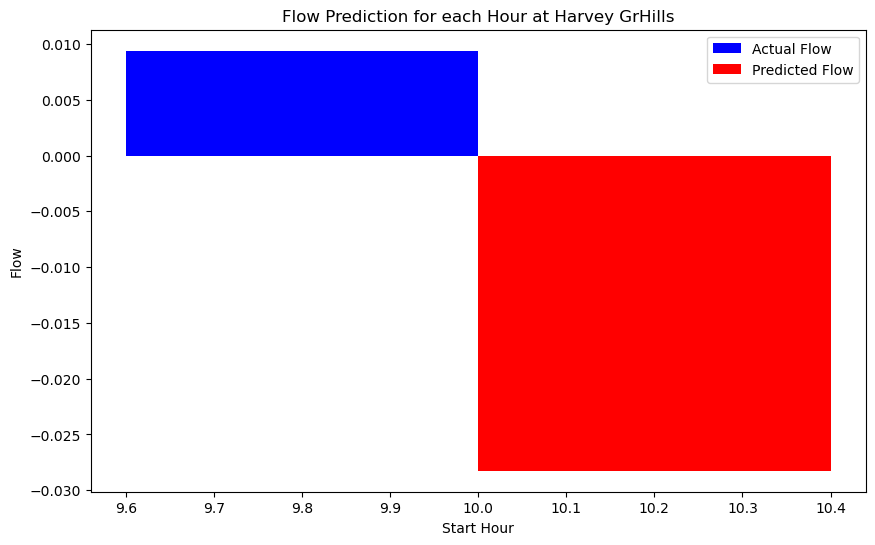

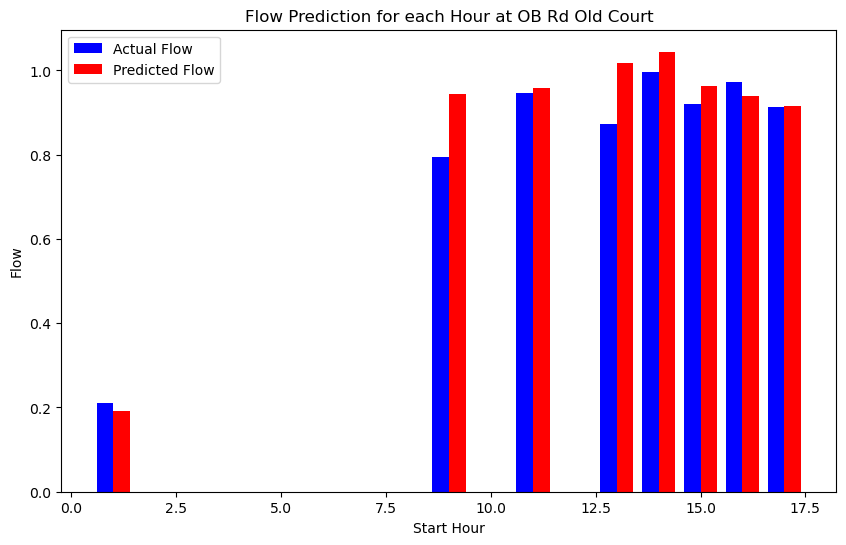

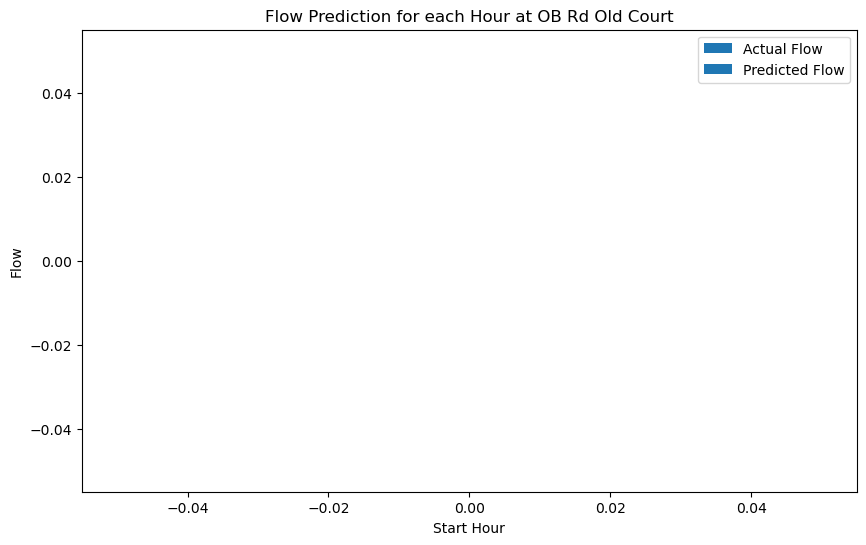

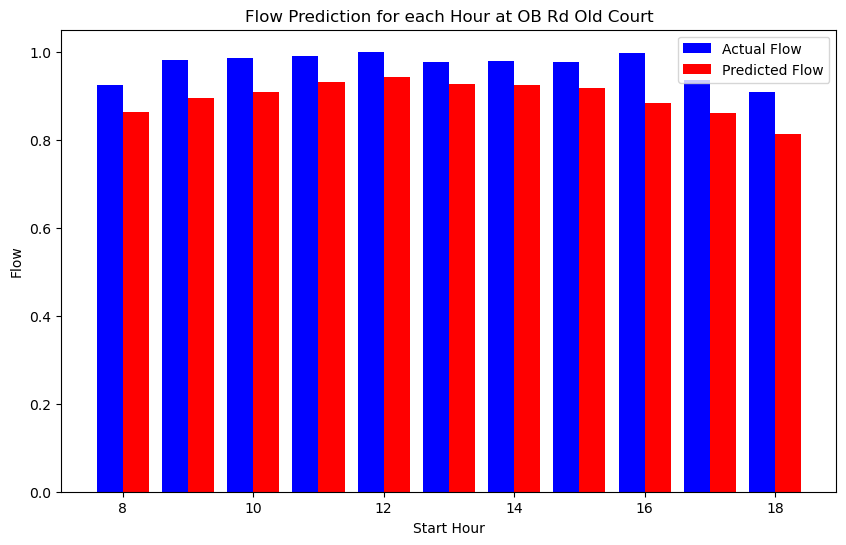

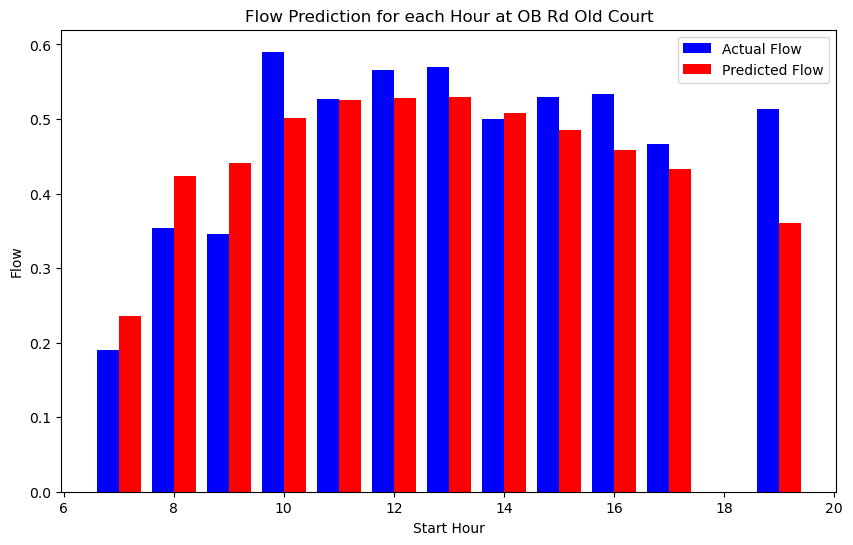

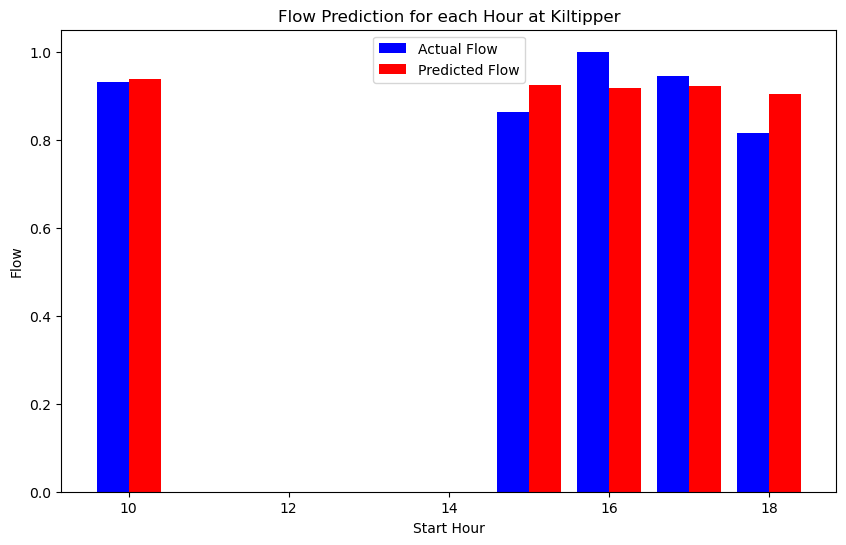

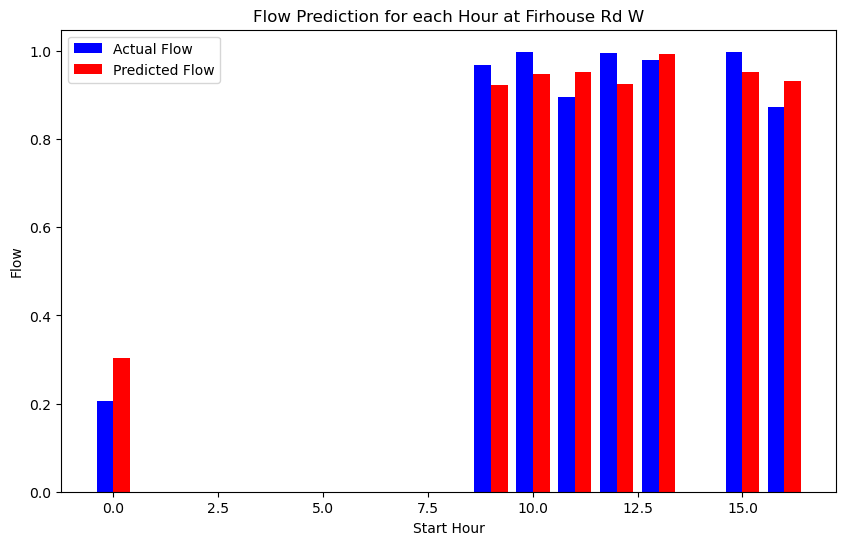

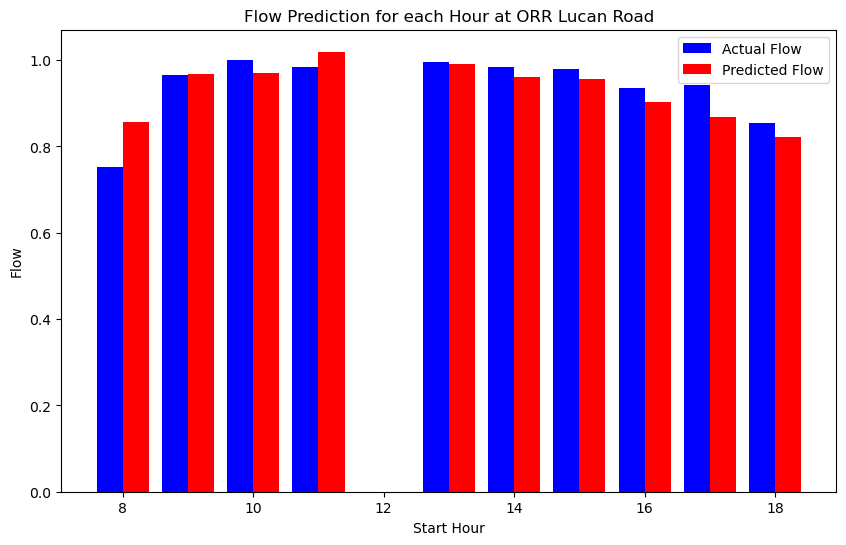

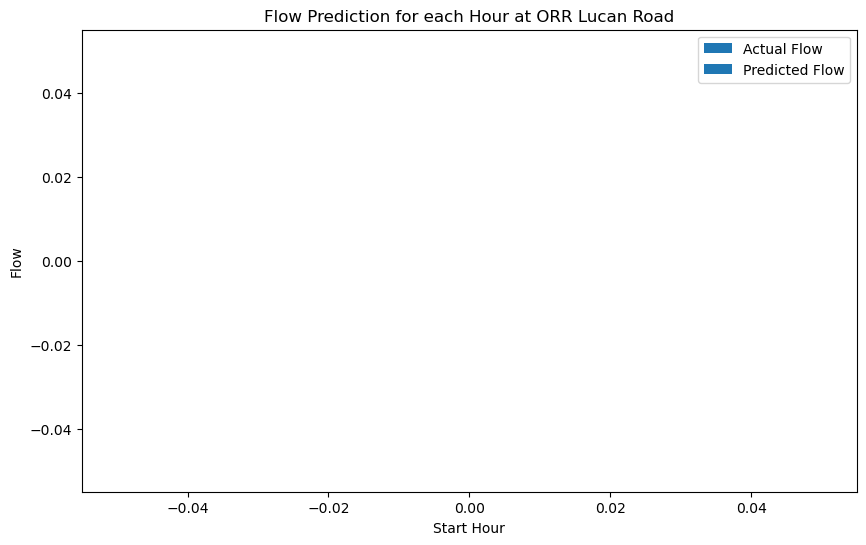

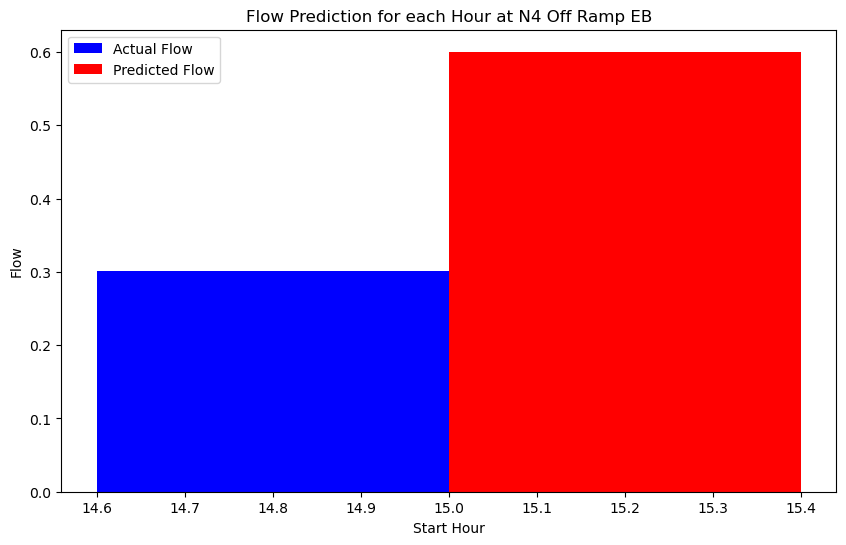

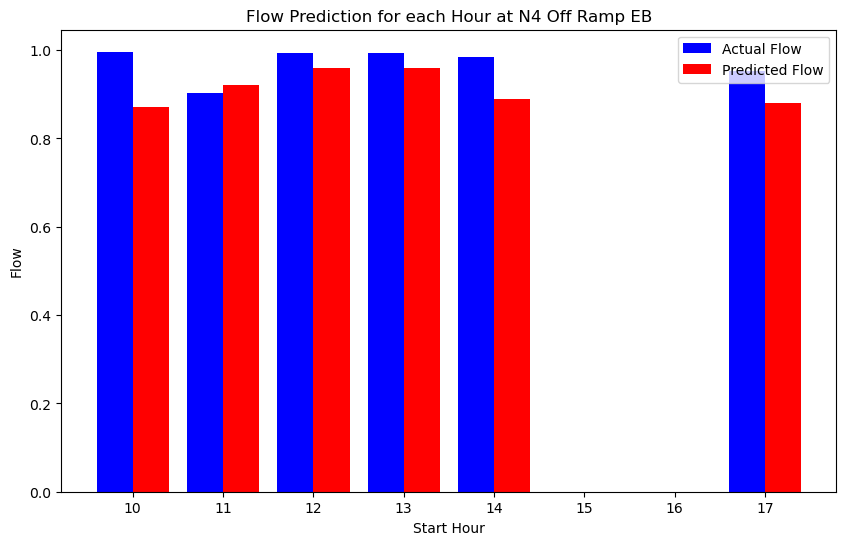

In [31]:
# Bar Chart
for site in sites_columns:
    # Create a mask for the current site in the test data
    site_mask = X_test[site] == 1

    # Apply mask to y_test and predictions to filter the data for the current site
    y_test_site = y_test[site_mask]
    predictions_site = predictions[site_mask]
    
    # Since 'start_hour' is now part of X_test after normalization, we extract it for plotting
    start_hour_test_site = X_test.loc[site_mask, 'start_hour']

    # Convert start_hour_test_site to its original values (normalised)
    start_hour_test_site_values = start_hour_test_site.values
    
    # Sort by start_hour for plotting
    sorted_indices = np.argsort(start_hour_test_site_values)
    start_hour_test_site_sorted = start_hour_test_site.iloc[sorted_indices]
    y_test_site_sorted = y_test_site.iloc[sorted_indices]
    predictions_site_sorted = predictions_site[sorted_indices]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(start_hour_test_site_sorted.reset_index(drop=True) - 0.2, y_test_site_sorted['flow'], width=0.4, label='Actual Flow', color='blue')
    plt.bar(start_hour_test_site_sorted.reset_index(drop=True) + 0.2, predictions_site_sorted[:, 0], width=0.4, label='Predicted Flow', color='red')
    plt.title(f'Flow Prediction for each Hour at {get_location_from_scn(site, scn_to_locn_mapping)}')
    plt.xlabel('Start Hour')
    plt.ylabel('Flow')
    plt.legend()
    plt.show()